# Time Series Forecasting - Autoregressive Models with Extra Regressors

What Is a ARIMAX, SARIMAX Model?

Article : https://365datascience.com/tutorials/python-tutorials/sarimax/

In [77]:
#%pip install pmdarima

import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import datetime
import math
import warnings


import pmdarima as pmd
from sklearn.metrics import mean_squared_error
from math import sqrt
from statsmodels.tsa.arima_model import ARMA, ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')

In [78]:
# In order to use this notebook for univarate time series analysis :-
# 1) The primary requirement is not to have missing values or categorial(string) data for time_dependent variable 
#    and time_column.
# 2) This cell requires information on file_name (only csv), time_dependent_variable, time_column, date_time format (frmt)
#    and resample grain(X). After filling the required information correctly, you can run all the cells (Cell ---> Run All)
# 3) Example :-
#   file_name               = "JetRail Avg Hourly Traffic Data - 2012-2013.csv"
#   time_dependent_variable = "Count"    (column name in your dataset)
#   time_column             = "Datetime" (column name in your dataset)
#   frmt                    = "%Y-%m-%d"
#   X                       = "D" 
file_name = "Monthly Production of Chocolate - Australia.csv"
time_dependent_variable = "Volume"
time_column = "Month"
frmt =  '%Y-%m'
Resample_grain = "M"
split= .9          #train and test split

### Reading the csv file

In [79]:
def data(method = "csv"):
    df = pd.read_csv(file_name, parse_dates= True)
    df[time_column] = pd.to_datetime(df[time_column],format=frmt) 
    df.index = df[time_column]
    df = df.resample(Resample_grain).mean()
    df.reset_index(inplace= True)
    return df
df = data()

### Splitting the data into train and test

In [80]:
def train_test_split_perc(df):
    total_size=len(df)
    train_size=math.floor(split*total_size)  #(70% Dataset)
    train=df.head(train_size)
    test=df.tail(len(df) -train_size)
    return train, test


In [81]:
def train_test_split_date(df, split_date):
    split_date = '2017-01-01'
    train = df.loc[df.index <= split_date].copy()
    test = df.loc[df.index > split_date].copy()
    return train, test

### Metrics

Probabilistic Model Selection with AIC/BIC in Python

https://medium.com/analytics-vidhya/probabilistic-model-selection-with-aic-bic-in-python-f8471d6add32#:~:text=AIC%20and%20BIC%20techniques%20can%20be%20implemented%20in,statsmodels.formula.api%20provides%20a%20direct%20approach%20to%20compute%20aic%2Fbic.

In [82]:
from sklearn import metrics

def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def timeseries_evaluation_metrics_func(y_true, y_pred):

    print('Evaluation metric results:-')
    print(f'MSE is : {metrics.mean_squared_error(y_true, y_pred)}')
    print(f'MAE is : {metrics.mean_absolute_error(y_true, y_pred)}')
    print(f'MAPE is : {mean_absolute_percentage_error(y_true,y_pred)}')
    print(f'R2 is : {metrics.r2_score(y_true, y_pred)}')
    print(f'RMSE is : {np.sqrt(metrics.mean_squared_error(y_true, y_pred))}',end='\n\n')

In [83]:
 def plot(method):
    plt.figure(figsize=(12,8))
    plt.plot(train[time_column], train[time_dependent_variable], label='Train')
    plt.plot(test[time_column],test[time_dependent_variable], label='Test')
    plt.plot(y_hat[time_column],y_hat[method], label= method +' forecast')
    plt.legend(loc='best')
    plt.title(method + ' forecast')
    plt.show()
    timeseries_evaluation_metrics_func(y_hat[time_dependent_variable], y_hat[method])


## Add your exogeneous variables 

In [84]:
def date_features(df):
    

    
    
    df['year'] = df[time_column].dt.year
    df['quarter'] = df[time_column].dt.quarter
    df['month'] = df[time_column].dt.month
    df['week_day'] = df[time_column].dt.weekday
    

    
    

    return df
df= date_features(df)

In [85]:
df.head()

Month  Volume  year  quarter  month  week_day
0 1957-07-31    2953  1957        3      7         2
1 1957-08-31    2635  1957        3      8         5
2 1957-09-30    2404  1957        3      9         0
3 1957-10-31    2413  1957        4     10         3
4 1957-11-30    2136  1957        4     11         5

### columns reorder with extra regressors

https://stackoverflow.com/questions/35321812/move-column-in-pandas-dataframe 
This function will reorder your columns with time column as first column and time dependent variable column as the last column

In [86]:
df.columns

Index(['Month', 'Volume', 'year', 'quarter', 'month', 'week_day'], dtype='object')

In [87]:
[ col for col in df.columns if col not in [time_column, time_dependent_variable]]

['year', 'quarter', 'month', 'week_day']

In [88]:
def column_reorder(df):
    df = df[[time_column] + 
        [ col for col in df.columns if col not in [time_column, time_dependent_variable]] + 
        [time_dependent_variable]]
    return df
df = column_reorder(df)
df.head()

Month  year  quarter  month  week_day  Volume
0 1957-07-31  1957        3      7         2    2953
1 1957-08-31  1957        3      8         5    2635
2 1957-09-30  1957        3      9         0    2404
3 1957-10-31  1957        4     10         3    2413
4 1957-11-30  1957        4     11         5    2136

### Train and test split with extra regressors

In [89]:
train, test = train_test_split_perc(df)
y_hat = test.copy()

In [90]:
def extra_regressors(exog_variables_names):
    
    exog_train = train[exog_variables_names]
    exog_test = test[exog_variables_names]
    return exog_train, exog_test


i denotes the starting position of the extra regressors columns 

do call the column_reorder() function before

In [91]:
def extra_regressors_with_iloc(i=1):
    exog_train = train.iloc[: , i : -1]
    exog_test = test.iloc[: , i : -1]
    return exog_train, exog_test 
exog_train, exog_test = extra_regressors_with_iloc()

In [92]:
exog_test.shape

(46, 4)

In [93]:
exog_test.head()

year  quarter  month  week_day
412  1991        4     11         5
413  1991        4     12         1
414  1992        1      1         4
415  1992        1      2         5
416  1992        1      3         1

# Extra Regressors Selection using Xgboost

https://machinelearningmastery.com/feature-importance-and-feature-selection-with-xgboost-in-python/#:~:text=The%20XGBoost%20library%20provides%20a%20built-in%20function%20to,Indians%20dataset%20using%20the%20built-in%20plot_importance%20%28%29%20function.
Feature Importance with xgboost

In [94]:
import xgboost as xgb
from xgboost import plot_importance, plot_tree

In [95]:
train, test = train_test_split_perc(df)
train_X, train_Y = exog_train, train.iloc[:, -1]
test_X, test_Y = exog_test, test.iloc[:, -1]
train_X.head()

year  quarter  month  week_day
0  1957        3      7         2
1  1957        3      8         5
2  1957        3      9         0
3  1957        4     10         3
4  1957        4     11         5

[0.5867216  0.03498719 0.3579687  0.02032248]


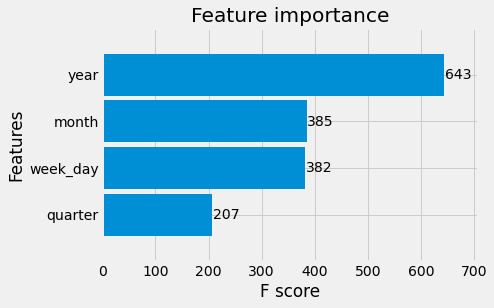

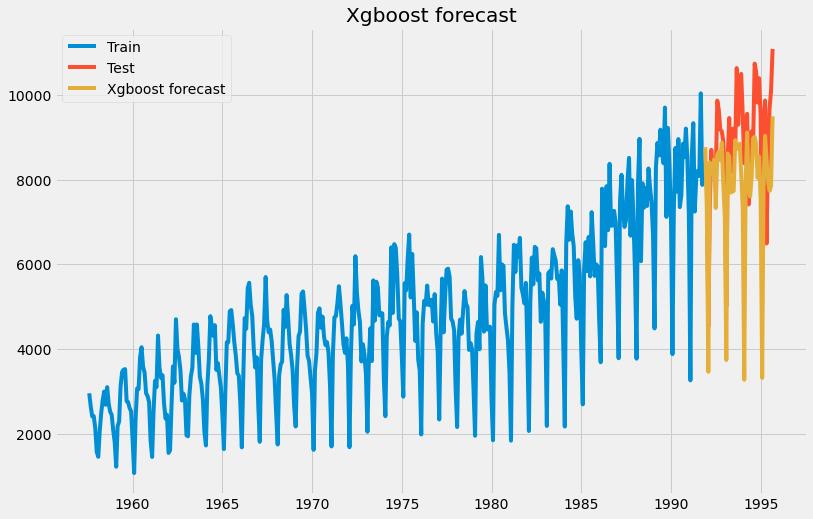

Evaluation metric results:-
MSE is : 2294103.4666934297
MAE is : 1232.889255689538
MAPE is : 14.221848362518386
R2 is : -0.2068594739953573
RMSE is : 1514.6298117670303



In [96]:
def xgboost(method= "Xgboost"):
    
    reg = xgb.XGBRegressor()
    reg.fit(train_X, train_Y,
            eval_set=[(train_X, train_Y), (test_X, test_Y )],
            early_stopping_rounds=5,
           verbose=False)
    
    print(reg.feature_importances_)

    y_hat[method] = reg.predict(test_X)
    _ = plot_importance(reg, height=0.9)
    plot(method= "Xgboost")
    
xgboost(method= "Xgboost")

the number next to each of the bar is a scaled importance, it really only has meaning relative to other features

You can learn more about the F1 score here:
https://en.wikipedia.org/wiki/F1_score

Keeping only the best features

In [97]:
# best_features = ["ID", "week_day"]

In [98]:
# exog_train, exog_test = extra_regressors(exog_variables_names= best_features)
# exog_train.head()# feature selection

# ARX

If you want only specific list of lags like 1 & 3 as AR components, then you can do that in the following way
https://stackoverflow.com/questions/55882111/arima-model-for-certain-lags

In [99]:
trend = "ct"

In [100]:
def diagnostic_plot(model_fit, lags= 30):
    fig = plt.figure(figsize=(16, 9))
    fig = model_fit.plot_diagnostics(fig=fig, lags=lags)
    print(model_fit.summary())
    print("aic = " +  str(model_fit.aic))
    print("bic = " + str(model_fit.bic))

# Choose the metrics that you want to minimize

In [101]:
def metrics_( method):
    mse = mean_squared_error(test[time_dependent_variable], y_hat[method])
     
    mae = metrics.mean_absolute_error(test[time_dependent_variable], y_hat[method])
    mape = mean_absolute_percentage_error(test[time_dependent_variable], y_hat[method])
    r2 = metrics.r2_score(test[time_dependent_variable], y_hat[method])
    return mape

                            AutoReg Model Results                             
Dep. Variable:                 Volume   No. Observations:                  412
Model:                   AutoReg-X(7)   Log Likelihood               -3358.316
Method:               Conditional MLE   S.D. of innovations            966.036
Date:                Sat, 09 Oct 2021   AIC                             13.816
Time:                        10:19:37   BIC                             13.954
Sample:                             7   HQIC                            13.870
                                  412                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0056      0.003      1.688      0.091      -0.001       0.012
trend          6.6864      1.120      5.970      0.000       4.491       8.882
Volume.L1      0.5225      0.052      9.968      0.0

19.791583015358615

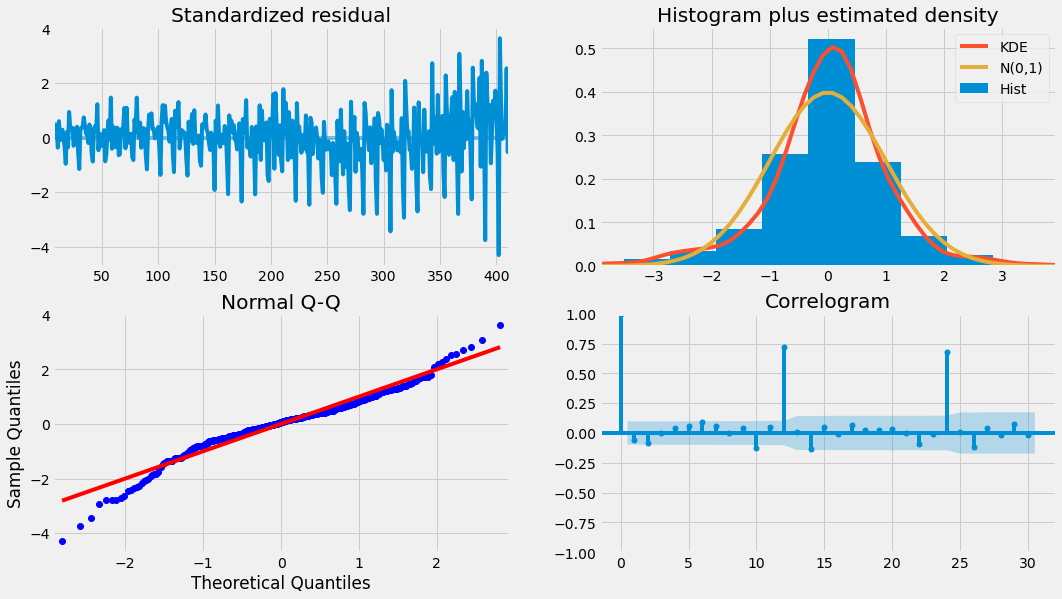

In [102]:
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.ar_model import AutoReg, ar_select_order

def arx(lags , method = "ARX"):


    model = AutoReg(train[time_dependent_variable], lags=lags,exog = exog_train, trend= trend)
    
    fit1 = model.fit()
    diagnostic_plot(fit1, lags= 30)
    
    y_hat[method] = fit1.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False, exog_oos= exog_test)
    
     
    return metrics_(method)
arx(lags= 7)

### ARX with Seasonality = True

we have to specify the number of periods as well

                            AutoReg Model Results                             
Dep. Variable:                 Volume   No. Observations:                  412
Model:             Seas. AutoReg-X(7)   Log Likelihood               -3358.024
Method:               Conditional MLE   S.D. of innovations            965.338
Date:                Sat, 09 Oct 2021   AIC                             13.844
Time:                        10:19:37   BIC                             14.041
Sample:                             7   HQIC                            13.922
                                  412                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0055      0.003      1.682      0.093      -0.001       0.012
trend          6.6800      1.119      5.968      0.000       4.486       8.874
seasonal.1    11.8372    179.449      0.066      0.9

19.762243644734667

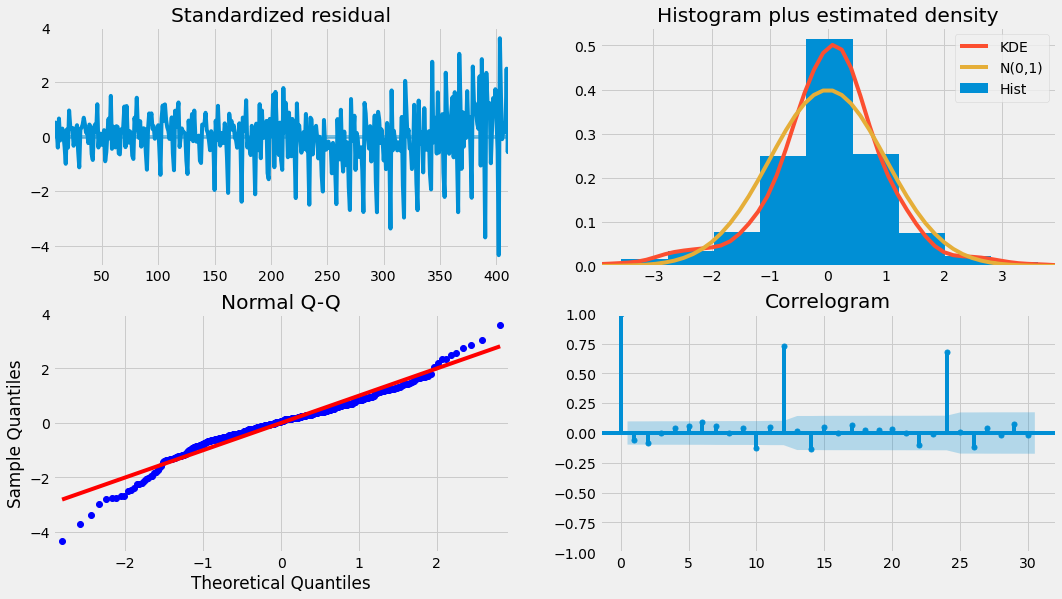

In [103]:
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.ar_model import AutoReg, ar_select_order

def arx_seasonal(lags ,seasonal=True, period = 7 ,method = "ARX"):


    model = AutoReg(train[time_dependent_variable], lags=lags,exog = exog_train, trend= trend, seasonal=seasonal, period =period)
    
    fit1 = model.fit()
    diagnostic_plot(fit1, lags= 30)
    
    y_hat[method] = fit1.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False, exog_oos= exog_test)
    
     
    return metrics_(method)
arx_seasonal(lags= 7)

                            AutoReg Model Results                             
Dep. Variable:                 Volume   No. Observations:                  412
Model:                   AutoReg-X(0)   Log Likelihood               -3493.233
Method:               Conditional MLE   S.D. of innovations           1164.191
Date:                Sat, 09 Oct 2021   AIC                             14.154
Time:                        10:19:38   BIC                             14.222
Sample:                             0   HQIC                            14.181
                                  412                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0072      0.003      2.404      0.016       0.001       0.013
trend         11.9985      0.486     24.689      0.000      11.046      12.951
year           1.1645      0.105     11.073      0.0

                            AutoReg Model Results                             
Dep. Variable:                 Volume   No. Observations:                  412
Model:                   AutoReg-X(6)   Log Likelihood               -3366.277
Method:               Conditional MLE   S.D. of innovations            965.247
Date:                Sat, 09 Oct 2021   AIC                             13.809
Time:                        10:19:39   BIC                             13.937
Sample:                             6   HQIC                            13.860
                                  412                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0057      0.003      1.746      0.081      -0.001       0.012
trend          6.8107      1.061      6.419      0.000       4.731       8.890
Volume.L1      0.5209      0.052     10.022      0.0

                            AutoReg Model Results                             
Dep. Variable:                 Volume   No. Observations:                  412
Model:                  AutoReg-X(10)   Log Likelihood               -3328.401
Method:               Conditional MLE   S.D. of innovations            954.002
Date:                Sat, 09 Oct 2021   AIC                             13.806
Time:                        10:19:39   BIC                             13.975
Sample:                            10   HQIC                            13.873
                                  412                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0020      0.004      0.494      0.622      -0.006       0.010
trend          5.4382      1.179      4.613      0.000       3.128       7.749
Volume.L1      0.5017      0.056      8.946      0.0

                            AutoReg Model Results                             
Dep. Variable:                 Volume   No. Observations:                  412
Model:                  AutoReg-X(13)   Log Likelihood               -3088.092
Method:               Conditional MLE   S.D. of innovations            555.928
Date:                Sat, 09 Oct 2021   AIC                             12.742
Time:                        10:19:40   BIC                             12.941
Sample:                            13   HQIC                            12.821
                                  412                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0082      0.003      3.098      0.002       0.003       0.013
trend          0.9057      0.712      1.271      0.204      -0.491       2.302
Volume.L1      0.2720      0.049      5.606      0.0

ARX(15,) metric=10.676
                            AutoReg Model Results                             
Dep. Variable:                 Volume   No. Observations:                  412
Model:                  AutoReg-X(16)   Log Likelihood               -3052.349
Method:               Conditional MLE   S.D. of innovations            538.622
Date:                Sat, 09 Oct 2021   AIC                             12.694
Time:                        10:19:40   BIC                             12.925
Sample:                            16   HQIC                            12.786
                                  412                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0066      0.003      2.497      0.013       0.001       0.012
trend          1.4025      0.700      2.004      0.045       0.031       2.774
Volume.L1      0.2175      0.

                            AutoReg Model Results                             
Dep. Variable:                 Volume   No. Observations:                  412
Model:                  AutoReg-X(19)   Log Likelihood               -3028.409
Method:               Conditional MLE   S.D. of innovations            537.504
Date:                Sat, 09 Oct 2021   AIC                             12.706
Time:                        10:19:40   BIC                             12.969
Sample:                            19   HQIC                            12.810
                                  412                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0072      0.003      2.634      0.008       0.002       0.013
trend          1.5543      0.712      2.183      0.029       0.159       2.950
Volume.L1      0.2168      0.050      4.341      0.0

                            AutoReg Model Results                             
Dep. Variable:                 Volume   No. Observations:                  412
Model:                  AutoReg-X(21)   Log Likelihood               -3011.605
Method:               Conditional MLE   S.D. of innovations            535.594
Date:                Sat, 09 Oct 2021   AIC                             12.710
Time:                        10:19:41   BIC                             12.994
Sample:                            21   HQIC                            12.823
                                  412                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0085      0.003      3.045      0.002       0.003       0.014
trend          1.4260      0.718      1.987      0.047       0.019       2.833
Volume.L1      0.2179      0.050      4.361      0.0

                            AutoReg Model Results                             
Dep. Variable:                 Volume   No. Observations:                  412
Model:                  AutoReg-X(23)   Log Likelihood               -2995.601
Method:               Conditional MLE   S.D. of innovations            534.769
Date:                Sat, 09 Oct 2021   AIC                             12.718
Time:                        10:19:41   BIC                             13.024
Sample:                            23   HQIC                            12.839
                                  412                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0087      0.003      2.990      0.003       0.003       0.014
trend          1.3537      0.725      1.868      0.062      -0.067       2.774
Volume.L1      0.2148      0.050      4.288      0.0

                            AutoReg Model Results                             
Dep. Variable:                 Volume   No. Observations:                  412
Model:                  AutoReg-X(25)   Log Likelihood               -2951.788
Method:               Conditional MLE   S.D. of innovations            496.915
Date:                Sat, 09 Oct 2021   AIC                             12.582
Time:                        10:19:41   BIC                             12.910
Sample:                            25   HQIC                            12.712
                                  412                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0075      0.003      2.692      0.007       0.002       0.013
trend          0.8237      0.681      1.210      0.226      -0.511       2.158
Volume.L1      0.2487      0.050      4.924      0.0

                            AutoReg Model Results                             
Dep. Variable:                 Volume   No. Observations:                  412
Model:                  AutoReg-X(27)   Log Likelihood               -2935.987
Method:               Conditional MLE   S.D. of innovations            496.211
Date:                Sat, 09 Oct 2021   AIC                             12.591
Time:                        10:19:42   BIC                             12.940
Sample:                            27   HQIC                            12.729
                                  412                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0070      0.003      2.481      0.013       0.001       0.012
trend          0.9402      0.686      1.371      0.170      -0.404       2.285
Volume.L1      0.2435      0.051      4.809      0.0

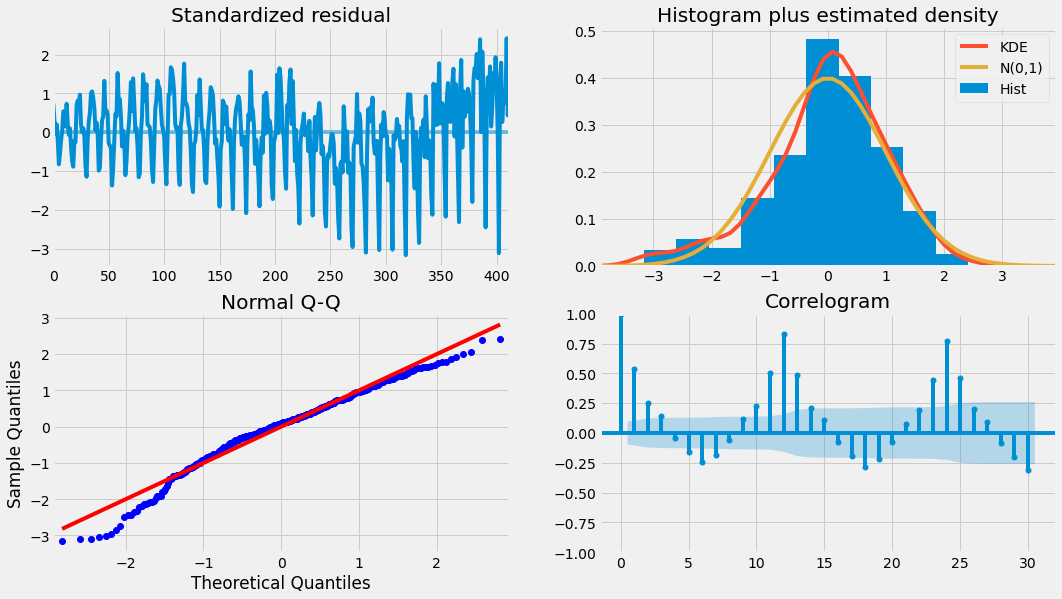

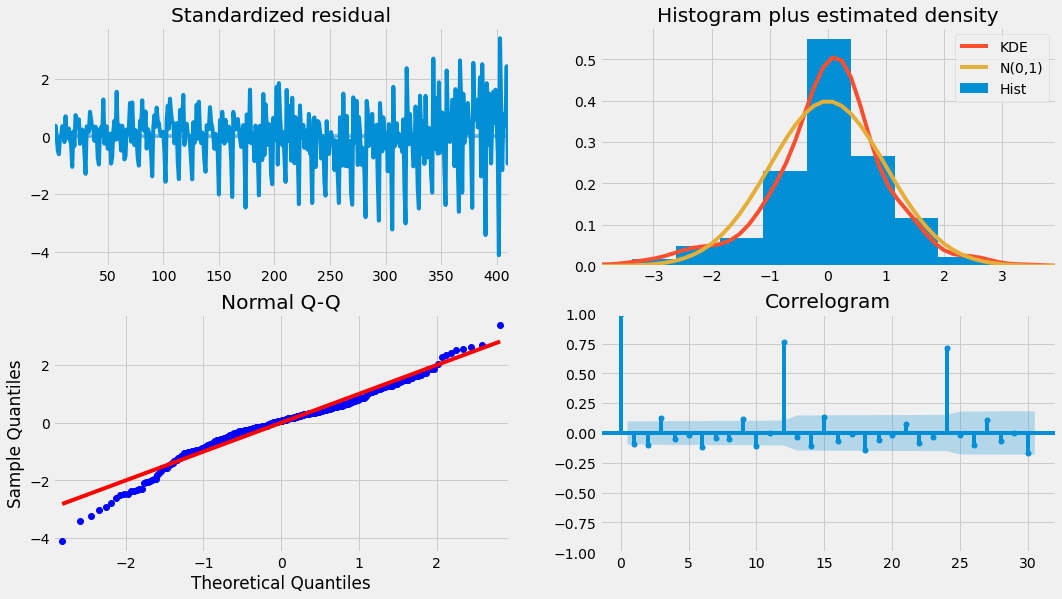

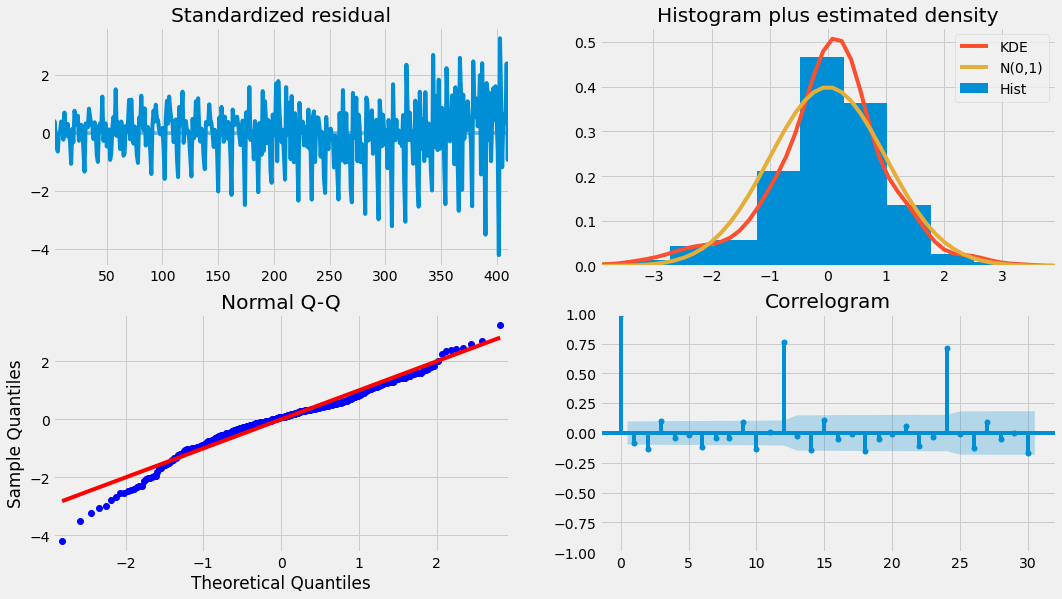

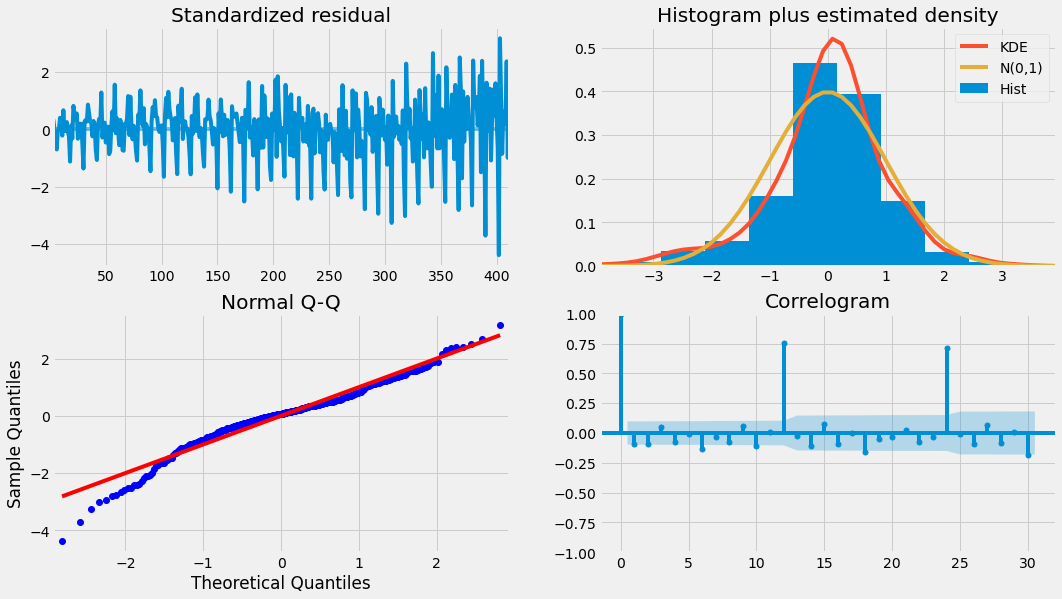

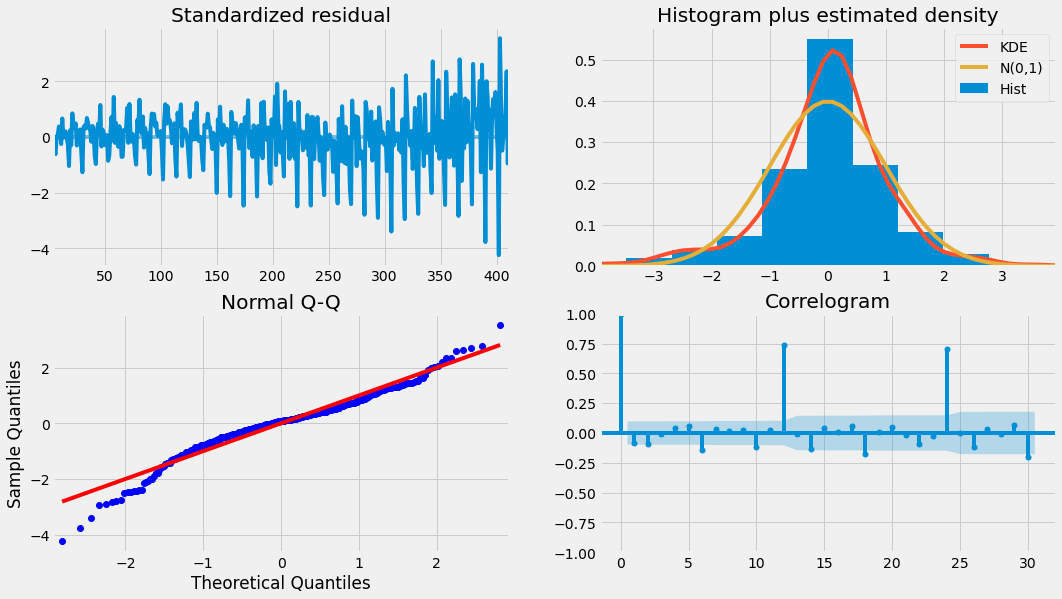

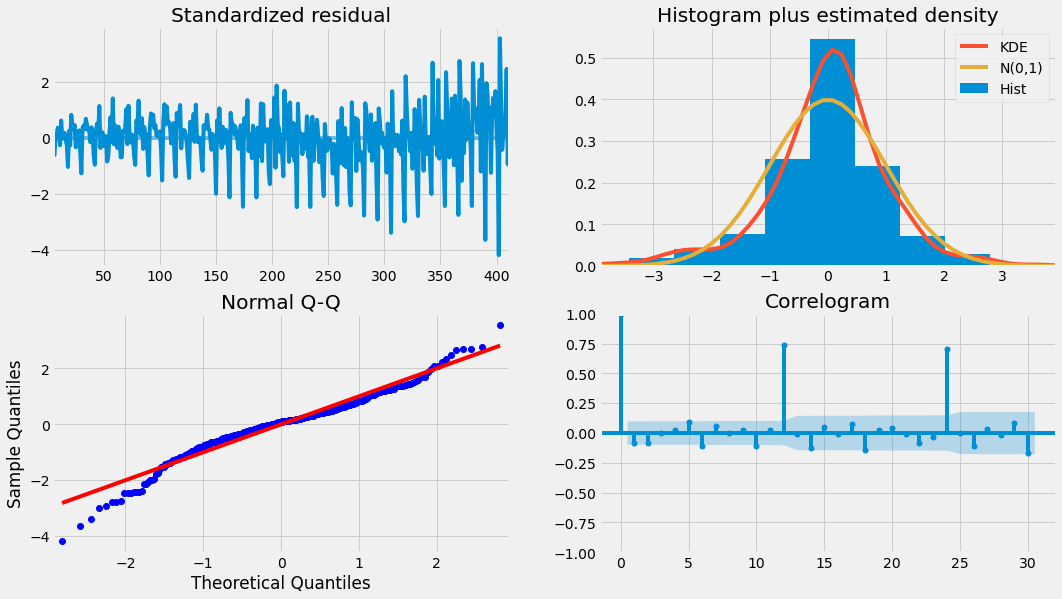

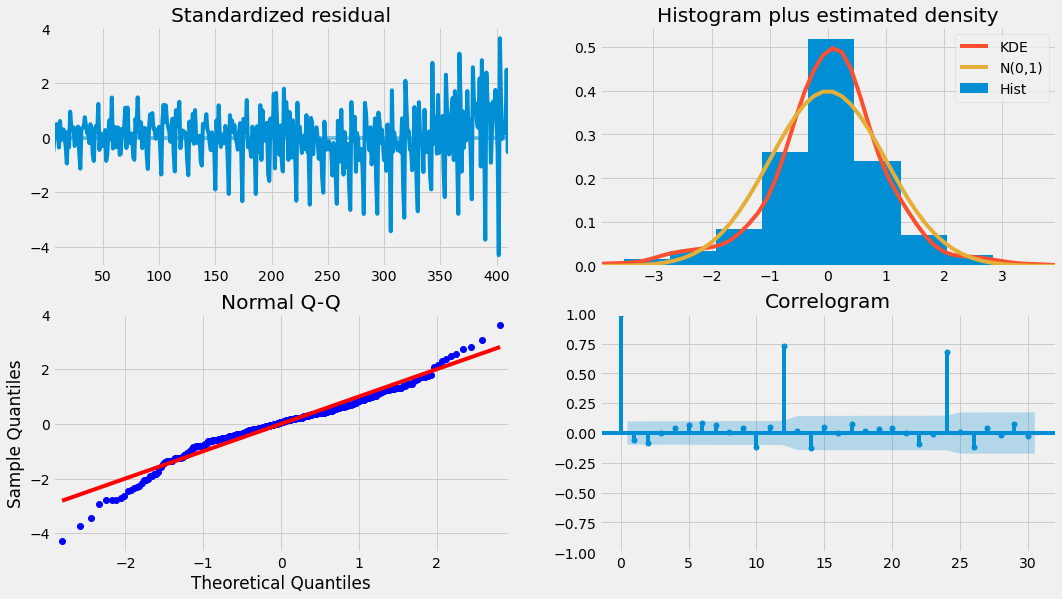

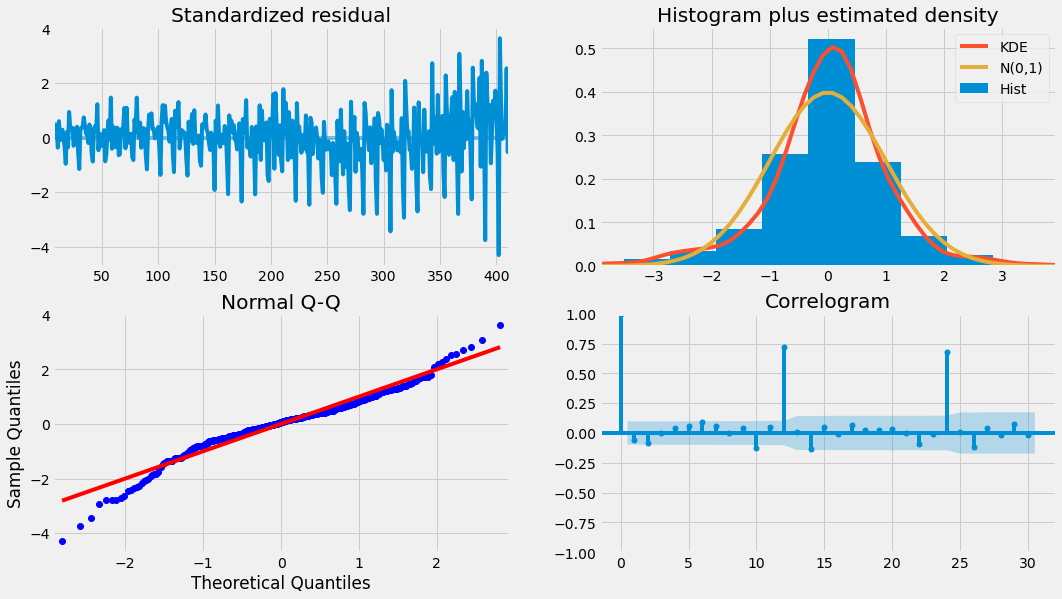

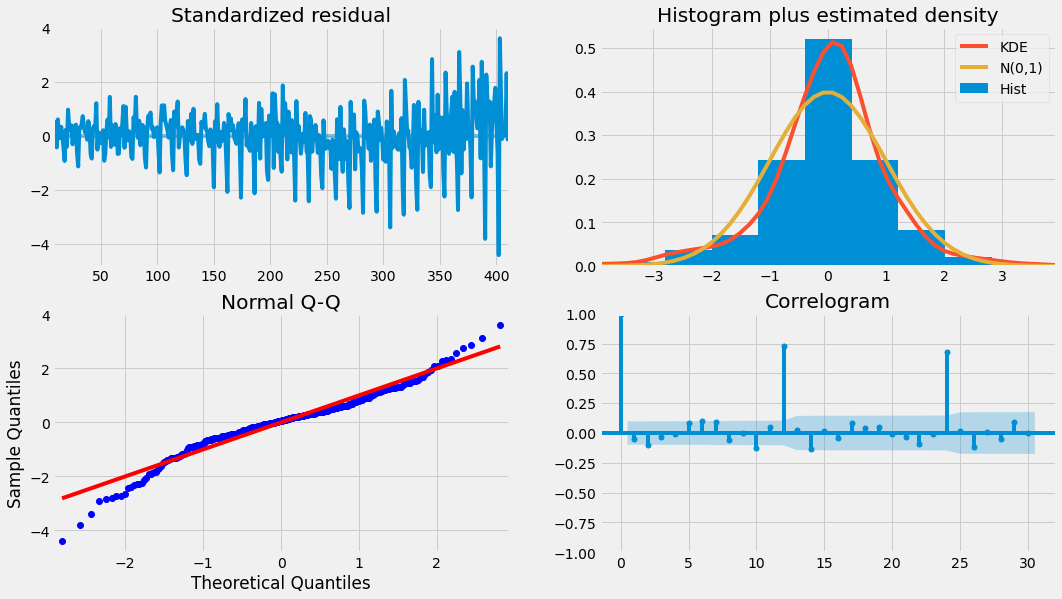

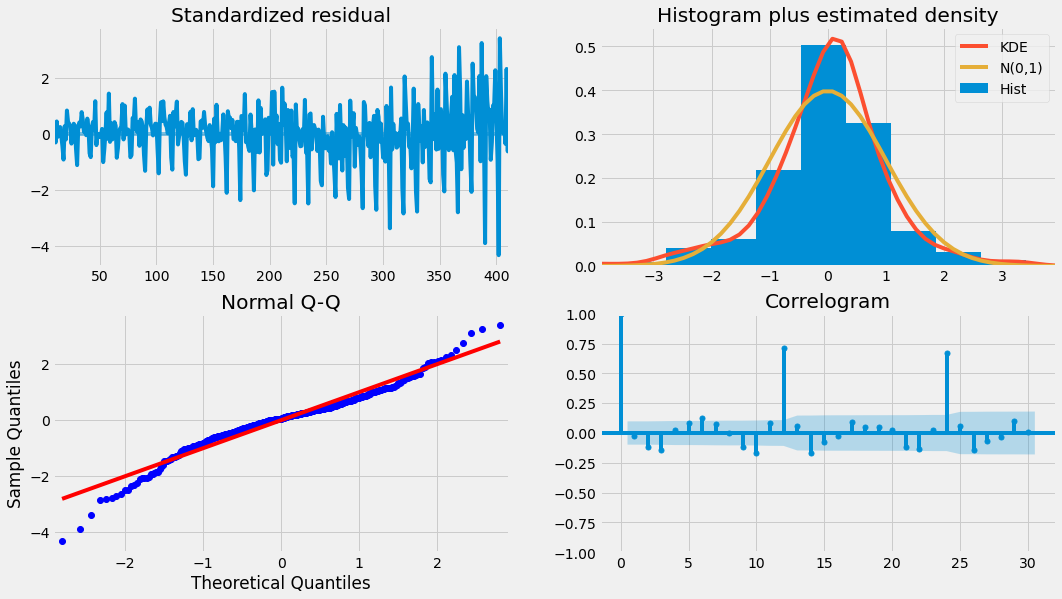

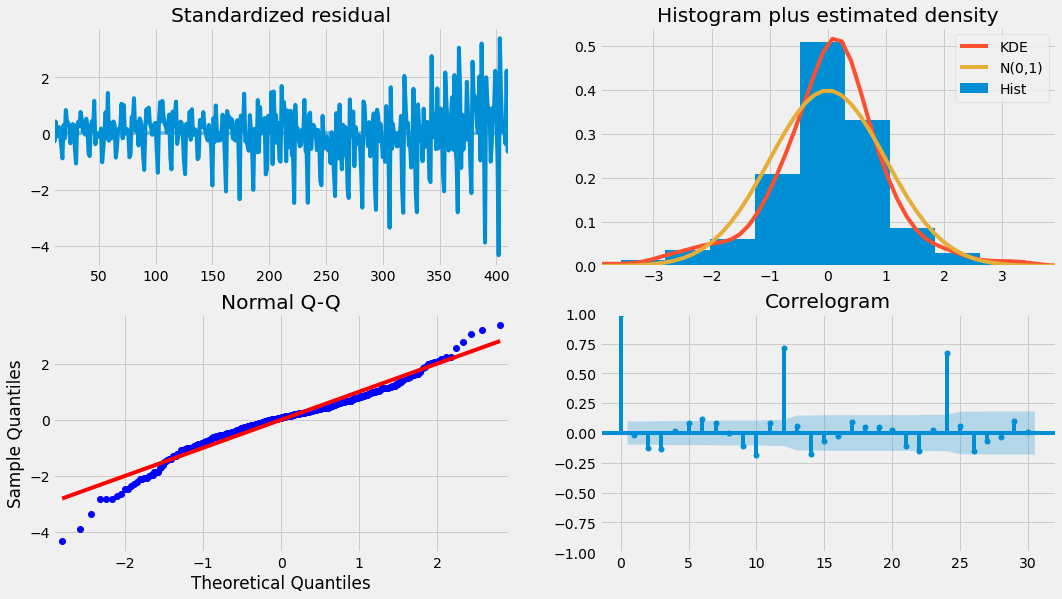

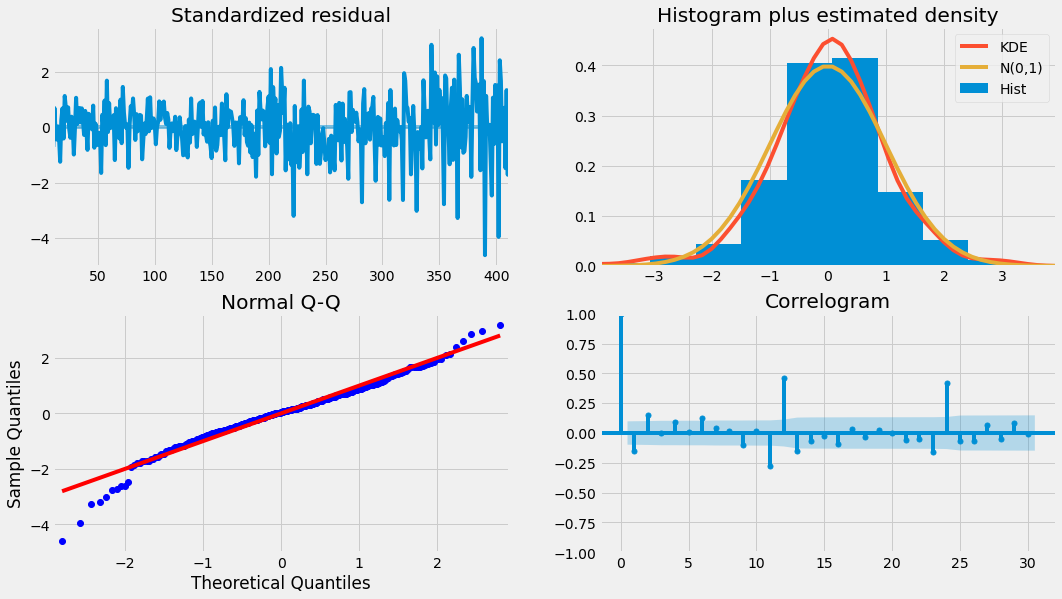

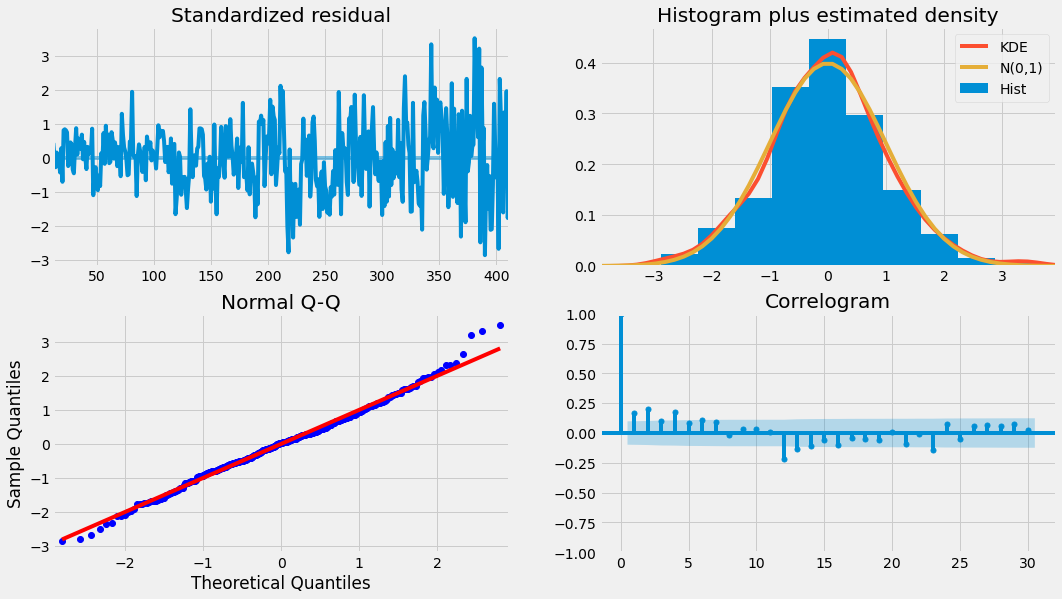

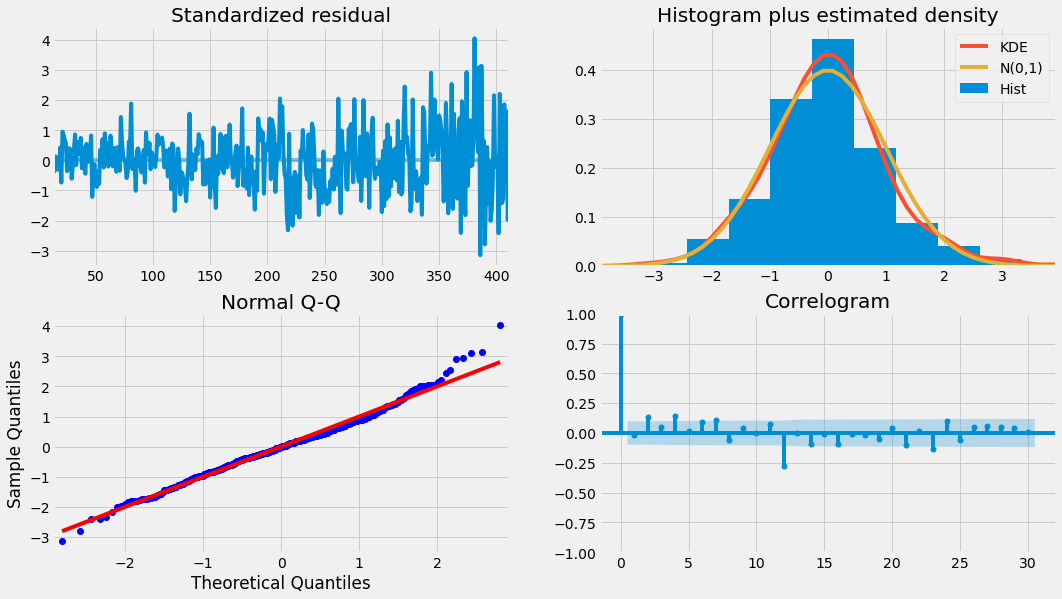

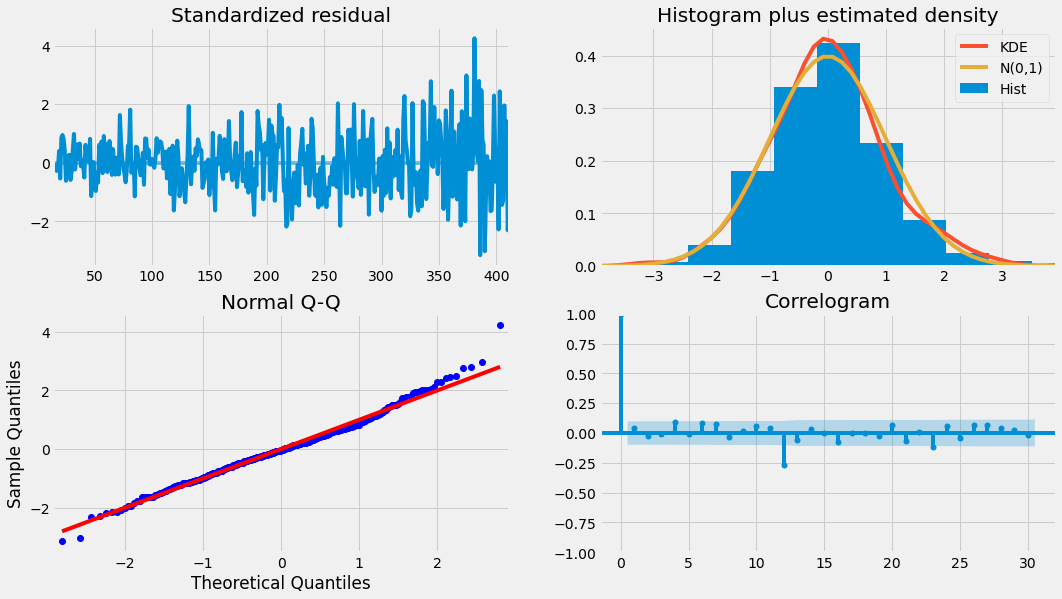

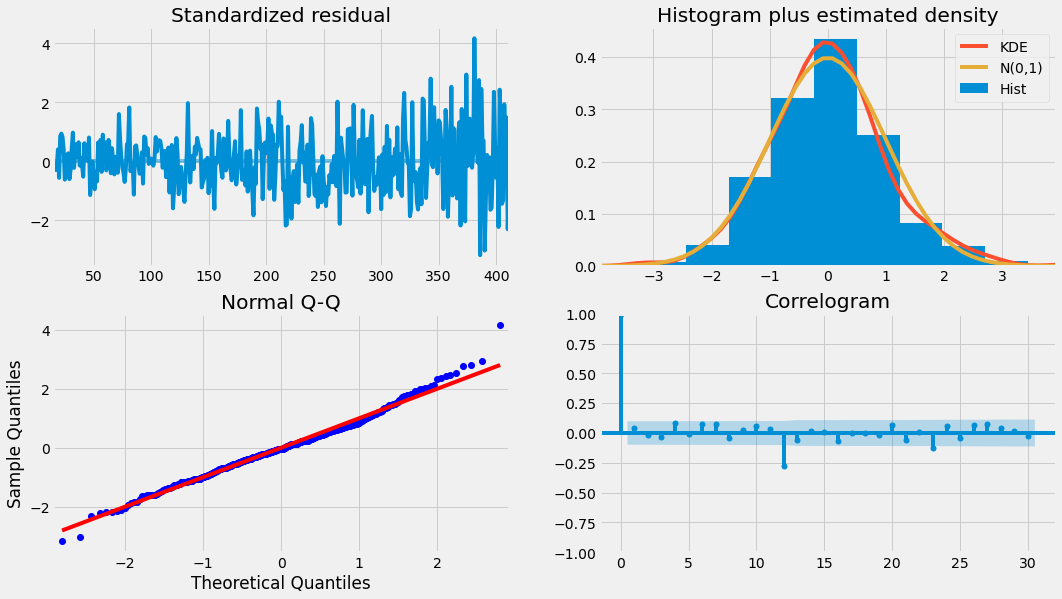

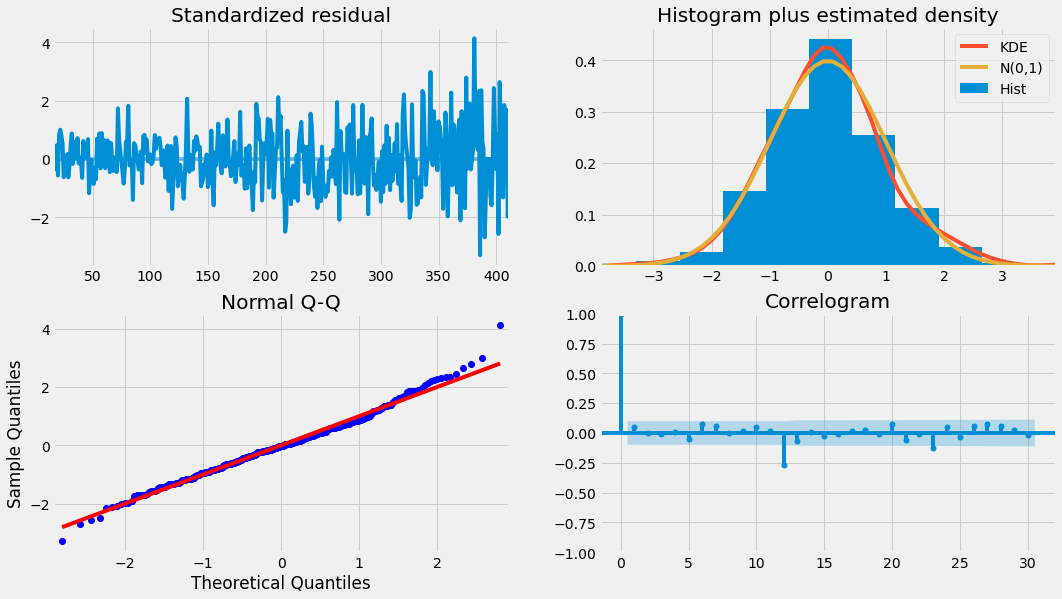

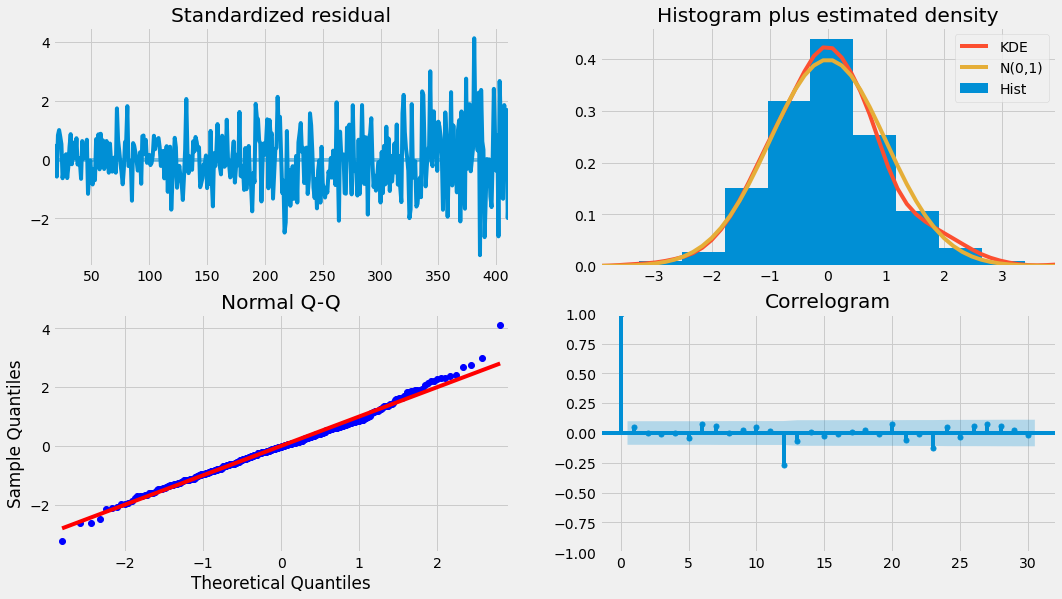

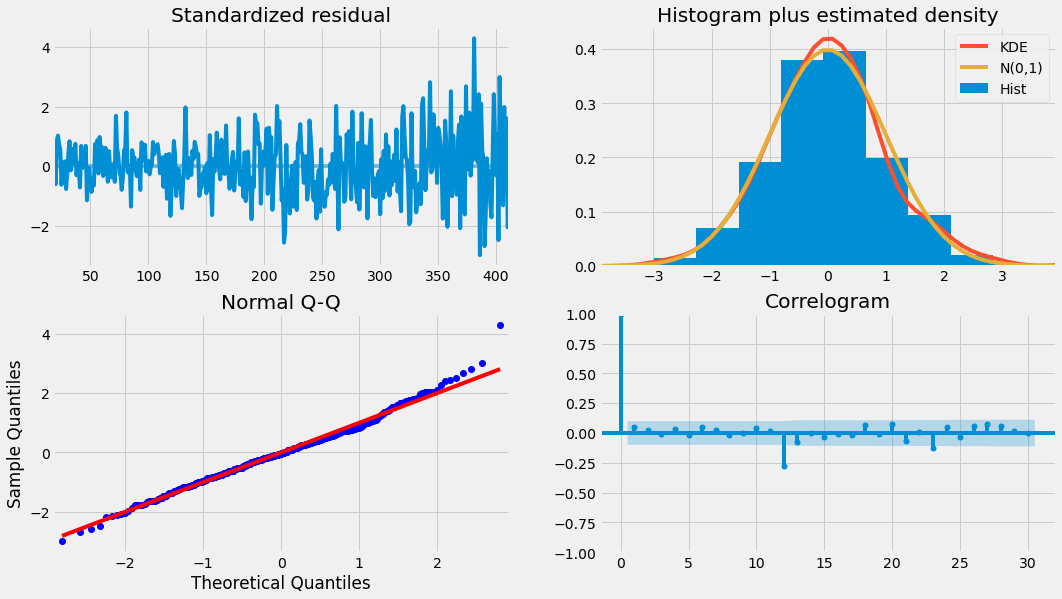

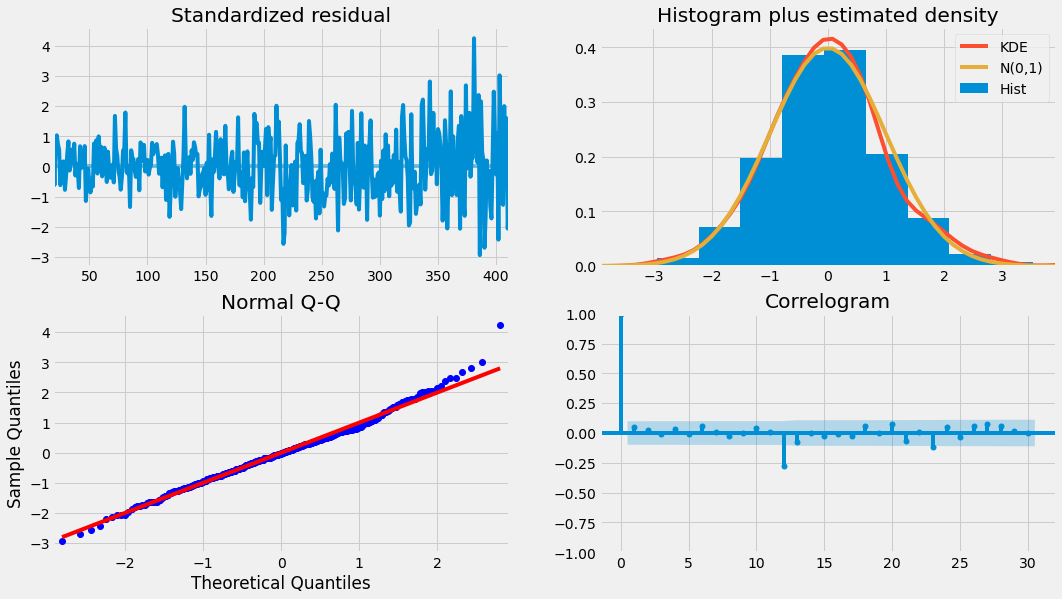

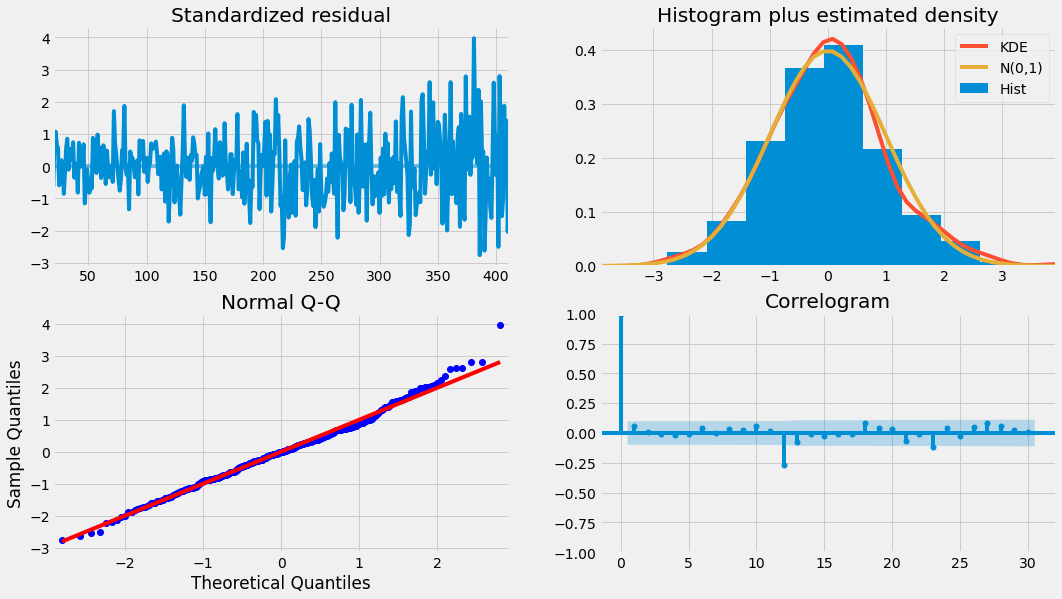

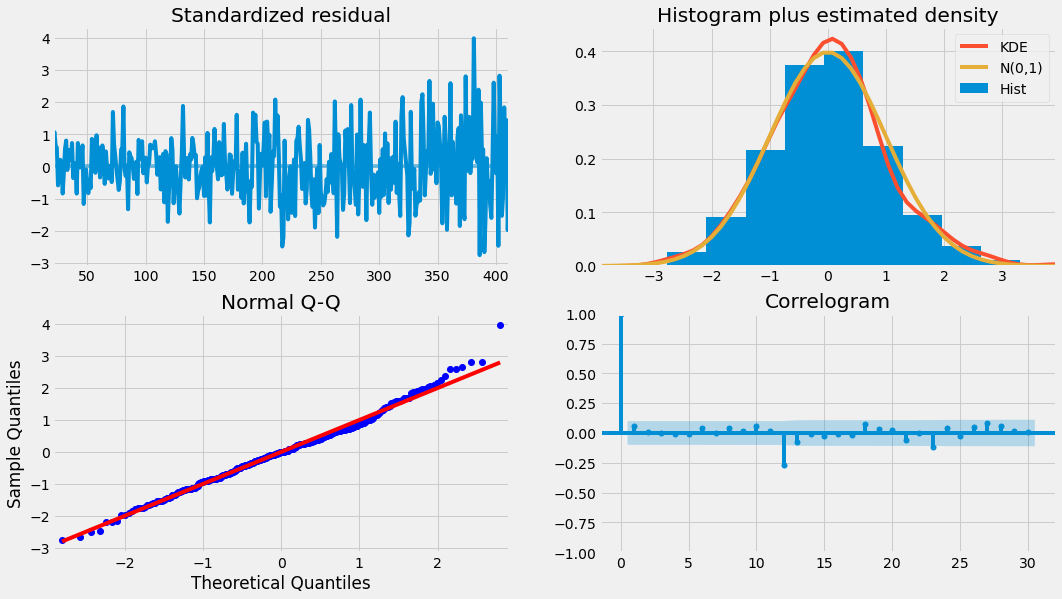

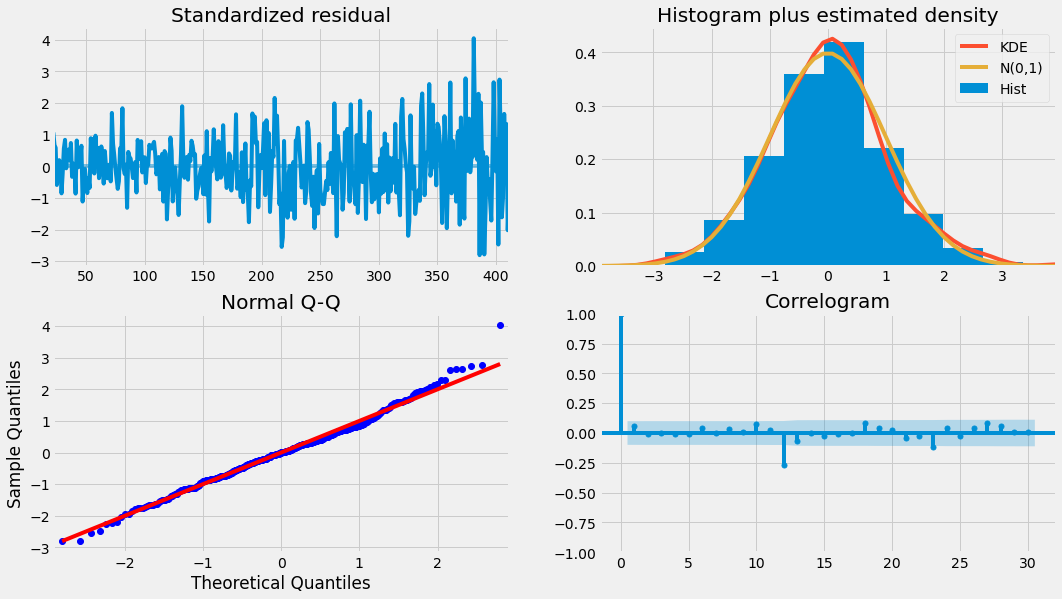

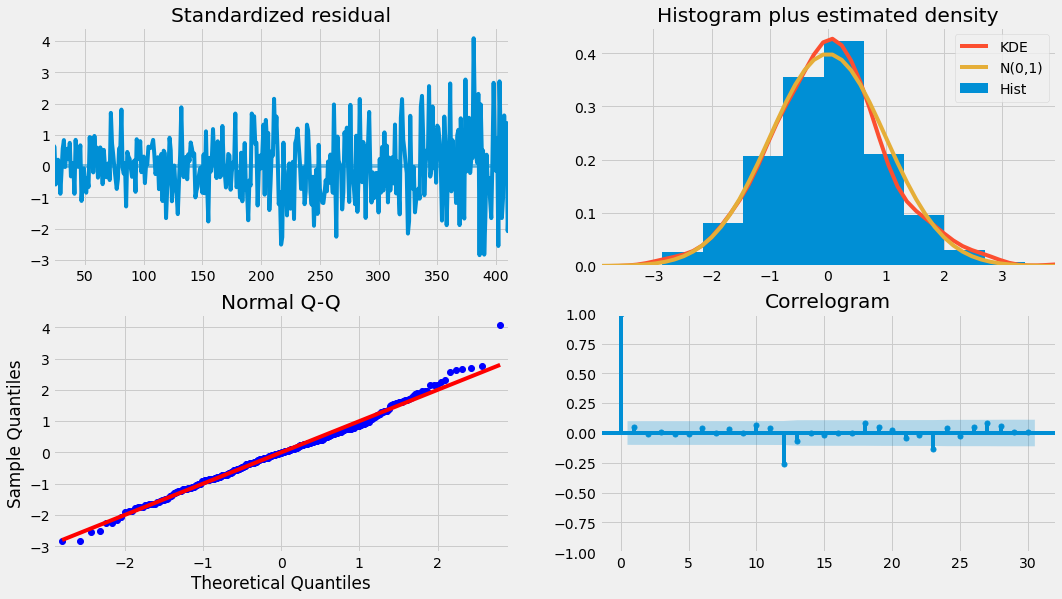

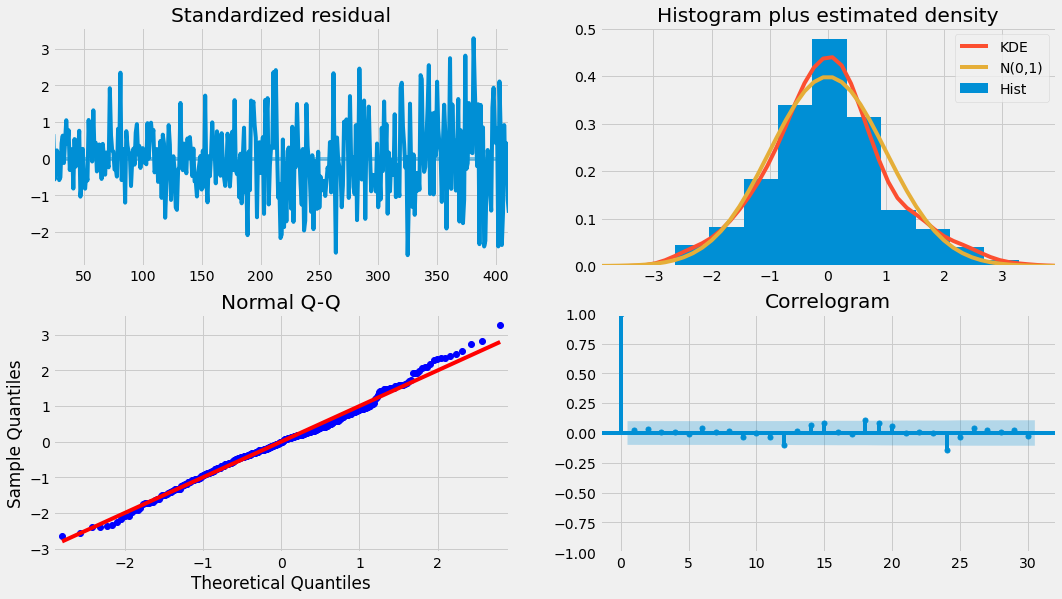

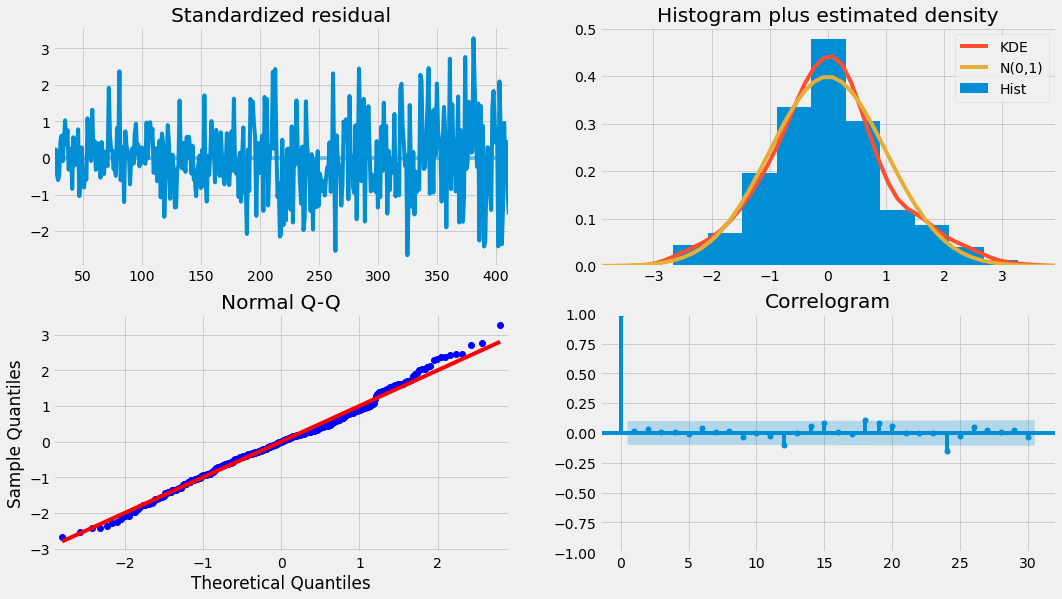

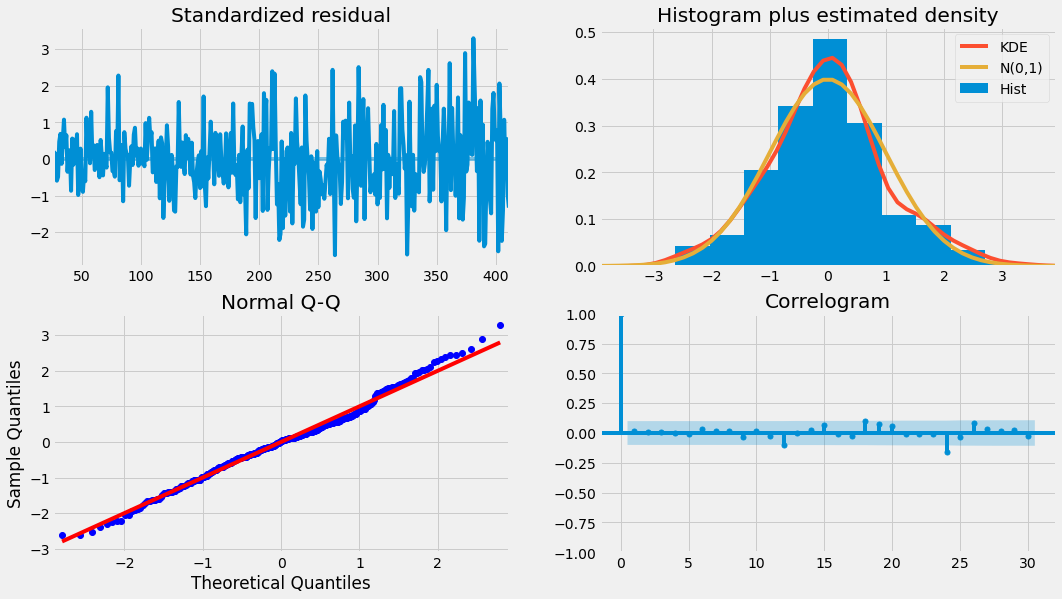

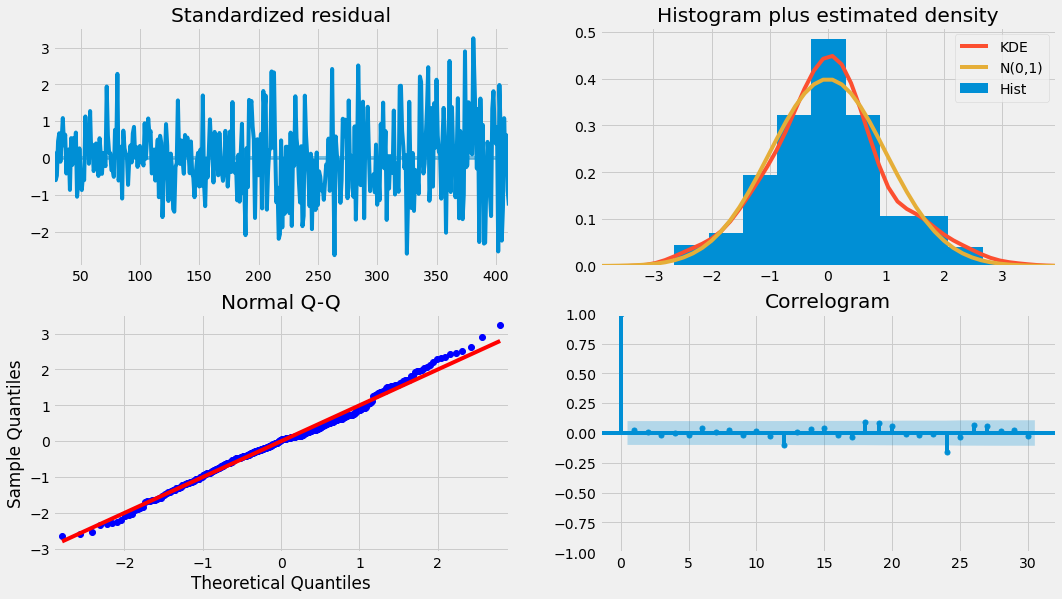

In [104]:
def arx_best_params(p_values=range(28)):
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        order = (p,)
        try:
            metric = arx(*order)
            if metric < best_score:
                best_score, best_cfg = metric, order
            print('ARX%s metric=%.3f' % (order,metric))
        except:
            continue
    print('Best ARX%s metric=%.3f' % (best_cfg, best_score))
    return best_cfg
    
best_cfg = arx_best_params()

                            AutoReg Model Results                             
Dep. Variable:                 Volume   No. Observations:                  412
Model:                  AutoReg-X(12)   Log Likelihood               -3106.070
Method:               Conditional MLE   S.D. of innovations            570.343
Date:                Sat, 09 Oct 2021   AIC                             12.787
Time:                        10:19:59   BIC                             12.977
Sample:                            12   HQIC                            12.863
                                  412                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0066      0.003      2.466      0.014       0.001       0.012
trend          0.6537      0.729      0.897      0.370      -0.774       2.082
Volume.L1      0.1177      0.036      3.224      0.0

9.110936302637262

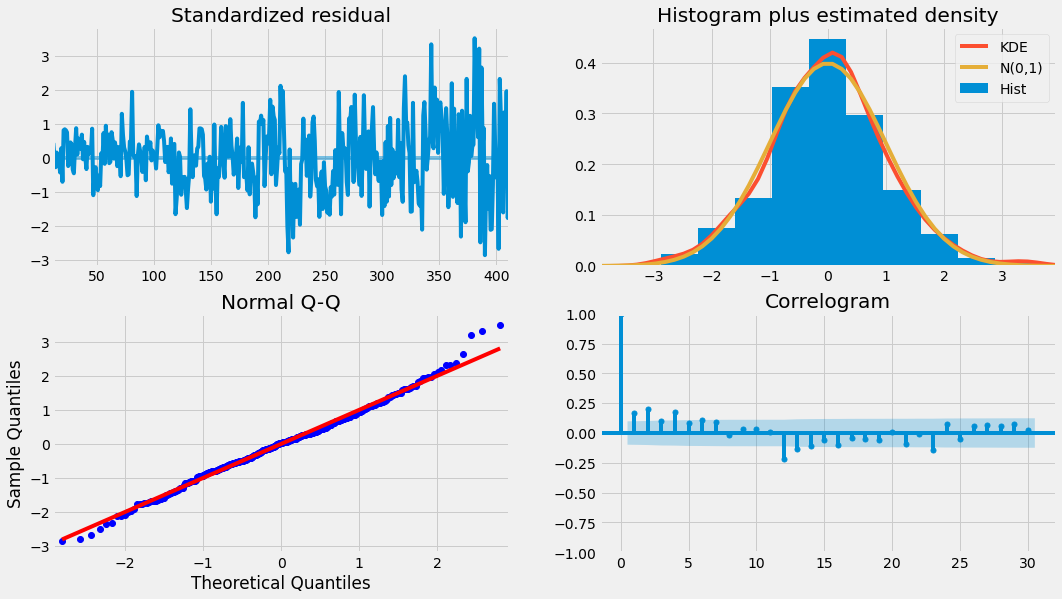

In [105]:
arx(*best_cfg)

In [106]:
y_hat.head()

Month  year  quarter  month  week_day  Volume      Xgboost  \
412 1991-11-30  1991        4     11         5    8162  8771.738281   
413 1991-12-31  1991        4     12         1    8086  7322.548828   
414 1992-01-31  1992        1      1         4    4534  3461.631348   
415 1992-02-29  1992        1      2         5    7356  8411.401367   
416 1992-03-31  1992        1      3         1    8709  8154.386719   

             ARX  
412  9144.636760  
413  6999.259933  
414  4443.720100  
415  8373.349335  
416  9163.274876

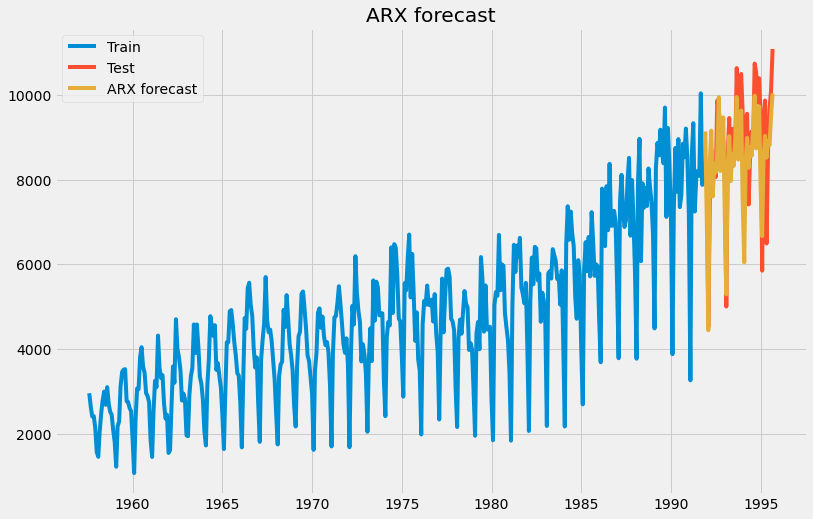

Evaluation metric results:-
MSE is : 936442.1240518038
MAE is : 805.9577687284068
MAPE is : 9.110936302637262
R2 is : 0.5073657026946632
RMSE is : 967.699397567139



In [107]:
plot(method= 'ARX' )

# ARX with ar_select_order

https://www.statsmodels.org/stable/examples/notebooks/generated/autoregressions.html

This cell sets the plotting style, registers pandas date converters for matplotlib
Also, we set the frequency for the time series to “D” (daily) to avoid warnings when using AutoReg.

In [108]:
pd.plotting.register_matplotlib_converters()


                            AutoReg Model Results                             
Dep. Variable:                 Volume   No. Observations:                  412
Model:                  AutoReg-X(13)   Log Likelihood               -3088.092
Method:               Conditional MLE   S.D. of innovations            555.928
Date:                Sat, 09 Oct 2021   AIC                             12.742
Time:                        10:20:00   BIC                             12.941
Sample:                            13   HQIC                            12.821
                                  412                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0082      0.003      3.098      0.002       0.003       0.013
trend          0.9057      0.712      1.271      0.204      -0.491       2.302
Volume.L1      0.2720      0.049      5.606      0.0

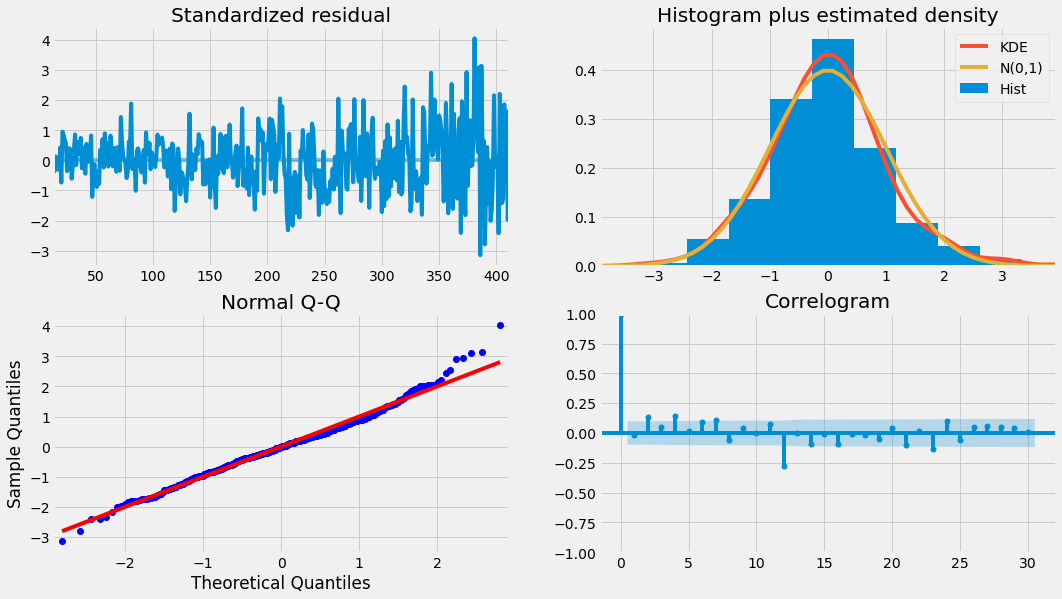

In [109]:
def autoreg_select_order(method= "AutoReg_extra_reggressors"):
    sel = ar_select_order(train[time_dependent_variable],     maxlag= 13, exog= exog_train,
        ic='aic',
        glob=False,
        trend='ct',
        seasonal=False, old_names=False)
    
    res = sel.model.fit()
    diagnostic_plot(res)
    y_hat[method]= res.predict(start=len(train), end=len(train)+len(test)-1, exog_oos= exog_test, dynamic=False)
autoreg_select_order(method= "AutoReg_extra_reggressors")

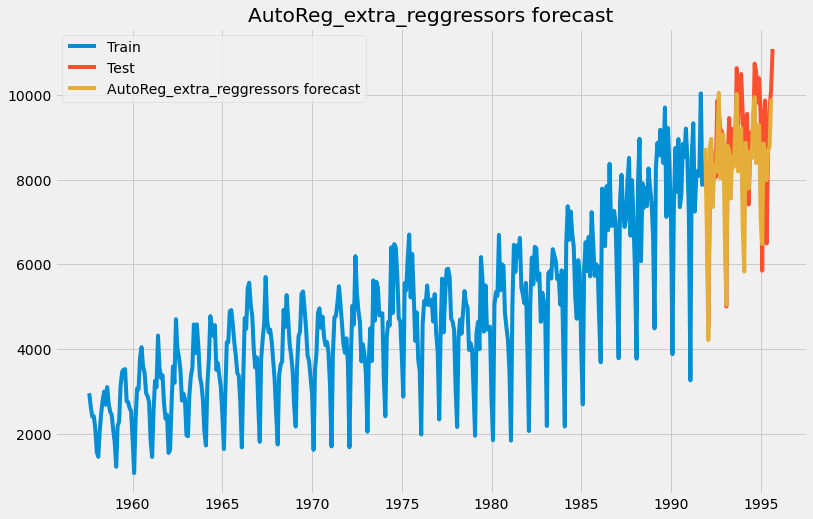

Evaluation metric results:-
MSE is : 1177041.635545468
MAE is : 872.4217327275057
MAPE is : 9.729747479992568
R2 is : 0.3807934690964535
RMSE is : 1084.9154969606932



In [110]:
plot(method= "AutoReg_extra_reggressors")

# ARX with pmdarima library

Performing stepwise search to minimize aic
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=6849.783, Time=1.02 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=7000.540, Time=0.29 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=6849.348, Time=0.58 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=6850.812, Time=0.50 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=6849.348, Time=0.49 sec

Best model:  ARIMA(2,0,0)(0,0,0)[0] intercept
Total fit time: 2.881 seconds





Auto_ARX Model Summary is : 
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  412
Model:               SARIMAX(2, 0, 0)   Log Likelihood               -3415.674
Date:                Sat, 09 Oct 2021   AIC                           6849.348
Time:                        10:20:04   BIC                           6885.537
Sample:                             0   HQIC                          6863.663
                                - 412     

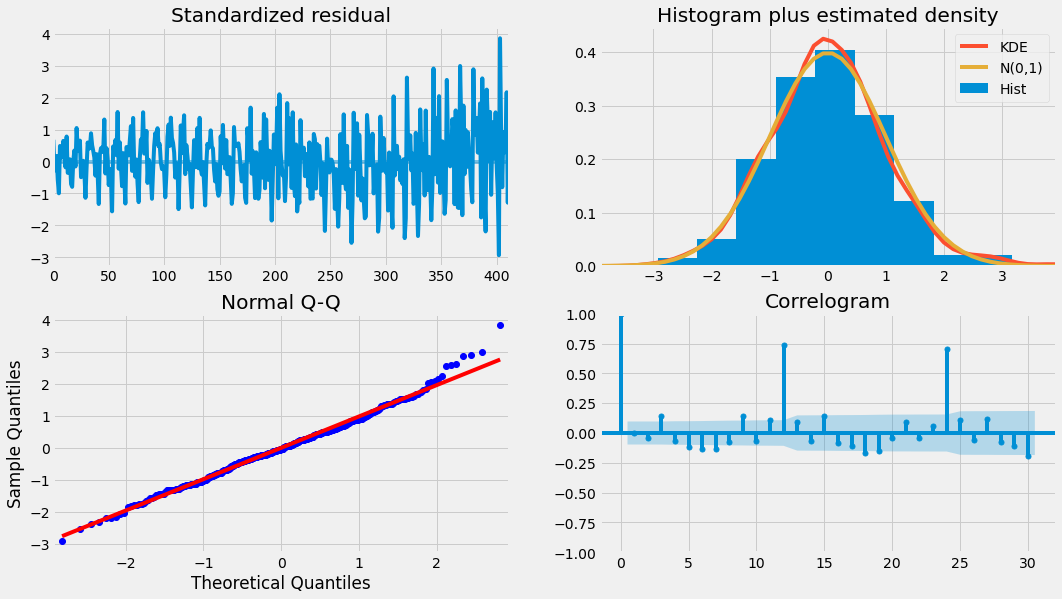

In [111]:
def auto_arx(max_p = 7, method = "Auto_ARX"):
    model = pmd.auto_arima(train[time_dependent_variable], 
                          start_p=1, 
                          start_q=0,
                          d = 0,
                           max_p = max_p, max_q=0,
                           X= exog_train,
                           trend = trend, seasonal=False,
                           trace=True,error_action='ignore',
                          suppress_warnings=True,stepwise=True,
                           n_jobs= -1)

    
    
    print("\n\n\n\n")
    print(method+" Model Summary is : ")
    print(model.summary())
    print("\n\n\n\n")
    
    y_hat.loc[:,method] = model.predict(len(test),X= exog_test)

    print("Test Dataset After Forecast: ")
    print(y_hat.head(5))
    print("\n\n\n\n")
    diagnostic_plot(model)
    

     
    print(metrics_(method))
    
auto_arx()

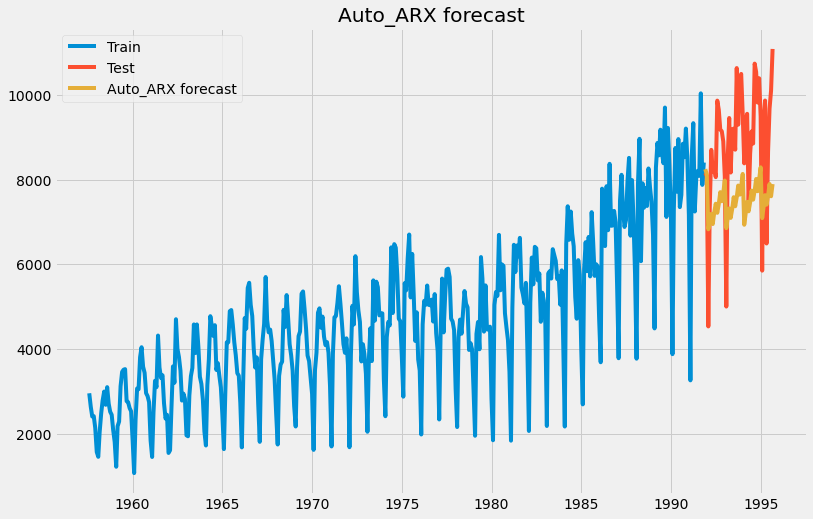

Evaluation metric results:-
MSE is : 3292608.638149652
MAE is : 1630.5159545672561
MAPE is : 18.30952037490189
R2 is : -0.7321432911817671
RMSE is : 1814.5546666192374



In [112]:
plot(method = "Auto_ARX")

# MAX

In [113]:
def ma(MA, method = "MAX"):
    global y_hat
    model = ARMA(train[time_dependent_variable], order=(0, MA), exog= exog_train)
    
    fit1 = model.fit(disp=False)
    
    y_hat[method] = fit1.predict(start=len(train), end=len(train)+len(test)-1, exog= exog_test, dynamic=False)
     
    return metrics_(method)
    
ma(MA = 5, method = "MAX")



18.590279883227623

In [114]:
def ma_best_params(q_values=range(7)):
    best_score, best_cfg = float("inf"), None
#for m in [1, 4,7,12,52]:

    for q in q_values:
        order = (q, )
        try:
            metric = ma(*order)
            if metric < best_score:
                best_score, best_cfg = metric, order
            print('MAX%s metric=%.3f' % (order,metric))
        except:
            continue
    print('Best MAX%s metric=%.3f' % (best_cfg, best_score))
    return best_cfg
    
best_cfg = ma_best_params()

MAX(1,) metric=18.690
MAX(2,) metric=18.524
MAX(3,) metric=18.723
MAX(4,) metric=18.572
MAX(5,) metric=18.590
MAX(6,) metric=17.808
Best MAX(6,) metric=17.808


In [115]:
ma(*best_cfg)

17.808165539758843

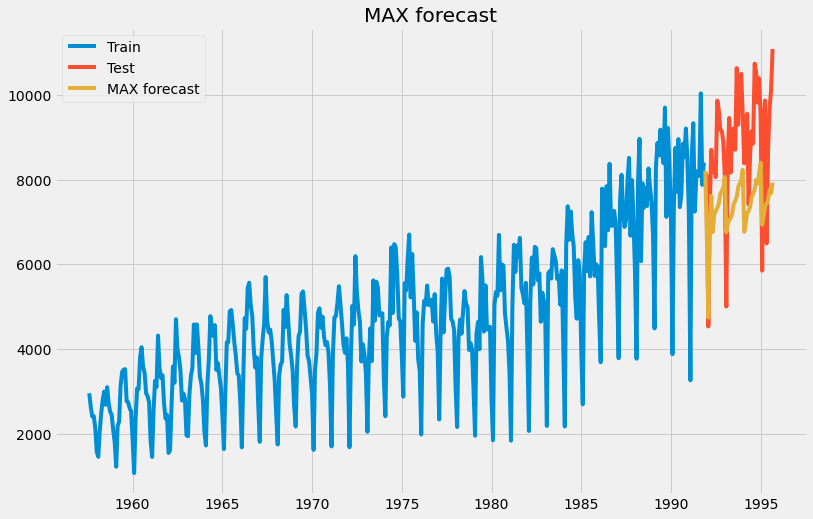

Evaluation metric results:-
MSE is : 3264020.0995646366
MAE is : 1627.2476348979267
MAPE is : 17.808165539758843
R2 is : -0.7171037129151698
RMSE is : 1806.6599291412417



In [116]:
plot(method = "MAX")

# MAX with pmdarima library

In [117]:
def auto_ma(max_q = 40, method = "Auto_MAX"):
    model = pmd.auto_arima(train[time_dependent_variable], 
                          start_p=0, 
                          start_q=7,
                          d = 0,
                           X= exog_train,
                           max_p = 0, max_q=max_q, seasonal=False,trend = trend,
                            trace=True,error_action='ignore',
                          suppress_warnings=True,stepwise=True, 
                          n_jobs= -1)

    
    
    print("\n\n\n\n")
    print(method+" Model Summary is : ")
    print(model.summary())
    print("\n\n\n\n")
    
    y_hat.loc[:,method] = model.predict(len(test), X= exog_test)

    print("Test Dataset After Forecast: ")
    print(y_hat.head(5))
    print("\n\n\n\n")
#     arima_model.plot_diagnostics()
    

    print(metrics_(method))
    
auto_ma()

Performing stepwise search to minimize aic
 ARIMA(0,0,7)(0,0,0)[0]             : AIC=6836.828, Time=1.30 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=7000.540, Time=0.31 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=6864.110, Time=0.77 sec
 ARIMA(0,0,6)(0,0,0)[0]             : AIC=6843.364, Time=1.53 sec
 ARIMA(0,0,8)(0,0,0)[0]             : AIC=6831.511, Time=1.92 sec
 ARIMA(0,0,9)(0,0,0)[0]             : AIC=6856.036, Time=2.18 sec
 ARIMA(0,0,8)(0,0,0)[0] intercept   : AIC=6831.511, Time=2.07 sec

Best model:  ARIMA(0,0,8)(0,0,0)[0]          
Total fit time: 10.088 seconds





Auto_MAX Model Summary is : 
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  412
Model:               SARIMAX(0, 0, 8)   Log Likelihood               -3400.756
Date:                Sat, 09 Oct 2021   AIC                           6831.511
Time:                        10:20:22   BIC                        

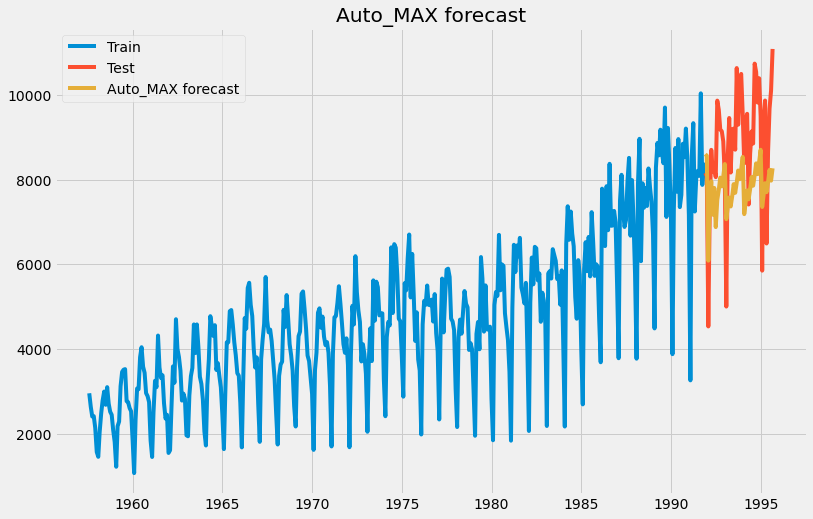

Evaluation metric results:-
MSE is : 2395655.7837908687
MAE is : 1388.7058435505357
MAPE is : 15.703084330646858
R2 is : -0.2602831219583124
RMSE is : 1547.790613678371



In [118]:
plot(method = "Auto_MAX")

# ARMAX

In [119]:
def arma(AR,MA, method = "ARMAX"):
    global y_hat
    model = ARMA(train[time_dependent_variable], order=(AR,MA))
    
    fit1 = model.fit(disp=False)
    print(fit1.summary())
    
    y_hat[method] = fit1.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)
     
    return metrics_(method)
    
arma(AR= 1,MA = 1, method = "ARMAX")

                              ARMA Model Results                              
Dep. Variable:                 Volume   No. Observations:                  412
Model:                     ARMA(1, 1)   Log Likelihood               -3463.980
Method:                       css-mle   S.D. of innovations           1082.888
Date:                Sat, 09 Oct 2021   AIC                           6935.960
Time:                        10:20:22   BIC                           6952.044
Sample:                             0   HQIC                          6942.322
                                                                              
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const         4763.9819    363.913     13.091      0.000    4050.725    5477.239
ar.L1.Volume     0.8923      0.030     30.012      0.000       0.834       0.951
ma.L1.Volume    -0.2512      0.071     -3.53

39.5065481559868

In [120]:
def arma_best_params(p_values=range(7), q_values=range(7)):
    best_score, best_cfg = float("inf"), None
#for m in [1, 4,7,12,52]:
    for p in p_values:
        for q in q_values:
            order = (p, q)
            try:
                metric = arma(*order)
                if metric < best_score:
                    best_score, best_cfg = metric, order
                print('ARMAX%s metric=%.3f' % (order,metric))
            except:
                continue
    print('Best ARMAX%s metric=%.3f' % (best_cfg, best_score))
    return best_cfg
    
best_cfg = arma_best_params()

                              ARMA Model Results                              
Dep. Variable:                 Volume   No. Observations:                  412
Model:                     ARMA(0, 0)   Log Likelihood               -3685.456
Method:                           css   S.D. of innovations           1856.305
Date:                Sat, 09 Oct 2021   AIC                           7374.912
Time:                        10:20:22   BIC                           7382.954
Sample:                             0   HQIC                          7378.093
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       4734.4175     91.454     51.769      0.000    4555.172    4913.663
                              ARMA Model Results                              
Dep. Variable:                 Volume   No. Observat

                              ARMA Model Results                              
Dep. Variable:                 Volume   No. Observations:                  412
Model:                     ARMA(0, 5)   Log Likelihood               -3473.745
Method:                       css-mle   S.D. of innovations           1108.854
Date:                Sat, 09 Oct 2021   AIC                           6961.489
Time:                        10:20:24   BIC                           6989.636
Sample:                             0   HQIC                          6972.623
                                                                              
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const         4742.4059    186.282     25.458      0.000    4377.299    5107.513
ma.L1.Volume     0.7892      0.051     15.577      0.000       0.690       0.888
ma.L2.Volume     0.5677      0.072      7.83

                              ARMA Model Results                              
Dep. Variable:                 Volume   No. Observations:                  412
Model:                     ARMA(1, 3)   Log Likelihood               -3435.984
Method:                       css-mle   S.D. of innovations           1009.083
Date:                Sat, 09 Oct 2021   AIC                           6883.968
Time:                        10:20:26   BIC                           6908.094
Sample:                             0   HQIC                          6893.511
                                                                              
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const         4734.5523   2395.279      1.977      0.048      39.892    9429.213
ar.L1.Volume     0.9991      0.001    770.048      0.000       0.997       1.002
ma.L1.Volume    -0.4339      0.048     -8.99

                              ARMA Model Results                              
Dep. Variable:                 Volume   No. Observations:                  412
Model:                     ARMA(2, 0)   Log Likelihood               -3466.305
Method:                       css-mle   S.D. of innovations           1089.081
Date:                Sat, 09 Oct 2021   AIC                           6940.611
Time:                        10:20:30   BIC                           6956.695
Sample:                             0   HQIC                          6946.973
                                                                              
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const         4758.2309    318.544     14.937      0.000    4133.895    5382.567
ar.L1.Volume     0.7092      0.049     14.521      0.000       0.613       0.805
ar.L2.Volume     0.1246      0.049      2.54

                              ARMA Model Results                              
Dep. Variable:                 Volume   No. Observations:                  412
Model:                     ARMA(2, 5)   Log Likelihood               -3431.962
Method:                       css-mle   S.D. of innovations            985.940
Date:                Sat, 09 Oct 2021   AIC                           6881.924
Time:                        10:20:35   BIC                           6918.113
Sample:                             0   HQIC                          6896.239
                                                                              
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const         4734.4290        nan        nan        nan         nan         nan
ar.L1.Volume     0.0278        nan        nan        nan         nan         nan
ar.L2.Volume     0.9722        nan        na

                              ARMA Model Results                              
Dep. Variable:                 Volume   No. Observations:                  412
Model:                     ARMA(3, 2)   Log Likelihood               -3441.139
Method:                       css-mle   S.D. of innovations                nan
Date:                Sat, 09 Oct 2021   AIC                           6896.278
Time:                        10:20:39   BIC                           6924.425
Sample:                             0   HQIC                          6907.411
                                                                              
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const         4734.4341        nan        nan        nan         nan         nan
ar.L1.Volume     0.4575        nan        nan        nan         nan         nan
ar.L2.Volume     1.0000        nan        na

                              ARMA Model Results                              
Dep. Variable:                 Volume   No. Observations:                  412
Model:                     ARMA(4, 0)   Log Likelihood               -3457.009
Method:                       css-mle   S.D. of innovations           1064.579
Date:                Sat, 09 Oct 2021   AIC                           6926.017
Time:                        10:20:45   BIC                           6950.144
Sample:                             0   HQIC                          6935.560
                                                                              
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const         4771.4053    374.127     12.753      0.000    4038.130    5504.680
ar.L1.Volume     0.6968      0.049     14.179      0.000       0.601       0.793
ar.L2.Volume    -0.0201      0.059     -0.34

                              ARMA Model Results                              
Dep. Variable:                 Volume   No. Observations:                  412
Model:                     ARMA(5, 0)   Log Likelihood               -3455.856
Method:                       css-mle   S.D. of innovations           1061.557
Date:                Sat, 09 Oct 2021   AIC                           6925.713
Time:                        10:20:58   BIC                           6953.860
Sample:                             0   HQIC                          6936.847
                                                                              
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const         4782.8891    406.507     11.766      0.000    3986.151    5579.627
ar.L1.Volume     0.7013      0.049     14.285      0.000       0.605       0.797
ar.L2.Volume    -0.0386      0.060     -0.64

                              ARMA Model Results                              
Dep. Variable:                 Volume   No. Observations:                  412
Model:                     ARMA(5, 5)   Log Likelihood               -3413.317
Method:                       css-mle   S.D. of innovations            952.076
Date:                Sat, 09 Oct 2021   AIC                           6850.633
Time:                        10:21:03   BIC                           6898.885
Sample:                             0   HQIC                          6869.719
                                                                              
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const         4734.4427   2348.296      2.016      0.044     131.867    9337.019
ar.L1.Volume     0.6699      0.111      6.061      0.000       0.453       0.887
ar.L2.Volume    -0.4323      0.176     -2.45

                              ARMA Model Results                              
Dep. Variable:                 Volume   No. Observations:                  412
Model:                     ARMA(6, 4)   Log Likelihood               -3379.640
Method:                       css-mle   S.D. of innovations            875.561
Date:                Sat, 09 Oct 2021   AIC                           6783.280
Time:                        10:21:11   BIC                           6831.532
Sample:                             0   HQIC                          6802.366
                                                                              
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const         7130.5087        nan        nan        nan         nan         nan
ar.L1.Volume     1.1441      0.062     18.352      0.000       1.022       1.266
ar.L2.Volume    -0.0276      0.104     -0.26

In [121]:
arma(*best_cfg)

                              ARMA Model Results                              
Dep. Variable:                 Volume   No. Observations:                  412
Model:                     ARMA(5, 4)   Log Likelihood               -3385.485
Method:                       css-mle   S.D. of innovations            855.524
Date:                Sat, 09 Oct 2021   AIC                           6792.970
Time:                        10:21:20   BIC                           6837.201
Sample:                             0   HQIC                          6810.466
                                                                              
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const         4734.4197        nan        nan        nan         nan         nan
ar.L1.Volume     1.5145        nan        nan        nan         nan         nan
ar.L2.Volume    -0.7645        nan        na

12.16892274506314

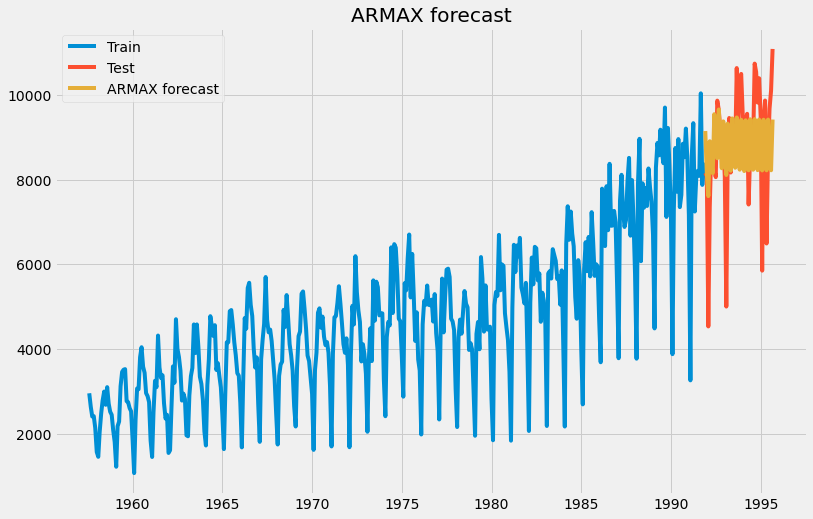

Evaluation metric results:-
MSE is : 1472756.5938778815
MAE is : 962.2041781687824
MAPE is : 12.16892274506314
R2 is : 0.225226641249753
RMSE is : 1213.5718330110838



In [122]:
plot(method = "ARMAX")

# ARMAX with pmdarima

In [123]:
def auto_arma(max_p = 7, max_q= 7, method = "Auto_ARMAX"):
    model = pmd.auto_arima(train[time_dependent_variable], 
                          start_p=7, 
                          start_q=1,
                           d = 0,
                           max_p = max_p, max_q = max_q,
                           seasonal=False, trend = trend,
                           trace=True,error_action='ignore',
                          suppress_warnings=True,stepwise=True,
                          n_jobs= -1)

    
    
    print("\n\n\n\n")
    print(method+" Model Summary is : ")
    print(model.summary())
    print("\n\n\n\n")
    
    y_hat.loc[:,method] = model.predict(len(test))

    print("Test Dataset After Forecast: ")
    print(y_hat.head(5))
    print("\n\n\n\n")
#     arima_model.plot_diagnostics()
    

    print(metrics_(method))
    
auto_arma()

Performing stepwise search to minimize aic
 ARIMA(7,0,1)(0,0,0)[0]             : AIC=6859.126, Time=1.06 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=6998.822, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=6872.676, Time=0.14 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=6882.046, Time=0.33 sec
 ARIMA(6,0,1)(0,0,0)[0]             : AIC=6857.383, Time=0.95 sec
 ARIMA(5,0,1)(0,0,0)[0]             : AIC=6861.695, Time=0.56 sec
 ARIMA(6,0,0)(0,0,0)[0]             : AIC=6855.537, Time=0.70 sec
 ARIMA(5,0,0)(0,0,0)[0]             : AIC=6859.901, Time=0.31 sec
 ARIMA(7,0,0)(0,0,0)[0]             : AIC=6857.132, Time=0.72 sec
 ARIMA(6,0,0)(0,0,0)[0] intercept   : AIC=6855.537, Time=0.77 sec

Best model:  ARIMA(6,0,0)(0,0,0)[0]          
Total fit time: 5.591 seconds





Auto_ARMAX Model Summary is : 
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  412
Model:               SARIM

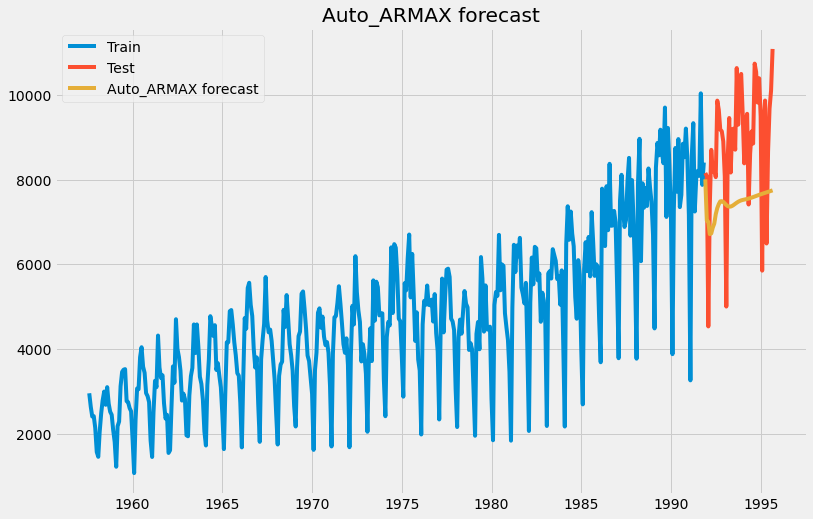

Evaluation metric results:-
MSE is : 3734771.599617557
MAE is : 1767.6622100726497
MAPE is : 20.06486083231426
R2 is : -0.9647520496117095
RMSE is : 1932.555717079732



In [124]:
plot(method = "Auto_ARMAX")

# ARIMAX

In [125]:
def arima(p,d,q, method = 'ARIMAX'):

    
    model = ARIMA(train[time_dependent_variable], exog=exog_train, order=(p,d,q))
    fit1 = model.fit()
    print(fit1.summary())
    y_hat[method] = fit1.predict(start=len(train), end=len(train)+len(test)-1, exog=exog_test, dynamic=False, typ='levels')
   
    return metrics_(method)

arima(1, 1, 1)

                             ARIMA Model Results                              
Dep. Variable:               D.Volume   No. Observations:                  411
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -3327.825
Method:                       css-mle   S.D. of innovations            792.807
Date:                Sat, 09 Oct 2021   AIC                           6671.649
Time:                        10:21:27   BIC                           6703.798
Sample:                             1   HQIC                          6684.367
                                                                              
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const           -523.4237    693.642     -0.755      0.450   -1882.938     836.090
year               0.7608      0.346      2.197      0.028       0.082       1.440
quarter         -295.2143    245.455

13.995346894400363

In [126]:
def arima_best_params(p_values=range(7), d_values=range(2), q_values=range(7)):
    best_score, best_cfg = float("inf"), None
#for m in [1, 4,7,12,52]:
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p, d, q)
                try:
                    metric = arima(*order)
                    if metric < best_score:
                        best_score, best_cfg = metric, order
                    print('ARIMA%s metric=%.3f' % (order,metric))
                except:
                    continue
    print('Best ARIMA%s metric=%.3f' % (best_cfg, best_score))
    return best_cfg
    
best_cfg = arima_best_params()

                              ARMA Model Results                              
Dep. Variable:                 Volume   No. Observations:                  412
Model:                     ARMA(0, 0)   Log Likelihood               -3493.233
Method:                           css   S.D. of innovations           1164.191
Date:                Sat, 09 Oct 2021   AIC                           6998.466
Time:                        10:21:28   BIC                           7022.592
Sample:                             0   HQIC                          7008.009
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const      -2.818e+05   1.14e+04    -24.729      0.000   -3.04e+05    -2.6e+05
year         145.1469      5.771     25.153      0.000     133.837     156.457
quarter     -460.5422    216.601     -2.126      0.0

                              ARMA Model Results                              
Dep. Variable:                 Volume   No. Observations:                  412
Model:                     ARMA(0, 5)   Log Likelihood               -3406.042
Method:                       css-mle   S.D. of innovations            941.434
Date:                Sat, 09 Oct 2021   AIC                           6834.083
Time:                        10:21:31   BIC                           6878.315
Sample:                             0   HQIC                          6851.579
                                                                              
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const        -2.818e+05   2.29e+04    -12.324      0.000   -3.27e+05   -2.37e+05
year           144.8383     11.581     12.507      0.000     122.140     167.536
quarter       -228.2678    156.456     -1.45

                             ARIMA Model Results                              
Dep. Variable:               D.Volume   No. Observations:                  411
Model:                 ARIMA(0, 1, 2)   Log Likelihood               -3327.473
Method:                       css-mle   S.D. of innovations            792.108
Date:                Sat, 09 Oct 2021   AIC                           6670.945
Time:                        10:21:36   BIC                           6703.094
Sample:                             1   HQIC                          6683.663
                                                                              
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const           -524.0688    706.600     -0.742      0.458   -1908.980     860.842
year               0.7631      0.353      2.161      0.031       0.071       1.455
quarter         -295.1105    250.059

                             ARIMA Model Results                              
Dep. Variable:               D.Volume   No. Observations:                  411
Model:                 ARIMA(0, 1, 6)   Log Likelihood               -3314.655
Method:                       css-mle   S.D. of innovations            767.655
Date:                Sat, 09 Oct 2021   AIC                           6653.310
Time:                        10:21:54   BIC                           6701.533
Sample:                             1   HQIC                          6672.386
                                                                              
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const           -521.7127    756.076     -0.690      0.490   -2003.595     960.170
year               0.7638      0.379      2.015      0.044       0.021       1.507
quarter         -296.8223    272.625

                              ARMA Model Results                              
Dep. Variable:                 Volume   No. Observations:                  412
Model:                     ARMA(1, 3)   Log Likelihood               -3407.350
Method:                       css-mle   S.D. of innovations            944.477
Date:                Sat, 09 Oct 2021   AIC                           6834.699
Time:                        10:21:57   BIC                           6874.910
Sample:                             0   HQIC                          6850.605
                                                                              
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const        -2.818e+05   2.22e+04    -12.687      0.000   -3.25e+05   -2.38e+05
year           144.8613     11.250     12.877      0.000     122.812     166.911
quarter       -248.8549    155.532     -1.60

                             ARIMA Model Results                              
Dep. Variable:               D.Volume   No. Observations:                  411
Model:                 ARIMA(1, 1, 0)   Log Likelihood               -3421.610
Method:                       css-mle   S.D. of innovations            998.151
Date:                Sat, 09 Oct 2021   AIC                           6857.221
Time:                        10:22:09   BIC                           6885.351
Sample:                             1   HQIC                          6868.349
                                                                              
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const           -524.2039   6916.821     -0.076      0.940   -1.41e+04     1.3e+04
year               0.7615      3.502      0.217      0.828      -6.102       7.625
quarter         -312.4766    211.018

                             ARIMA Model Results                              
Dep. Variable:               D.Volume   No. Observations:                  411
Model:                 ARIMA(1, 1, 4)   Log Likelihood               -3313.761
Method:                       css-mle   S.D. of innovations            765.170
Date:                Sat, 09 Oct 2021   AIC                           6649.523
Time:                        10:22:15   BIC                           6693.727
Sample:                             1   HQIC                          6667.009
                                                                              
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const           -523.9247    910.154     -0.576      0.565   -2307.793    1259.944
year               0.7756      0.458      1.694      0.090      -0.122       1.673
quarter         -295.4335    271.781

                              ARMA Model Results                              
Dep. Variable:                 Volume   No. Observations:                  412
Model:                     ARMA(2, 0)   Log Likelihood               -3413.678
Method:                       css-mle   S.D. of innovations            959.248
Date:                Sat, 09 Oct 2021   AIC                           6843.356
Time:                        10:22:29   BIC                           6875.524
Sample:                             0   HQIC                          6856.080
                                                                              
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const        -2.818e+05   2.06e+04    -13.657      0.000   -3.22e+05   -2.41e+05
year           144.8486     10.451     13.860      0.000     124.366     165.331
quarter       -244.3750    134.899     -1.81

                              ARMA Model Results                              
Dep. Variable:                 Volume   No. Observations:                  412
Model:                     ARMA(2, 4)   Log Likelihood               -3343.611
Method:                       css-mle   S.D. of innovations            804.590
Date:                Sat, 09 Oct 2021   AIC                           6711.221
Time:                        10:22:35   BIC                           6759.474
Sample:                             0   HQIC                          6730.308
                                                                              
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const        -2.818e+05    1.2e+04    -23.539      0.000   -3.05e+05   -2.58e+05
year           144.6617      6.063     23.860      0.000     132.779     156.545
quarter        -61.1983    146.160     -0.41

                             ARIMA Model Results                              
Dep. Variable:               D.Volume   No. Observations:                  411
Model:                 ARIMA(2, 1, 3)   Log Likelihood               -3309.327
Method:                       css-mle   S.D. of innovations            756.118
Date:                Sat, 09 Oct 2021   AIC                           6640.655
Time:                        10:22:43   BIC                           6684.859
Sample:                             1   HQIC                          6658.142
                                                                              
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const           -524.0274    681.245     -0.769      0.442   -1859.242     811.188
year               0.7511      0.337      2.229      0.026       0.091       1.412
quarter         -293.7175    354.174

                             ARIMA Model Results                              
Dep. Variable:               D.Volume   No. Observations:                  411
Model:                 ARIMA(2, 1, 6)   Log Likelihood               -3300.808
Method:                       css-mle   S.D. of innovations            736.849
Date:                Sat, 09 Oct 2021   AIC                           6629.615
Time:                        10:23:00   BIC                           6685.875
Sample:                             1   HQIC                          6651.871
                                                                              
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const           -524.1058    759.942     -0.690      0.490   -2013.565     965.353
year               0.7501      0.380      1.972      0.049       0.005       1.496
quarter         -296.1955    284.821

                              ARMA Model Results                              
Dep. Variable:                 Volume   No. Observations:                  412
Model:                     ARMA(3, 3)   Log Likelihood               -3354.703
Method:                       css-mle   S.D. of innovations                nan
Date:                Sat, 09 Oct 2021   AIC                           6733.406
Time:                        10:23:06   BIC                           6781.658
Sample:                             0   HQIC                          6752.492
                                                                              
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const        -2.818e+05    1.2e+04    -23.509      0.000   -3.05e+05   -2.58e+05
year           144.6899      6.071     23.834      0.000     132.792     156.588
quarter       -126.6324    137.497     -0.92

                             ARIMA Model Results                              
Dep. Variable:               D.Volume   No. Observations:                  411
Model:                 ARIMA(3, 1, 2)   Log Likelihood               -3316.265
Method:                       css-mle   S.D. of innovations            770.690
Date:                Sat, 09 Oct 2021   AIC                           6654.529
Time:                        10:23:18   BIC                           6698.734
Sample:                             1   HQIC                          6672.016
                                                                              
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const           -523.8782    761.477     -0.688      0.491   -2016.345     968.589
year               0.7642      0.381      2.006      0.045       0.017       1.511
quarter         -294.9253    286.988

                              ARMA Model Results                              
Dep. Variable:                 Volume   No. Observations:                  412
Model:                     ARMA(4, 0)   Log Likelihood               -3401.559
Method:                       css-mle   S.D. of innovations            931.129
Date:                Sat, 09 Oct 2021   AIC                           6823.118
Time:                        10:23:35   BIC                           6863.329
Sample:                             0   HQIC                          6839.024
                                                                              
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const        -2.818e+05   1.68e+04    -16.764      0.000   -3.15e+05   -2.49e+05
year           144.7713      8.514     17.004      0.000     128.085     161.458
quarter       -177.7838    165.352     -1.07

                              ARMA Model Results                              
Dep. Variable:                 Volume   No. Observations:                  412
Model:                     ARMA(4, 4)   Log Likelihood               -3337.779
Method:                       css-mle   S.D. of innovations            792.656
Date:                Sat, 09 Oct 2021   AIC                           6703.557
Time:                        10:23:46   BIC                           6759.852
Sample:                             0   HQIC                          6725.825
                                                                              
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const        -2.818e+05   1.08e+04    -26.028      0.000   -3.03e+05   -2.61e+05
year           144.6338      5.483     26.380      0.000     133.888     155.380
quarter        -69.2734    193.384     -0.35

                              ARMA Model Results                              
Dep. Variable:                 Volume   No. Observations:                  412
Model:                     ARMA(5, 0)   Log Likelihood               -3398.208
Method:                       css-mle   S.D. of innovations            923.479
Date:                Sat, 09 Oct 2021   AIC                           6818.416
Time:                        10:24:02   BIC                           6862.648
Sample:                             0   HQIC                          6835.912
                                                                              
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const        -2.818e+05   1.48e+04    -19.029      0.000   -3.11e+05   -2.53e+05
year           144.7443      7.500     19.298      0.000     130.044     159.445
quarter       -165.5823    155.174     -1.06

                              ARMA Model Results                              
Dep. Variable:                 Volume   No. Observations:                  412
Model:                     ARMA(5, 4)   Log Likelihood               -3328.572
Method:                       css-mle   S.D. of innovations            774.867
Date:                Sat, 09 Oct 2021   AIC                           6687.145
Time:                        10:24:18   BIC                           6747.460
Sample:                             0   HQIC                          6711.003
                                                                              
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const        -2.818e+05   1.27e+04    -22.119      0.000   -3.07e+05   -2.57e+05
year           144.6490      6.452     22.420      0.000     132.004     157.294
quarter        -72.2566    221.494     -0.32

                             ARIMA Model Results                              
Dep. Variable:               D.Volume   No. Observations:                  411
Model:                 ARIMA(5, 1, 0)   Log Likelihood               -3331.611
Method:                       css-mle   S.D. of innovations            800.652
Date:                Sat, 09 Oct 2021   AIC                           6685.222
Time:                        10:25:01   BIC                           6729.426
Sample:                             1   HQIC                          6702.709
                                                                              
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const           -511.8544   2004.822     -0.255      0.798   -4441.233    3417.524
year               0.7745      1.014      0.764      0.445      -1.212       2.761
quarter         -380.1379    290.674

                             ARIMA Model Results                              
Dep. Variable:               D.Volume   No. Observations:                  411
Model:                 ARIMA(5, 1, 5)   Log Likelihood               -3280.557
Method:                       css-mle   S.D. of innovations            695.435
Date:                Sat, 09 Oct 2021   AIC                           6593.115
Time:                        10:25:28   BIC                           6657.412
Sample:                             1   HQIC                          6618.550
                                                                              
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const           -524.2121    719.815     -0.728      0.466   -1935.024     886.600
year               0.7566      0.360      2.100      0.036       0.051       1.463
quarter         -294.7775    249.031

                              ARMA Model Results                              
Dep. Variable:                 Volume   No. Observations:                  412
Model:                     ARMA(6, 1)   Log Likelihood               -3396.314
Method:                       css-mle   S.D. of innovations            919.198
Date:                Sat, 09 Oct 2021   AIC                           6818.628
Time:                        10:25:58   BIC                           6870.901
Sample:                             0   HQIC                          6839.305
                                                                              
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const        -2.818e+05   1.35e+04    -20.848      0.000   -3.08e+05   -2.55e+05
year           144.7653      6.846     21.146      0.000     131.347     158.183
quarter       -183.7065    150.591     -1.22

                             ARIMA Model Results                              
Dep. Variable:               D.Volume   No. Observations:                  411
Model:                 ARIMA(6, 1, 1)   Log Likelihood               -3315.365
Method:                       css-mle   S.D. of innovations            768.991
Date:                Sat, 09 Oct 2021   AIC                           6656.729
Time:                        10:26:37   BIC                           6708.971
Sample:                             1   HQIC                          6677.395
                                                                              
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const           -523.2345    834.083     -0.627      0.530   -2158.008    1111.539
year               0.7702      0.420      1.835      0.067      -0.052       1.593
quarter         -295.8087    267.122

Best ARIMA(5, 1, 3) metric=12.667


In [127]:
arima(*best_cfg)

                             ARIMA Model Results                              
Dep. Variable:               D.Volume   No. Observations:                  411
Model:                 ARIMA(5, 1, 3)   Log Likelihood               -3295.351
Method:                       css-mle   S.D. of innovations            712.491
Date:                Sat, 09 Oct 2021   AIC                           6618.701
Time:                        10:27:12   BIC                           6674.961
Sample:                             1   HQIC                          6640.957
                                                                              
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const           -524.5760    814.817     -0.644      0.520   -2121.589    1072.437
year               0.7723      0.420      1.839      0.066      -0.051       1.596
quarter         -293.8491    653.278

12.666653443742975

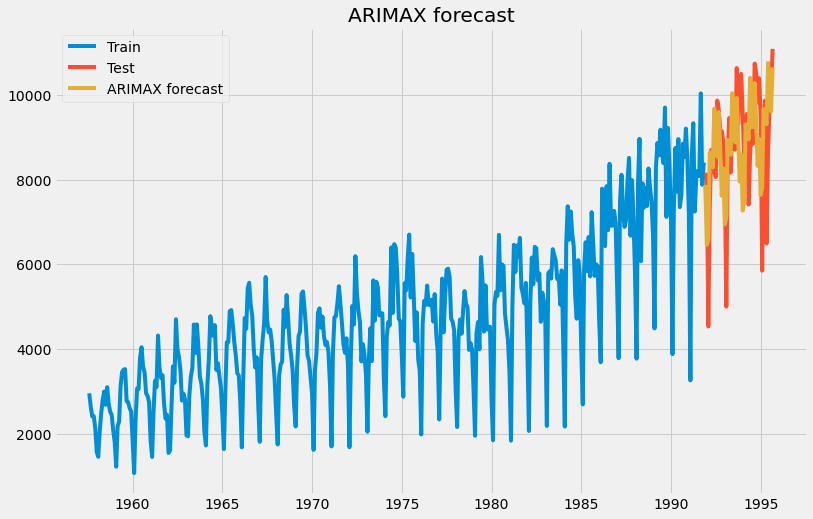

Evaluation metric results:-
MSE is : 1586734.5661959276
MAE is : 1022.5660470799756
MAPE is : 12.666653443742975
R2 is : 0.16526622633565247
RMSE is : 1259.6565270723315



In [128]:
plot(method= 'ARIMAX' )

# ARIMAX With PMDARIMA LIBRARY

• Pmdarima (for py + arima) is a statistical library designed to fill the void in Python’s time-series analysis capabilities, which is the equivalent of R’s auto.arima

In [129]:
import pmdarima as pmd

def arimamodel():
    autoarima_model = pmd.auto_arima(train[time_dependent_variable], 
                              start_p=1, 
                              start_q=1,
                               max_p=7, max_q=7, 
                              seasonal=False, trend = trend,
                               d=None, trace=True,error_action='ignore',
                              suppress_warnings=True,stepwise=True)
    return autoarima_model


In [130]:
def auto_arima(max_p= 7, max_q=7, method = "Auto_ARIMAX"):
    model = pmd.auto_arima(train[time_dependent_variable], 
                          start_p=1, 
                          start_q=1,
                           max_p=max_p, max_q=max_q,
                           X= exog_train,
                           seasonal=False, 
                           d=None, trace=True,error_action='ignore',
                          suppress_warnings=True,stepwise=True,
                           n_jobs= -1)

    
    
    print("\n\n\n\n")
    print(method + " Model Summary is : ")
    print(model.summary())
    print("\n\n\n\n")
    
    y_hat.loc[:,method] = model.predict(len(test), X= exog_test)

    print("Test Dataset After Forecast: ")
    print(y_hat.head(5))
    print("\n\n\n\n")
#     arima_model.plot_diagnostics()
    

    print(metrics_(method))
    
auto_arima()

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=6908.098, Time=0.74 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=7369.975, Time=0.25 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=6907.207, Time=0.60 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=7090.891, Time=0.53 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=6908.170, Time=0.89 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.72 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=6909.170, Time=0.54 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0]          
Total fit time: 4.265 seconds





Auto_ARIMAX Model Summary is : 
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  412
Model:               SARIMAX(1, 0, 0)   Log Likelihood               -3447.604
Date:                Sat, 09 Oct 2021   AIC                           6907.207
Time:                        10:27:17   BIC                           

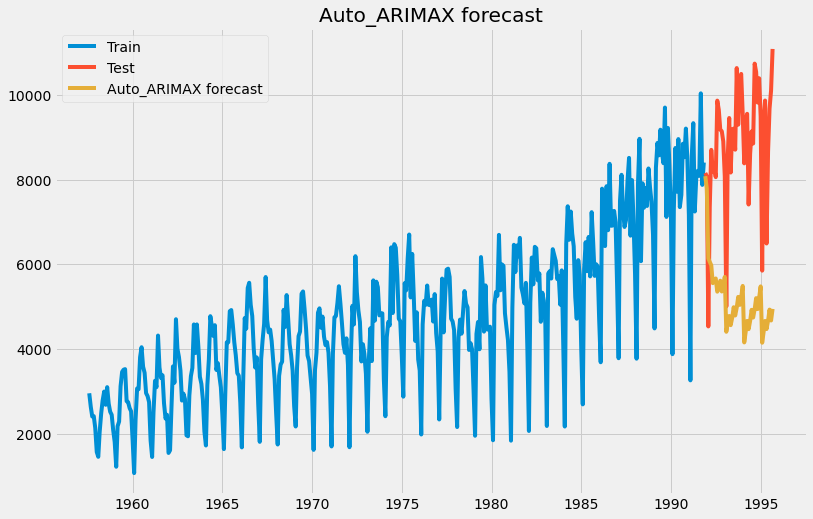

Evaluation metric results:-
MSE is : 16499362.166225037
MAE is : 3786.7760170837314
MAPE is : 41.3511476272495
R2 is : -7.679822786672167
RMSE is : 4061.9406896488576



In [131]:
plot(method=  "Auto_ARIMAX")

# SARIMAX

m refers to the number of periods in each season.

• 7 → Daily

• 12 → Monthly

• 52 → Weekly

• 4 → Quarterly

• 1 → Annual (non-seasonal)

In [132]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
def sarima(p,d,q, P=0,D=0,Q=0,M=12, method = 'SARIMAX' ):


    
    model = SARIMAX(train[time_dependent_variable], exog=exog_train, order=(p,d,q),  seasonal_order=(P,D,Q,M))
    fit1 = model.fit()
    print(fit1.summary())
    y_hat[method] = fit1.predict(start=len(train), end=len(train)+len(test)-1,exog= exog_test, dynamic=False, typ='levels',start_params=[0, 0, 0, 0, 0, 1])
    
    metric = sqrt(mean_squared_error(test[time_dependent_variable], y_hat.SARIMAX))
    return metrics_(method)
sarima(1, 1, 1, 1, 1, 3)

                                         SARIMAX Results                                          
Dep. Variable:                                     Volume   No. Observations:                  412
Model:             SARIMAX(1, 1, 1)x(1, 1, [1, 2, 3], 12)   Log Likelihood               -3043.064
Date:                                    Sat, 09 Oct 2021   AIC                           6108.127
Time:                                            10:27:32   BIC                           6152.006
Sample:                                                 0   HQIC                          6125.505
                                                    - 412                                         
Covariance Type:                                      opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
year           2.6596      3.398      0.783      0

9.079049947459506

In [133]:
# evaluate combinations of p, d and q values for an ARIMA model
def sarima_best_params(p_values=range(4), d_values=range(2), q_values=range(4), P_values=range(4), D_values=range(2), Q_values=range(4)):
    best_score, best_cfg = float("inf"), None
#for m in [1, 4,7,12,52]:
    for p in p_values:
        for d in d_values:
            for q in q_values:
                    for P in P_values:
                        for D in D_values:
                            for Q in Q_values:
                                order = (p,d,q,P,D,Q)
                                try:
                                    metric = sarima(*order)
                                    if metric < best_score:
                                        best_score, best_cfg = metric, order
                                    print('SARIMAX%s metric=%.3f' % (order,metric))
                                except:
                                    continue
    print('Best SARIMAX%s metric=%.3f' % (best_cfg, best_score))
    return best_cfg 
    
best_cfg = sarima_best_params()

                               SARIMAX Results                                
Dep. Variable:                 Volume   No. Observations:                  412
Model:                        SARIMAX   Log Likelihood               -3679.987
Date:                Sat, 09 Oct 2021   AIC                           7369.975
Time:                        10:27:33   BIC                           7390.080
Sample:                             0   HQIC                          7377.927
                                - 412                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
year           2.4641      0.149     16.499      0.000       2.171       2.757
quarter     -522.5056    350.545     -1.491      0.136   -1209.562     164.551
month        181.3926    111.347      1.629      0.1

                                SARIMAX Results                                 
Dep. Variable:                   Volume   No. Observations:                  412
Model:             SARIMAX(0, 1, 0, 12)   Log Likelihood               -3133.951
Date:                  Sat, 09 Oct 2021   AIC                           6277.901
Time:                          10:27:39   BIC                           6297.859
Sample:                               0   HQIC                          6285.805
                                  - 412                                         
Covariance Type:                    opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
year         165.6953     30.843      5.372      0.000     105.244     226.147
quarter             0   5.09e-11          0      1.000   -9.99e-11    9.99e-11
month               0         -0    

                                SARIMAX Results                                 
Dep. Variable:                   Volume   No. Observations:                  412
Model:             SARIMAX(1, 0, 0, 12)   Log Likelihood               -3256.161
Date:                  Sat, 09 Oct 2021   AIC                           6524.321
Time:                          10:27:44   BIC                           6548.447
Sample:                               0   HQIC                          6533.864
                                  - 412                                         
Covariance Type:                    opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
year           2.6072      0.727      3.589      0.000       1.183       4.031
quarter     -522.5319   2027.147     -0.258      0.797   -4495.667    3450.604
month        181.3247    641.298    

                                SARIMAX Results                                 
Dep. Variable:                   Volume   No. Observations:                  412
Model:             SARIMAX(1, 1, 0, 12)   Log Likelihood               -3135.466
Date:                  Sat, 09 Oct 2021   AIC                           6282.931
Time:                          10:27:56   BIC                           6306.880
Sample:                               0   HQIC                          6292.415
                                  - 412                                         
Covariance Type:                    opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
year         165.6941     27.371      6.054      0.000     112.047     219.341
quarter    -1.299e-06     11.435  -1.14e-07      1.000     -22.412      22.412
month      -3.376e-06     39.272   -

                                SARIMAX Results                                 
Dep. Variable:                   Volume   No. Observations:                  412
Model:             SARIMAX(2, 0, 0, 12)   Log Likelihood               -3242.475
Date:                  Sat, 09 Oct 2021   AIC                           6498.951
Time:                          10:28:09   BIC                           6527.098
Sample:                               0   HQIC                          6510.084
                                  - 412                                         
Covariance Type:                    opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
year           2.6564      0.872      3.046      0.002       0.947       4.365
quarter     -522.5547   2439.422     -0.214      0.830   -5303.734    4258.624
month        181.4552    769.613    

                                SARIMAX Results                                 
Dep. Variable:                   Volume   No. Observations:                  412
Model:             SARIMAX(2, 1, 0, 12)   Log Likelihood               -3135.619
Date:                  Sat, 09 Oct 2021   AIC                           6285.237
Time:                          10:28:27   BIC                           6313.178
Sample:                               0   HQIC                          6296.302
                                  - 412                                         
Covariance Type:                    opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
year         165.6938     27.079      6.119      0.000     112.621     218.767
quarter    -1.596e-06   6.15e+04  -2.59e-11      1.000   -1.21e+05    1.21e+05
month      -4.147e-06   6.15e+04  -6

                                SARIMAX Results                                 
Dep. Variable:                   Volume   No. Observations:                  412
Model:             SARIMAX(3, 0, 0, 12)   Log Likelihood               -3242.453
Date:                  Sat, 09 Oct 2021   AIC                           6500.906
Time:                          10:28:46   BIC                           6533.074
Sample:                               0   HQIC                          6513.630
                                  - 412                                         
Covariance Type:                    opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
year           2.6595      0.881      3.020      0.003       0.933       4.385
quarter     -522.5588   2456.679     -0.213      0.832   -5337.561    4292.444
month        181.4440    775.632    

                                SARIMAX Results                                 
Dep. Variable:                   Volume   No. Observations:                  412
Model:             SARIMAX(3, 1, 0, 12)   Log Likelihood               -3134.982
Date:                  Sat, 09 Oct 2021   AIC                           6285.965
Time:                          10:29:09   BIC                           6317.896
Sample:                               0   HQIC                          6298.610
                                  - 412                                         
Covariance Type:                    opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
year         165.6938     27.862      5.947      0.000     111.086     220.302
quarter    -1.625e-06   2.09e+04  -7.78e-11      1.000   -4.09e+04    4.09e+04
month      -4.222e-06   2.15e+04  -1

                               SARIMAX Results                                
Dep. Variable:                 Volume   No. Observations:                  412
Model:               SARIMAX(0, 0, 1)   Log Likelihood               -3539.446
Date:                Sat, 09 Oct 2021   AIC                           7090.891
Time:                        10:29:17   BIC                           7115.017
Sample:                             0   HQIC                          7100.434
                                - 412                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
year           2.1968      0.135     16.313      0.000       1.933       2.461
quarter     -487.0144    213.054     -2.286      0.022    -904.592     -69.437
month        242.7521     67.882      3.576      0.0

                                      SARIMAX Results                                      
Dep. Variable:                              Volume   No. Observations:                  412
Model:             SARIMAX(0, 0, 1)x(0, 1, [], 12)   Log Likelihood               -3133.697
Date:                             Sat, 09 Oct 2021   AIC                           6279.393
Time:                                     10:29:25   BIC                           6303.342
Sample:                                          0   HQIC                          6288.877
                                             - 412                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
year         165.6949     30.358      5.458      0.000     106.194     225.196
quarter    -1.782e-07     7

                                      SARIMAX Results                                      
Dep. Variable:                              Volume   No. Observations:                  412
Model:             SARIMAX(0, 0, 1)x(1, 0, [], 12)   Log Likelihood               -3239.623
Date:                             Sat, 09 Oct 2021   AIC                           6493.245
Time:                                     10:29:34   BIC                           6521.392
Sample:                                          0   HQIC                          6504.379
                                             - 412                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
year           2.5244      0.605      4.176      0.000       1.339       3.709
quarter     -520.3303   139

                                      SARIMAX Results                                      
Dep. Variable:                              Volume   No. Observations:                  412
Model:             SARIMAX(0, 0, 1)x(1, 1, [], 12)   Log Likelihood               -3133.577
Date:                             Sat, 09 Oct 2021   AIC                           6281.155
Time:                                     10:29:41   BIC                           6309.095
Sample:                                          0   HQIC                          6292.219
                                             - 412                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
year         165.6939     30.388      5.453      0.000     106.134     225.254
quarter    -1.495e-06    16

                                      SARIMAX Results                                      
Dep. Variable:                              Volume   No. Observations:                  412
Model:             SARIMAX(0, 0, 1)x(2, 0, [], 12)   Log Likelihood               -3220.141
Date:                             Sat, 09 Oct 2021   AIC                           6456.282
Time:                                     10:29:51   BIC                           6488.450
Sample:                                          0   HQIC                          6469.006
                                             - 412                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
year           2.5524      0.886      2.882      0.004       0.816       4.288
quarter     -520.0546   203

                                      SARIMAX Results                                      
Dep. Variable:                              Volume   No. Observations:                  412
Model:             SARIMAX(0, 0, 1)x(2, 1, [], 12)   Log Likelihood               -3133.468
Date:                             Sat, 09 Oct 2021   AIC                           6282.935
Time:                                     10:30:07   BIC                           6314.867
Sample:                                          0   HQIC                          6295.581
                                             - 412                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
year         165.6938     30.404      5.450      0.000     106.104     225.284
quarter     -1.58e-06   5.1

                                     SARIMAX Results                                      
Dep. Variable:                             Volume   No. Observations:                  412
Model:             SARIMAX(0, 0, 1)x(3, 0, 1, 12)   Log Likelihood               -3398.959
Date:                            Sat, 09 Oct 2021   AIC                           6817.917
Time:                                    10:30:42   BIC                           6858.128
Sample:                                         0   HQIC                          6833.823
                                            - 412                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
year           9.3191      6.011      1.550      0.121      -2.462      21.100
quarter     -521.6637   1.58e+04   

                                        SARIMAX Results                                        
Dep. Variable:                                  Volume   No. Observations:                  412
Model:             SARIMAX(0, 0, 1)x(3, 1, [1, 2], 12)   Log Likelihood               -3133.505
Date:                                 Sat, 09 Oct 2021   AIC                           6289.010
Time:                                         10:31:08   BIC                           6332.916
Sample:                                              0   HQIC                          6306.397
                                                 - 412                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
year         165.6935     30.893      5.363      0.000     105.145     226

                                     SARIMAX Results                                      
Dep. Variable:                             Volume   No. Observations:                  412
Model:             SARIMAX(0, 0, 2)x(0, 0, 2, 12)   Log Likelihood               -3333.010
Date:                            Sat, 09 Oct 2021   AIC                           6684.020
Time:                                    10:31:18   BIC                           6720.210
Sample:                                         0   HQIC                          6698.335
                                            - 412                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
year           2.1969      0.199     11.033      0.000       1.807       2.587
quarter     -499.3493    240.742   

                                     SARIMAX Results                                      
Dep. Variable:                             Volume   No. Observations:                  412
Model:             SARIMAX(0, 0, 2)x(0, 1, 2, 12)   Log Likelihood               -3133.629
Date:                            Sat, 09 Oct 2021   AIC                           6285.258
Time:                                    10:31:29   BIC                           6321.181
Sample:                                         0   HQIC                          6299.484
                                            - 412                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
year         165.6914     29.502      5.616      0.000     107.868     223.515
quarter    -4.622e-06    163.317  -

                                     SARIMAX Results                                      
Dep. Variable:                             Volume   No. Observations:                  412
Model:             SARIMAX(0, 0, 2)x(1, 0, 2, 12)   Log Likelihood               -3250.559
Date:                            Sat, 09 Oct 2021   AIC                           6521.118
Time:                                    10:31:40   BIC                           6561.328
Sample:                                         0   HQIC                          6537.023
                                            - 412                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
year          31.8775     27.206      1.172      0.241     -21.444      85.199
quarter     -519.7576     97.283   

                                     SARIMAX Results                                      
Dep. Variable:                             Volume   No. Observations:                  412
Model:             SARIMAX(0, 0, 2)x(1, 1, 2, 12)   Log Likelihood               -3133.634
Date:                            Sat, 09 Oct 2021   AIC                           6287.268
Time:                                    10:31:55   BIC                           6327.182
Sample:                                         0   HQIC                          6303.075
                                            - 412                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
year         165.6929     29.563      5.605      0.000     107.751     223.634
quarter    -2.732e-06    126.573  -

                                     SARIMAX Results                                      
Dep. Variable:                             Volume   No. Observations:                  412
Model:             SARIMAX(0, 0, 2)x(2, 0, 2, 12)   Log Likelihood               -3366.672
Date:                            Sat, 09 Oct 2021   AIC                           6755.344
Time:                                    10:32:14   BIC                           6799.575
Sample:                                         0   HQIC                          6772.840
                                            - 412                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
year           2.1885     19.968      0.110      0.913     -36.948      41.325
quarter     -521.5066    493.839   

                                     SARIMAX Results                                      
Dep. Variable:                             Volume   No. Observations:                  412
Model:             SARIMAX(0, 0, 2)x(2, 1, 2, 12)   Log Likelihood               -3133.652
Date:                            Sat, 09 Oct 2021   AIC                           6289.303
Time:                                    10:32:29   BIC                           6333.209
Sample:                                         0   HQIC                          6306.691
                                            - 412                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
year         165.6937     29.797      5.561      0.000     107.292     224.096
quarter    -1.684e-06   3.23e+04  -

                                      SARIMAX Results                                      
Dep. Variable:                              Volume   No. Observations:                  412
Model:             SARIMAX(0, 0, 2)x(3, 1, [], 12)   Log Likelihood               -3133.627
Date:                             Sat, 09 Oct 2021   AIC                           6287.254
Time:                                     10:33:05   BIC                           6327.169
Sample:                                          0   HQIC                          6303.061
                                             - 412                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
year         165.6935     29.606      5.597      0.000     107.667     223.719
quarter    -1.953e-06   3.2

                               SARIMAX Results                                
Dep. Variable:                 Volume   No. Observations:                  412
Model:               SARIMAX(0, 0, 3)   Log Likelihood               -3479.085
Date:                Sat, 09 Oct 2021   AIC                           6974.170
Time:                        10:33:28   BIC                           7006.338
Sample:                             0   HQIC                          6986.894
                                - 412                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
year           2.1326      0.173     12.359      0.000       1.794       2.471
quarter     -474.6720    207.341     -2.289      0.022    -881.054     -68.290
month        252.0802     65.219      3.865      0.0

                                      SARIMAX Results                                      
Dep. Variable:                              Volume   No. Observations:                  412
Model:             SARIMAX(0, 0, 3)x(0, 1, [], 12)   Log Likelihood               -3133.986
Date:                             Sat, 09 Oct 2021   AIC                           6283.973
Time:                                     10:33:39   BIC                           6315.904
Sample:                                          0   HQIC                          6296.618
                                             - 412                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
year         165.6947     29.248      5.665      0.000     108.369     223.020
quarter     -4.31e-07    11

                                      SARIMAX Results                                      
Dep. Variable:                              Volume   No. Observations:                  412
Model:             SARIMAX(0, 0, 3)x(1, 0, [], 12)   Log Likelihood               -3227.185
Date:                             Sat, 09 Oct 2021   AIC                           6472.369
Time:                                     10:33:49   BIC                           6508.558
Sample:                                          0   HQIC                          6486.684
                                             - 412                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
year           2.9041      0.493      5.890      0.000       1.938       3.870
quarter     -518.4063    98

                                      SARIMAX Results                                      
Dep. Variable:                              Volume   No. Observations:                  412
Model:             SARIMAX(0, 0, 3)x(1, 1, [], 12)   Log Likelihood               -3133.826
Date:                             Sat, 09 Oct 2021   AIC                           6285.652
Time:                                     10:34:02   BIC                           6321.576
Sample:                                          0   HQIC                          6299.879
                                             - 412                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
year         165.6936     29.285      5.658      0.000     108.297     223.090
quarter    -1.699e-06    16

                                      SARIMAX Results                                      
Dep. Variable:                              Volume   No. Observations:                  412
Model:             SARIMAX(0, 0, 3)x(2, 0, [], 12)   Log Likelihood               -3224.691
Date:                             Sat, 09 Oct 2021   AIC                           6469.383
Time:                                     10:34:14   BIC                           6509.593
Sample:                                          0   HQIC                          6485.288
                                             - 412                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
year           2.4616     21.394      0.115      0.908     -39.470      44.394
quarter     -518.3524      

                                      SARIMAX Results                                      
Dep. Variable:                              Volume   No. Observations:                  412
Model:             SARIMAX(0, 0, 3)x(2, 1, [], 12)   Log Likelihood               -3133.712
Date:                             Sat, 09 Oct 2021   AIC                           6287.424
Time:                                     10:34:37   BIC                           6327.338
Sample:                                          0   HQIC                          6303.230
                                             - 412                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
year         165.6934     29.281      5.659      0.000     108.303     223.084
quarter    -1.946e-06    27

                                      SARIMAX Results                                      
Dep. Variable:                              Volume   No. Observations:                  412
Model:             SARIMAX(0, 0, 3)x(3, 0, [], 12)   Log Likelihood               -3197.241
Date:                             Sat, 09 Oct 2021   AIC                           6416.482
Time:                                     10:35:00   BIC                           6460.713
Sample:                                          0   HQIC                          6433.978
                                             - 412                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
year           2.6126      0.616      4.245      0.000       1.406       3.819
quarter     -518.2852   125

                                        SARIMAX Results                                        
Dep. Variable:                                  Volume   No. Observations:                  412
Model:             SARIMAX(0, 0, 3)x(3, 1, [1, 2], 12)   Log Likelihood               -3133.746
Date:                                 Sat, 09 Oct 2021   AIC                           6293.491
Time:                                         10:35:46   BIC                           6345.380
Sample:                                              0   HQIC                          6314.040
                                                 - 412                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
year         165.6935     29.735      5.572      0.000     107.414     223

                                        SARIMAX Results                                        
Dep. Variable:                                  Volume   No. Observations:                  412
Model:             SARIMAX(0, 1, 0)x(0, 0, [1, 2], 12)   Log Likelihood               -3453.225
Date:                                 Sat, 09 Oct 2021   AIC                           6920.450
Time:                                         10:35:58   BIC                           6948.580
Sample:                                              0   HQIC                          6931.578
                                                 - 412                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
year         149.6520    398.593      0.375      0.707    -631.576     930

                                        SARIMAX Results                                        
Dep. Variable:                                  Volume   No. Observations:                  412
Model:             SARIMAX(0, 1, 0)x(0, 1, [1, 2], 12)   Log Likelihood               -3127.751
Date:                                 Sat, 09 Oct 2021   AIC                           6269.502
Time:                                         10:36:04   BIC                           6297.425
Sample:                                              0   HQIC                          6280.561
                                                 - 412                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
year           2.8552      5.126      0.557      0.578      -7.192      12

                                        SARIMAX Results                                        
Dep. Variable:                                  Volume   No. Observations:                  412
Model:             SARIMAX(0, 1, 0)x(1, 0, [1, 2], 12)   Log Likelihood               -3244.329
Date:                                 Sat, 09 Oct 2021   AIC                           6504.658
Time:                                         10:36:16   BIC                           6536.807
Sample:                                              0   HQIC                          6517.376
                                                 - 412                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
year          -0.4149      0.887     -0.468      0.640      -2.153       1

                                        SARIMAX Results                                        
Dep. Variable:                                  Volume   No. Observations:                  412
Model:             SARIMAX(0, 1, 0)x(1, 1, [1, 2], 12)   Log Likelihood               -3127.492
Date:                                 Sat, 09 Oct 2021   AIC                           6270.984
Time:                                         10:36:29   BIC                           6302.896
Sample:                                              0   HQIC                          6283.623
                                                 - 412                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
year           2.8165      5.155      0.546      0.585      -7.286      12

                                        SARIMAX Results                                        
Dep. Variable:                                  Volume   No. Observations:                  412
Model:             SARIMAX(0, 1, 0)x(2, 0, [1, 2], 12)   Log Likelihood               -3251.131
Date:                                 Sat, 09 Oct 2021   AIC                           6520.261
Time:                                         10:36:43   BIC                           6556.429
Sample:                                              0   HQIC                          6534.569
                                                 - 412                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
year           1.2564      2.196      0.572      0.567      -3.048       5

                                        SARIMAX Results                                        
Dep. Variable:                                  Volume   No. Observations:                  412
Model:             SARIMAX(0, 1, 0)x(2, 1, [1, 2], 12)   Log Likelihood               -3128.277
Date:                                 Sat, 09 Oct 2021   AIC                           6274.555
Time:                                         10:37:04   BIC                           6310.455
Sample:                                              0   HQIC                          6288.773
                                                 - 412                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
year           2.8103      5.350      0.525      0.599      -7.675      13

                                        SARIMAX Results                                        
Dep. Variable:                                  Volume   No. Observations:                  412
Model:             SARIMAX(0, 1, 0)x(3, 0, [1, 2], 12)   Log Likelihood               -3251.337
Date:                                 Sat, 09 Oct 2021   AIC                           6522.673
Time:                                         10:37:34   BIC                           6562.859
Sample:                                              0   HQIC                          6538.570
                                                 - 412                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
year           1.2291      2.271      0.541      0.588      -3.223       5

                                        SARIMAX Results                                        
Dep. Variable:                                  Volume   No. Observations:                  412
Model:             SARIMAX(0, 1, 0)x(3, 1, [1, 2], 12)   Log Likelihood               -3125.107
Date:                                 Sat, 09 Oct 2021   AIC                           6270.214
Time:                                         10:38:13   BIC                           6310.104
Sample:                                              0   HQIC                          6286.012
                                                 - 412                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
year           0.5384      2.815      0.191      0.848      -4.978       6

                                        SARIMAX Results                                        
Dep. Variable:                                  Volume   No. Observations:                  412
Model:             SARIMAX(0, 1, 1)x(0, 0, [1, 2], 12)   Log Likelihood               -3451.316
Date:                                 Sat, 09 Oct 2021   AIC                           6918.633
Time:                                         10:38:27   BIC                           6950.781
Sample:                                              0   HQIC                          6931.350
                                                 - 412                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
year         149.6519    344.468      0.434      0.664    -525.494     824

                                        SARIMAX Results                                        
Dep. Variable:                                  Volume   No. Observations:                  412
Model:             SARIMAX(0, 1, 1)x(0, 1, [1, 2], 12)   Log Likelihood               -3041.490
Date:                                 Sat, 09 Oct 2021   AIC                           6098.980
Time:                                         10:38:35   BIC                           6130.891
Sample:                                              0   HQIC                          6111.618
                                                 - 412                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
year           2.6084      3.317      0.786      0.432      -3.892       9

                                        SARIMAX Results                                        
Dep. Variable:                                  Volume   No. Observations:                  412
Model:             SARIMAX(0, 1, 1)x(1, 0, [1, 2], 12)   Log Likelihood               -3288.393
Date:                                 Sat, 09 Oct 2021   AIC                           6594.785
Time:                                         10:38:50   BIC                           6630.952
Sample:                                              0   HQIC                          6609.092
                                                 - 412                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
year           0.8878      3.920      0.226      0.821      -6.795       8

                                        SARIMAX Results                                        
Dep. Variable:                                  Volume   No. Observations:                  412
Model:             SARIMAX(0, 1, 1)x(1, 1, [1, 2], 12)   Log Likelihood               -3041.519
Date:                                 Sat, 09 Oct 2021   AIC                           6101.038
Time:                                         10:39:08   BIC                           6136.939
Sample:                                              0   HQIC                          6115.256
                                                 - 412                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
year           2.6095      3.274      0.797      0.425      -3.807       9

                                        SARIMAX Results                                        
Dep. Variable:                                  Volume   No. Observations:                  412
Model:             SARIMAX(0, 1, 1)x(2, 0, [1, 2], 12)   Log Likelihood               -3441.686
Date:                                 Sat, 09 Oct 2021   AIC                           6903.372
Time:                                         10:39:25   BIC                           6943.557
Sample:                                              0   HQIC                          6919.269
                                                 - 412                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
year         149.3213     60.210      2.480      0.013      31.313     267

                                        SARIMAX Results                                        
Dep. Variable:                                  Volume   No. Observations:                  412
Model:             SARIMAX(0, 1, 1)x(2, 1, [1, 2], 12)   Log Likelihood               -3041.487
Date:                                 Sat, 09 Oct 2021   AIC                           6102.975
Time:                                         10:39:47   BIC                           6142.864
Sample:                                              0   HQIC                          6118.773
                                                 - 412                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
year           2.8049      3.105      0.903      0.366      -3.280       8

                                        SARIMAX Results                                        
Dep. Variable:                                  Volume   No. Observations:                  412
Model:             SARIMAX(0, 1, 1)x(3, 0, [1, 2], 12)   Log Likelihood               -3441.626
Date:                                 Sat, 09 Oct 2021   AIC                           6905.253
Time:                                         10:40:15   BIC                           6949.457
Sample:                                              0   HQIC                          6922.739
                                                 - 412                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
year         149.0440     60.127      2.479      0.013      31.197     266

                                        SARIMAX Results                                        
Dep. Variable:                                  Volume   No. Observations:                  412
Model:             SARIMAX(0, 1, 1)x(3, 1, [1, 2], 12)   Log Likelihood               -3041.444
Date:                                 Sat, 09 Oct 2021   AIC                           6104.887
Time:                                         10:40:56   BIC                           6148.766
Sample:                                              0   HQIC                          6122.266
                                                 - 412                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
year           2.5917      3.310      0.783      0.434      -3.896       9

                                     SARIMAX Results                                      
Dep. Variable:                             Volume   No. Observations:                  412
Model:             SARIMAX(0, 1, 2)x(0, 0, 2, 12)   Log Likelihood               -3451.325
Date:                            Sat, 09 Oct 2021   AIC                           6920.650
Time:                                    10:41:10   BIC                           6956.818
Sample:                                         0   HQIC                          6934.958
                                            - 412                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
year         149.6511    316.193      0.473      0.636    -470.075     769.377
quarter     -199.6817    167.666   

                                     SARIMAX Results                                      
Dep. Variable:                             Volume   No. Observations:                  412
Model:             SARIMAX(0, 1, 2)x(0, 1, 2, 12)   Log Likelihood               -3040.799
Date:                            Sat, 09 Oct 2021   AIC                           6099.598
Time:                                    10:41:21   BIC                           6135.498
Sample:                                         0   HQIC                          6113.816
                                            - 412                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
year           2.6770      3.397      0.788      0.431      -3.980       9.334
quarter        0.2780   4820.651   

                                     SARIMAX Results                                      
Dep. Variable:                             Volume   No. Observations:                  412
Model:             SARIMAX(0, 1, 2)x(1, 0, 2, 12)   Log Likelihood               -3440.862
Date:                            Sat, 09 Oct 2021   AIC                           6901.723
Time:                                    10:41:35   BIC                           6941.909
Sample:                                         0   HQIC                          6917.620
                                            - 412                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
year         149.5924     55.610      2.690      0.007      40.599     258.585
quarter     -199.6758    202.302   

                                     SARIMAX Results                                      
Dep. Variable:                             Volume   No. Observations:                  412
Model:             SARIMAX(0, 1, 2)x(1, 1, 2, 12)   Log Likelihood               -3041.726
Date:                            Sat, 09 Oct 2021   AIC                           6103.451
Time:                                    10:41:57   BIC                           6143.341
Sample:                                         0   HQIC                          6119.250
                                            - 412                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
year           3.0196      3.048      0.991      0.322      -2.955       8.994
quarter        0.1825   4388.219   

                                     SARIMAX Results                                      
Dep. Variable:                             Volume   No. Observations:                  412
Model:             SARIMAX(0, 1, 2)x(2, 0, 2, 12)   Log Likelihood               -3440.765
Date:                            Sat, 09 Oct 2021   AIC                           6903.530
Time:                                    10:42:15   BIC                           6947.734
Sample:                                         0   HQIC                          6921.016
                                            - 412                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
year         149.2772     55.350      2.697      0.007      40.794     257.760
quarter     -199.6221    203.188   

                                     SARIMAX Results                                      
Dep. Variable:                             Volume   No. Observations:                  412
Model:             SARIMAX(0, 1, 2)x(2, 1, 2, 12)   Log Likelihood               -3041.295
Date:                            Sat, 09 Oct 2021   AIC                           6104.590
Time:                                    10:42:40   BIC                           6148.468
Sample:                                         0   HQIC                          6121.968
                                            - 412                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
year           2.2977      3.752      0.612      0.540      -5.056       9.651
quarter        0.2492    118.569   

                                     SARIMAX Results                                      
Dep. Variable:                             Volume   No. Observations:                  412
Model:             SARIMAX(0, 1, 2)x(3, 0, 2, 12)   Log Likelihood               -3440.691
Date:                            Sat, 09 Oct 2021   AIC                           6905.382
Time:                                    10:43:07   BIC                           6953.605
Sample:                                         0   HQIC                          6924.459
                                            - 412                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
year         148.9497     55.006      2.708      0.007      41.140     256.760
quarter     -199.5744    203.767   

                                     SARIMAX Results                                      
Dep. Variable:                             Volume   No. Observations:                  412
Model:             SARIMAX(0, 1, 2)x(3, 1, 2, 12)   Log Likelihood               -3043.276
Date:                            Sat, 09 Oct 2021   AIC                           6110.552
Time:                                    10:43:49   BIC                           6158.420
Sample:                                         0   HQIC                          6129.510
                                            - 412                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
year           2.4449      3.541      0.691      0.490      -4.495       9.385
quarter        0.1937    254.325   

                                        SARIMAX Results                                        
Dep. Variable:                                  Volume   No. Observations:                  412
Model:             SARIMAX(0, 1, 3)x(0, 0, [1, 2], 12)   Log Likelihood               -3452.141
Date:                                 Sat, 09 Oct 2021   AIC                           6924.283
Time:                                         10:44:05   BIC                           6964.469
Sample:                                              0   HQIC                          6940.180
                                                 - 412                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
year         149.6487    289.743      0.516      0.606    -418.236     717

                                        SARIMAX Results                                        
Dep. Variable:                                  Volume   No. Observations:                  412
Model:             SARIMAX(0, 1, 3)x(0, 1, [1, 2], 12)   Log Likelihood               -3040.141
Date:                                 Sat, 09 Oct 2021   AIC                           6100.283
Time:                                         10:44:20   BIC                           6140.172
Sample:                                              0   HQIC                          6116.081
                                                 - 412                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
year           2.2919      3.851      0.595      0.552      -5.255       9

                                        SARIMAX Results                                        
Dep. Variable:                                  Volume   No. Observations:                  412
Model:             SARIMAX(0, 1, 3)x(1, 0, [1, 2], 12)   Log Likelihood               -3440.403
Date:                                 Sat, 09 Oct 2021   AIC                           6902.807
Time:                                         10:44:37   BIC                           6947.011
Sample:                                              0   HQIC                          6920.293
                                                 - 412                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
year         149.5892     49.917      2.997      0.003      51.754     247

                                        SARIMAX Results                                        
Dep. Variable:                                  Volume   No. Observations:                  412
Model:             SARIMAX(0, 1, 3)x(1, 1, [1, 2], 12)   Log Likelihood               -3042.221
Date:                                 Sat, 09 Oct 2021   AIC                           6106.441
Time:                                         10:45:04   BIC                           6150.320
Sample:                                              0   HQIC                          6123.819
                                                 - 412                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
year           2.3954      3.532      0.678      0.498      -4.526       9

                                        SARIMAX Results                                        
Dep. Variable:                                  Volume   No. Observations:                  412
Model:             SARIMAX(0, 1, 3)x(2, 0, [1, 2], 12)   Log Likelihood               -3440.301
Date:                                 Sat, 09 Oct 2021   AIC                           6904.602
Time:                                         10:45:27   BIC                           6952.825
Sample:                                              0   HQIC                          6923.679
                                                 - 412                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
year         149.2803     49.733      3.002      0.003      51.806     246

                                        SARIMAX Results                                        
Dep. Variable:                                  Volume   No. Observations:                  412
Model:             SARIMAX(0, 1, 3)x(2, 1, [1, 2], 12)   Log Likelihood               -3042.320
Date:                                 Sat, 09 Oct 2021   AIC                           6108.641
Time:                                         10:45:57   BIC                           6156.508
Sample:                                              0   HQIC                          6127.599
                                                 - 412                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
year           2.6718      3.318      0.805      0.421      -3.831       9

                                      SARIMAX Results                                       
Dep. Variable:                               Volume   No. Observations:                  412
Model:             SARIMAX(0, 1, 3)x(3, 0, [1], 12)   Log Likelihood               -3440.348
Date:                              Sat, 09 Oct 2021   AIC                           6904.697
Time:                                      10:46:21   BIC                           6952.920
Sample:                                           0   HQIC                          6923.773
                                              - 412                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
year         149.6301     50.186      2.982      0.003      51.268     247.992
quarter     -199.68

                                      SARIMAX Results                                      
Dep. Variable:                              Volume   No. Observations:                  412
Model:             SARIMAX(0, 1, 3)x(3, 1, [], 12)   Log Likelihood               -3050.822
Date:                             Sat, 09 Oct 2021   AIC                           6123.644
Time:                                     10:46:53   BIC                           6167.523
Sample:                                          0   HQIC                          6141.022
                                             - 412                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
year           3.1040      2.998      1.035      0.301      -2.773       8.981
quarter        0.2549   542

                               SARIMAX Results                                
Dep. Variable:                 Volume   No. Observations:                  412
Model:               SARIMAX(1, 0, 0)   Log Likelihood               -3447.604
Date:                Sat, 09 Oct 2021   AIC                           6907.207
Time:                        10:47:39   BIC                           6931.333
Sample:                             0   HQIC                          6916.750
                                - 412                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
year           2.1798      0.200     10.882      0.000       1.787       2.572
quarter     -454.1184    167.888     -2.705      0.007    -783.173    -125.063
month        241.0708     50.875      4.738      0.0

                                     SARIMAX Results                                      
Dep. Variable:                             Volume   No. Observations:                  412
Model:             SARIMAX(1, 0, 0)x(0, 1, 0, 12)   Log Likelihood               -3134.116
Date:                            Sat, 09 Oct 2021   AIC                           6280.231
Time:                                    10:47:51   BIC                           6304.180
Sample:                                         0   HQIC                          6289.715
                                            - 412                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
year         165.6946     28.952      5.723      0.000     108.949     222.440
quarter    -4.691e-07     73.249   

                                     SARIMAX Results                                      
Dep. Variable:                             Volume   No. Observations:                  412
Model:             SARIMAX(1, 0, 0)x(1, 0, 0, 12)   Log Likelihood               -3232.149
Date:                            Sat, 09 Oct 2021   AIC                           6478.298
Time:                                    10:47:59   BIC                           6506.445
Sample:                                         0   HQIC                          6489.431
                                            - 412                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
year           2.1199      0.666      3.185      0.001       0.815       3.425
quarter     -520.0652    936.127   

                                     SARIMAX Results                                      
Dep. Variable:                             Volume   No. Observations:                  412
Model:             SARIMAX(1, 0, 0)x(1, 1, 0, 12)   Log Likelihood               -3133.980
Date:                            Sat, 09 Oct 2021   AIC                           6281.959
Time:                                    10:48:14   BIC                           6309.899
Sample:                                         0   HQIC                          6293.024
                                            - 412                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
year         165.6936     28.979      5.718      0.000     108.896     222.491
quarter     -1.76e-06     27.896  -

                                     SARIMAX Results                                      
Dep. Variable:                             Volume   No. Observations:                  412
Model:             SARIMAX(1, 0, 0)x(2, 0, 0, 12)   Log Likelihood               -3204.091
Date:                            Sat, 09 Oct 2021   AIC                           6424.182
Time:                                    10:48:38   BIC                           6456.350
Sample:                                         0   HQIC                          6436.906
                                            - 412                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
year           2.8168      1.681      1.676      0.094      -0.478       6.112
quarter     -519.6526   3007.723   

                                     SARIMAX Results                                      
Dep. Variable:                             Volume   No. Observations:                  412
Model:             SARIMAX(1, 0, 0)x(2, 1, 0, 12)   Log Likelihood               -3133.864
Date:                            Sat, 09 Oct 2021   AIC                           6283.729
Time:                                    10:48:57   BIC                           6315.660
Sample:                                         0   HQIC                          6296.374
                                            - 412                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
year         165.6935     29.044      5.705      0.000     108.769     222.618
quarter    -1.942e-06   3.47e+04  -

                                     SARIMAX Results                                      
Dep. Variable:                             Volume   No. Observations:                  412
Model:             SARIMAX(1, 0, 0)x(3, 0, 0, 12)   Log Likelihood               -3196.285
Date:                            Sat, 09 Oct 2021   AIC                           6410.569
Time:                                    10:49:18   BIC                           6446.759
Sample:                                         0   HQIC                          6424.884
                                            - 412                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
year           2.5843      1.092      2.368      0.018       0.445       4.724
quarter     -519.6927   1830.530   

                                      SARIMAX Results                                       
Dep. Variable:                               Volume   No. Observations:                  412
Model:             SARIMAX(1, 0, 0)x(3, 1, [1], 12)   Log Likelihood               -3133.858
Date:                              Sat, 09 Oct 2021   AIC                           6287.717
Time:                                      10:50:06   BIC                           6327.631
Sample:                                           0   HQIC                          6303.523
                                              - 412                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
year         165.6939     29.184      5.678      0.000     108.495     222.893
quarter    -1.416e-

                                     SARIMAX Results                                      
Dep. Variable:                             Volume   No. Observations:                  412
Model:             SARIMAX(1, 0, 1)x(0, 0, 1, 12)   Log Likelihood               -3348.070
Date:                            Sat, 09 Oct 2021   AIC                           6712.139
Time:                                    10:50:21   BIC                           6744.307
Sample:                                         0   HQIC                          6724.863
                                            - 412                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
year           2.1512      0.245      8.765      0.000       1.670       2.632
quarter     -496.1555    239.110   

                                     SARIMAX Results                                      
Dep. Variable:                             Volume   No. Observations:                  412
Model:             SARIMAX(1, 0, 1)x(0, 1, 1, 12)   Log Likelihood               -3134.146
Date:                            Sat, 09 Oct 2021   AIC                           6284.293
Time:                                    10:50:35   BIC                           6316.225
Sample:                                         0   HQIC                          6296.938
                                            - 412                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
year         165.6918     27.975      5.923      0.000     110.862     220.522
quarter    -3.187e-06    145.114   

                                     SARIMAX Results                                      
Dep. Variable:                             Volume   No. Observations:                  412
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 12)   Log Likelihood               -3158.318
Date:                            Sat, 09 Oct 2021   AIC                           6334.635
Time:                                    10:50:44   BIC                           6370.825
Sample:                                         0   HQIC                          6348.950
                                            - 412                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
year          12.8485     66.902      0.192      0.848    -118.276     143.973
quarter     -520.2726     35.141   

                                     SARIMAX Results                                      
Dep. Variable:                             Volume   No. Observations:                  412
Model:             SARIMAX(1, 0, 1)x(1, 1, 1, 12)   Log Likelihood               -3134.055
Date:                            Sat, 09 Oct 2021   AIC                           6286.110
Time:                                    10:51:05   BIC                           6322.033
Sample:                                         0   HQIC                          6300.336
                                            - 412                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
year         165.6915     28.151      5.886      0.000     110.517     220.866
quarter     -2.42e-06    134.317   

                                        SARIMAX Results                                        
Dep. Variable:                                  Volume   No. Observations:                  412
Model:             SARIMAX(1, 0, 1)x(2, 0, [1, 2], 12)   Log Likelihood               -3240.065
Date:                                 Sat, 09 Oct 2021   AIC                           6502.130
Time:                                         10:51:28   BIC                           6546.361
Sample:                                              0   HQIC                          6519.626
                                                 - 412                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
year          -9.7045     28.885     -0.336      0.737     -66.318      46

                                        SARIMAX Results                                        
Dep. Variable:                                  Volume   No. Observations:                  412
Model:             SARIMAX(1, 0, 1)x(2, 1, [1, 2], 12)   Log Likelihood               -3134.051
Date:                                 Sat, 09 Oct 2021   AIC                           6290.102
Time:                                         10:51:45   BIC                           6334.008
Sample:                                              0   HQIC                          6307.489
                                                 - 412                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
year         165.6934     28.227      5.870      0.000     110.370     221

                                      SARIMAX Results                                      
Dep. Variable:                              Volume   No. Observations:                  412
Model:             SARIMAX(1, 0, 1)x(3, 1, [], 12)   Log Likelihood               -3131.935
Date:                             Sat, 09 Oct 2021   AIC                           6283.871
Time:                                     10:52:42   BIC                           6323.785
Sample:                                          0   HQIC                          6299.677
                                             - 412                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
year         165.6658     29.005      5.712      0.000     108.817     222.514
quarter    -9.927e-06   532

                               SARIMAX Results                                
Dep. Variable:                 Volume   No. Observations:                  412
Model:               SARIMAX(1, 0, 2)   Log Likelihood               -3425.491
Date:                Sat, 09 Oct 2021   AIC                           6866.983
Time:                        10:52:57   BIC                           6899.151
Sample:                             0   HQIC                          6879.707
                                - 412                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
year          35.8325     90.565      0.396      0.692    -141.671     213.336
quarter     -491.7053     13.818    -35.584      0.000    -518.789    -464.622
month        242.4321     18.980     12.773      0.0

                                      SARIMAX Results                                      
Dep. Variable:                              Volume   No. Observations:                  412
Model:             SARIMAX(1, 0, 2)x(0, 1, [], 12)   Log Likelihood               -3134.817
Date:                             Sat, 09 Oct 2021   AIC                           6285.634
Time:                                     10:53:12   BIC                           6317.566
Sample:                                          0   HQIC                          6298.279
                                             - 412                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
year         165.6944     27.990      5.920      0.000     110.836     220.553
quarter    -6.289e-07     9

                                      SARIMAX Results                                      
Dep. Variable:                              Volume   No. Observations:                  412
Model:             SARIMAX(1, 0, 2)x(1, 0, [], 12)   Log Likelihood               -3214.335
Date:                             Sat, 09 Oct 2021   AIC                           6446.670
Time:                                     10:53:34   BIC                           6482.859
Sample:                                          0   HQIC                          6460.984
                                             - 412                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
year          -5.9221      8.387     -0.706      0.480     -22.360      10.516
quarter     -519.8227    66

                                      SARIMAX Results                                      
Dep. Variable:                              Volume   No. Observations:                  412
Model:             SARIMAX(1, 0, 2)x(1, 1, [], 12)   Log Likelihood               -3134.449
Date:                             Sat, 09 Oct 2021   AIC                           6286.898
Time:                                     10:53:54   BIC                           6322.822
Sample:                                          0   HQIC                          6301.125
                                             - 412                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
year         165.6934     27.968      5.924      0.000     110.876     220.510
quarter    -1.763e-06    29

                                      SARIMAX Results                                      
Dep. Variable:                              Volume   No. Observations:                  412
Model:             SARIMAX(1, 0, 2)x(2, 0, [], 12)   Log Likelihood               -3246.216
Date:                             Sat, 09 Oct 2021   AIC                           6512.432
Time:                                     10:54:12   BIC                           6552.642
Sample:                                          0   HQIC                          6528.337
                                             - 412                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
year         -23.1485     18.455     -1.254      0.210     -59.319      13.022
quarter     -521.0145      

                                      SARIMAX Results                                      
Dep. Variable:                              Volume   No. Observations:                  412
Model:             SARIMAX(1, 0, 2)x(2, 1, [], 12)   Log Likelihood               -3134.329
Date:                             Sat, 09 Oct 2021   AIC                           6288.658
Time:                                     10:54:39   BIC                           6328.572
Sample:                                          0   HQIC                          6304.464
                                             - 412                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
year         165.6933     27.983      5.921      0.000     110.848     220.539
quarter    -1.985e-06   3.0

                                      SARIMAX Results                                      
Dep. Variable:                              Volume   No. Observations:                  412
Model:             SARIMAX(1, 0, 2)x(3, 0, [], 12)   Log Likelihood               -3170.075
Date:                             Sat, 09 Oct 2021   AIC                           6362.150
Time:                                     10:54:58   BIC                           6406.381
Sample:                                          0   HQIC                          6379.645
                                             - 412                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
year         -98.9262    145.282     -0.681      0.496    -383.674     185.822
quarter     -520.1389   128

                                         SARIMAX Results                                          
Dep. Variable:                                     Volume   No. Observations:                  412
Model:             SARIMAX(1, 0, 2)x(3, 1, [1, 2, 3], 12)   Log Likelihood               -3134.474
Date:                                    Sat, 09 Oct 2021   AIC                           6296.948
Time:                                            10:55:53   BIC                           6352.828
Sample:                                                 0   HQIC                          6319.077
                                                    - 412                                         
Covariance Type:                                      opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
year         165.6932     29.272      5.661      0

                                     SARIMAX Results                                      
Dep. Variable:                             Volume   No. Observations:                  412
Model:             SARIMAX(1, 0, 3)x(0, 0, 3, 12)   Log Likelihood               -3245.780
Date:                            Sat, 09 Oct 2021   AIC                           6515.559
Time:                                    10:56:10   BIC                           6563.811
Sample:                                         0   HQIC                          6534.645
                                            - 412                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
year         -35.7888   8.23e-06  -4.35e+06      0.000     -35.789     -35.789
quarter     -511.0393   1.62e-05  -

                                     SARIMAX Results                                      
Dep. Variable:                             Volume   No. Observations:                  412
Model:             SARIMAX(1, 0, 3)x(0, 1, 3, 12)   Log Likelihood               -3133.952
Date:                            Sat, 09 Oct 2021   AIC                           6291.905
Time:                                    10:56:29   BIC                           6339.803
Sample:                                         0   HQIC                          6310.873
                                            - 412                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
year         165.6912     28.177      5.880      0.000     110.465     220.918
quarter    -4.063e-06    197.666  -

                                      SARIMAX Results                                      
Dep. Variable:                              Volume   No. Observations:                  412
Model:             SARIMAX(1, 0, 3)x(1, 1, [], 12)   Log Likelihood               -3133.987
Date:                             Sat, 09 Oct 2021   AIC                           6287.974
Time:                                     10:56:58   BIC                           6327.889
Sample:                                          0   HQIC                          6303.781
                                             - 412                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
year         165.6839     28.243      5.866      0.000     110.329     221.039
quarter     -6.32e-06      

                                        SARIMAX Results                                        
Dep. Variable:                                  Volume   No. Observations:                  412
Model:             SARIMAX(1, 0, 3)x(2, 0, [1, 2], 12)   Log Likelihood               -3272.730
Date:                                 Sat, 09 Oct 2021   AIC                           6571.459
Time:                                         10:57:28   BIC                           6623.732
Sample:                                              0   HQIC                          6592.136
                                                 - 412                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
year         -14.1528     91.254     -0.155      0.877    -193.008     164

                                      SARIMAX Results                                       
Dep. Variable:                               Volume   No. Observations:                  412
Model:             SARIMAX(1, 0, 3)x(2, 1, [1], 12)   Log Likelihood               -3134.014
Date:                              Sat, 09 Oct 2021   AIC                           6292.029
Time:                                      10:58:00   BIC                           6339.926
Sample:                                           0   HQIC                          6310.997
                                              - 412                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
year         165.6928     28.112      5.894      0.000     110.595     220.790
quarter    -2.234e-

                                      SARIMAX Results                                      
Dep. Variable:                              Volume   No. Observations:                  412
Model:             SARIMAX(1, 0, 3)x(3, 0, [], 12)   Log Likelihood               -3190.023
Date:                             Sat, 09 Oct 2021   AIC                           6404.046
Time:                                     10:58:28   BIC                           6452.299
Sample:                                          0   HQIC                          6423.132
                                             - 412                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
year         -99.4820    851.781     -0.117      0.907   -1768.942    1569.978
quarter     -520.5443   121

                                      SARIMAX Results                                      
Dep. Variable:                              Volume   No. Observations:                  412
Model:             SARIMAX(1, 0, 3)x(3, 1, [], 12)   Log Likelihood               -3133.980
Date:                             Sat, 09 Oct 2021   AIC                           6291.960
Time:                                     10:59:11   BIC                           6339.858
Sample:                                          0   HQIC                          6310.928
                                             - 412                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
year         165.6924     28.170      5.882      0.000     110.479     220.905
quarter    -2.786e-06   180

                                     SARIMAX Results                                      
Dep. Variable:                             Volume   No. Observations:                  412
Model:             SARIMAX(1, 0, 3)x(3, 1, 3, 12)   Log Likelihood               -3134.324
Date:                            Sat, 09 Oct 2021   AIC                           6298.647
Time:                                    10:59:37   BIC                           6358.519
Sample:                                         0   HQIC                          6322.357
                                            - 412                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
year         165.6922     29.473      5.622      0.000     107.925     223.459
quarter    -2.927e-06   4792.535  -

                                         SARIMAX Results                                          
Dep. Variable:                                     Volume   No. Observations:                  412
Model:             SARIMAX(1, 1, 0)x(0, 0, [1, 2, 3], 12)   Log Likelihood               -3449.157
Date:                                    Sat, 09 Oct 2021   AIC                           6916.315
Time:                                            10:59:40   BIC                           6952.482
Sample:                                                 0   HQIC                          6930.622
                                                    - 412                                         
Covariance Type:                                      opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
year         149.6511    237.590      0.630      0

                                         SARIMAX Results                                          
Dep. Variable:                                     Volume   No. Observations:                  412
Model:             SARIMAX(1, 1, 0)x(0, 1, [1, 2, 3], 12)   Log Likelihood               -3077.614
Date:                                    Sat, 09 Oct 2021   AIC                           6173.228
Time:                                            10:59:58   BIC                           6209.128
Sample:                                                 0   HQIC                          6187.446
                                                    - 412                                         
Covariance Type:                                      opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
year           3.6101      3.323      1.086      0

                                         SARIMAX Results                                          
Dep. Variable:                                     Volume   No. Observations:                  412
Model:             SARIMAX(1, 1, 0)x(1, 0, [1, 2, 3], 12)   Log Likelihood               -3441.638
Date:                                    Sat, 09 Oct 2021   AIC                           6903.277
Time:                                            11:00:07   BIC                           6943.463
Sample:                                                 0   HQIC                          6919.174
                                                    - 412                                         
Covariance Type:                                      opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
year         149.5937     60.082      2.490      0

                                         SARIMAX Results                                          
Dep. Variable:                                     Volume   No. Observations:                  412
Model:             SARIMAX(1, 1, 0)x(1, 1, [1, 2, 3], 12)   Log Likelihood               -3076.251
Date:                                    Sat, 09 Oct 2021   AIC                           6172.502
Time:                                            11:00:31   BIC                           6212.392
Sample:                                                 0   HQIC                          6188.301
                                                    - 412                                         
Covariance Type:                                      opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
year           2.7507      3.807      0.722      0

                                         SARIMAX Results                                          
Dep. Variable:                                     Volume   No. Observations:                  412
Model:             SARIMAX(1, 1, 0)x(2, 0, [1, 2, 3], 12)   Log Likelihood               -3447.475
Date:                                    Sat, 09 Oct 2021   AIC                           6916.950
Time:                                            11:00:40   BIC                           6961.155
Sample:                                                 0   HQIC                          6934.437
                                                    - 412                                         
Covariance Type:                                      opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
year         149.5929     98.115      1.525      0

                                         SARIMAX Results                                          
Dep. Variable:                                     Volume   No. Observations:                  412
Model:             SARIMAX(1, 1, 0)x(2, 1, [1, 2, 3], 12)   Log Likelihood               -3079.494
Date:                                    Sat, 09 Oct 2021   AIC                           6180.988
Time:                                            11:01:14   BIC                           6224.866
Sample:                                                 0   HQIC                          6198.366
                                                    - 412                                         
Covariance Type:                                      opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
year           1.3779      2.439      0.565      0

                                         SARIMAX Results                                          
Dep. Variable:                                     Volume   No. Observations:                  412
Model:             SARIMAX(1, 1, 0)x(3, 0, [1, 2, 3], 12)   Log Likelihood               -3441.498
Date:                                    Sat, 09 Oct 2021   AIC                           6906.996
Time:                                            11:01:40   BIC                           6955.219
Sample:                                                 0   HQIC                          6926.072
                                                    - 412                                         
Covariance Type:                                      opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
year         148.5555     57.886      2.566      0

                                         SARIMAX Results                                          
Dep. Variable:                                     Volume   No. Observations:                  412
Model:             SARIMAX(1, 1, 0)x(3, 1, [1, 2, 3], 12)   Log Likelihood               -3075.962
Date:                                    Sat, 09 Oct 2021   AIC                           6175.924
Time:                                            11:02:28   BIC                           6223.791
Sample:                                                 0   HQIC                          6194.882
                                                    - 412                                         
Covariance Type:                                      opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
year           3.1311      2.984      1.049      0

                                         SARIMAX Results                                          
Dep. Variable:                                     Volume   No. Observations:                  412
Model:             SARIMAX(1, 1, 1)x(0, 0, [1, 2, 3], 12)   Log Likelihood               -3449.179
Date:                                    Sat, 09 Oct 2021   AIC                           6918.358
Time:                                            11:02:32   BIC                           6958.544
Sample:                                                 0   HQIC                          6934.255
                                                    - 412                                         
Covariance Type:                                      opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
year         149.6512    239.116      0.626      0

                                         SARIMAX Results                                          
Dep. Variable:                                     Volume   No. Observations:                  412
Model:             SARIMAX(1, 1, 1)x(0, 1, [1, 2, 3], 12)   Log Likelihood               -3041.959
Date:                                    Sat, 09 Oct 2021   AIC                           6103.918
Time:                                            11:02:55   BIC                           6143.807
Sample:                                                 0   HQIC                          6119.716
                                                    - 412                                         
Covariance Type:                                      opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
year           2.3769      3.826      0.621      0

                                         SARIMAX Results                                          
Dep. Variable:                                     Volume   No. Observations:                  412
Model:             SARIMAX(1, 1, 1)x(1, 0, [1, 2, 3], 12)   Log Likelihood               -3441.688
Date:                                    Sat, 09 Oct 2021   AIC                           6905.375
Time:                                            11:03:11   BIC                           6949.580
Sample:                                                 0   HQIC                          6922.862
                                                    - 412                                         
Covariance Type:                                      opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
year         149.5945     61.659      2.426      0

                                         SARIMAX Results                                          
Dep. Variable:                                     Volume   No. Observations:                  412
Model:             SARIMAX(1, 1, 1)x(1, 1, [1, 2, 3], 12)   Log Likelihood               -3043.064
Date:                                    Sat, 09 Oct 2021   AIC                           6108.127
Time:                                            11:03:39   BIC                           6152.006
Sample:                                                 0   HQIC                          6125.505
                                                    - 412                                         
Covariance Type:                                      opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
year           2.6596      3.398      0.783      0

                                         SARIMAX Results                                          
Dep. Variable:                                     Volume   No. Observations:                  412
Model:             SARIMAX(1, 1, 1)x(2, 0, [1, 2, 3], 12)   Log Likelihood               -3447.507
Date:                                    Sat, 09 Oct 2021   AIC                           6919.014
Time:                                            11:03:51   BIC                           6967.237
Sample:                                                 0   HQIC                          6938.090
                                                    - 412                                         
Covariance Type:                                      opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
year         149.5933    111.662      1.340      0

                                      SARIMAX Results                                      
Dep. Variable:                              Volume   No. Observations:                  412
Model:             SARIMAX(1, 1, 1)x(3, 0, [], 12)   Log Likelihood               -3448.950
Date:                             Sat, 09 Oct 2021   AIC                           6917.900
Time:                                     11:04:36   BIC                           6958.086
Sample:                                          0   HQIC                          6933.797
                                             - 412                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
year         149.5238    130.998      1.141      0.254    -107.227     406.275
quarter     -199.6818    18

                                      SARIMAX Results                                      
Dep. Variable:                              Volume   No. Observations:                  412
Model:             SARIMAX(1, 1, 1)x(3, 1, [], 12)   Log Likelihood               -3052.478
Date:                             Sat, 09 Oct 2021   AIC                           6124.955
Time:                                     11:05:10   BIC                           6164.845
Sample:                                          0   HQIC                          6140.753
                                             - 412                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
year           2.5222      3.605      0.700      0.484      -4.543       9.588
quarter        0.2438   559

SARIMAX(1, 1, 2, 0, 0, 0) metric=12.748
                                      SARIMAX Results                                       
Dep. Variable:                               Volume   No. Observations:                  412
Model:             SARIMAX(1, 1, 2)x(0, 0, [1], 12)   Log Likelihood               -3453.252
Date:                              Sat, 09 Oct 2021   AIC                           6924.503
Time:                                      11:05:54   BIC                           6960.671
Sample:                                           0   HQIC                          6938.811
                                              - 412                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
year         149.6517    486.173      0.308      0.758    

                                      SARIMAX Results                                       
Dep. Variable:                               Volume   No. Observations:                  412
Model:             SARIMAX(1, 1, 2)x(0, 1, [1], 12)   Log Likelihood               -3039.684
Date:                              Sat, 09 Oct 2021   AIC                           6097.368
Time:                                      11:06:03   BIC                           6133.268
Sample:                                           0   HQIC                          6111.586
                                              - 412                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
year           2.6171      3.384      0.773      0.439      -4.015       9.250
quarter        0.23

                                      SARIMAX Results                                       
Dep. Variable:                               Volume   No. Observations:                  412
Model:             SARIMAX(1, 1, 2)x(1, 0, [1], 12)   Log Likelihood               -3293.261
Date:                              Sat, 09 Oct 2021   AIC                           6606.522
Time:                                      11:06:37   BIC                           6646.708
Sample:                                           0   HQIC                          6622.419
                                              - 412                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
year          -0.0209      0.648     -0.032      0.974      -1.290       1.248
quarter     -182.45

                                      SARIMAX Results                                       
Dep. Variable:                               Volume   No. Observations:                  412
Model:             SARIMAX(1, 1, 2)x(1, 1, [1], 12)   Log Likelihood               -3043.484
Date:                              Sat, 09 Oct 2021   AIC                           6106.967
Time:                                      11:06:53   BIC                           6146.857
Sample:                                           0   HQIC                          6122.766
                                              - 412                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
year           2.6650      3.286      0.811      0.417      -3.776       9.106
quarter        0.16

                                      SARIMAX Results                                       
Dep. Variable:                               Volume   No. Observations:                  412
Model:             SARIMAX(1, 1, 2)x(2, 0, [1], 12)   Log Likelihood               -3440.823
Date:                              Sat, 09 Oct 2021   AIC                           6903.645
Time:                                      11:07:23   BIC                           6947.850
Sample:                                           0   HQIC                          6921.132
                                              - 412                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
year         149.5891     55.506      2.695      0.007      40.799     258.379
quarter     -199.67

                                      SARIMAX Results                                      
Dep. Variable:                              Volume   No. Observations:                  412
Model:             SARIMAX(1, 1, 2)x(2, 1, [], 12)   Log Likelihood               -3053.278
Date:                             Sat, 09 Oct 2021   AIC                           6126.556
Time:                                     11:07:40   BIC                           6166.446
Sample:                                          0   HQIC                          6142.355
                                             - 412                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
year           2.4892      3.828      0.650      0.516      -5.014       9.992
quarter        0.2002   611

                                      SARIMAX Results                                      
Dep. Variable:                              Volume   No. Observations:                  412
Model:             SARIMAX(1, 1, 2)x(3, 0, [], 12)   Log Likelihood               -3448.737
Date:                             Sat, 09 Oct 2021   AIC                           6919.473
Time:                                     11:08:24   BIC                           6963.678
Sample:                                          0   HQIC                          6936.960
                                             - 412                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
year         149.5308    114.652      1.304      0.192     -75.183     374.245
quarter     -199.6818    17

                                         SARIMAX Results                                          
Dep. Variable:                                     Volume   No. Observations:                  412
Model:             SARIMAX(1, 1, 2)x(3, 0, [1, 2, 3], 12)   Log Likelihood               -3440.869
Date:                                    Sat, 09 Oct 2021   AIC                           6909.738
Time:                                            11:08:59   BIC                           6965.999
Sample:                                                 0   HQIC                          6931.994
                                                    - 412                                         
Covariance Type:                                      opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
year         149.6448     56.014      2.672      0

                                     SARIMAX Results                                      
Dep. Variable:                             Volume   No. Observations:                  412
Model:             SARIMAX(1, 1, 2)x(3, 1, 2, 12)   Log Likelihood               -3043.664
Date:                            Sat, 09 Oct 2021   AIC                           6113.329
Time:                                    11:09:45   BIC                           6165.185
Sample:                                         0   HQIC                          6133.867
                                            - 412                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
year           2.9422      2.949      0.998      0.318      -2.838       8.722
quarter        0.1836    117.828   

                                        SARIMAX Results                                        
Dep. Variable:                                  Volume   No. Observations:                  412
Model:             SARIMAX(1, 1, 3)x(0, 0, [1, 2], 12)   Log Likelihood               -3452.536
Date:                                 Sat, 09 Oct 2021   AIC                           6927.071
Time:                                         11:10:02   BIC                           6971.276
Sample:                                              0   HQIC                          6944.558
                                                 - 412                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
year         149.6414    151.358      0.989      0.323    -147.014     446

                                        SARIMAX Results                                        
Dep. Variable:                                  Volume   No. Observations:                  412
Model:             SARIMAX(1, 1, 3)x(0, 1, [1, 2], 12)   Log Likelihood               -3040.782
Date:                                 Sat, 09 Oct 2021   AIC                           6103.564
Time:                                         11:10:18   BIC                           6147.442
Sample:                                              0   HQIC                          6120.942
                                                 - 412                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
year           2.6600      3.414      0.779      0.436      -4.031       9

                                        SARIMAX Results                                        
Dep. Variable:                                  Volume   No. Observations:                  412
Model:             SARIMAX(1, 1, 3)x(1, 0, [1, 2], 12)   Log Likelihood               -3439.540
Date:                                 Sat, 09 Oct 2021   AIC                           6903.081
Time:                                         11:10:37   BIC                           6951.304
Sample:                                              0   HQIC                          6922.157
                                                 - 412                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
year         147.0542     47.054      3.125      0.002      54.830     239

                                        SARIMAX Results                                        
Dep. Variable:                                  Volume   No. Observations:                  412
Model:             SARIMAX(1, 1, 3)x(1, 1, [1, 2], 12)   Log Likelihood               -3041.700
Date:                                 Sat, 09 Oct 2021   AIC                           6107.400
Time:                                         11:11:01   BIC                           6155.267
Sample:                                              0   HQIC                          6126.358
                                                 - 412                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
year           2.1717      3.740      0.581      0.561      -5.159       9

                                      SARIMAX Results                                       
Dep. Variable:                               Volume   No. Observations:                  412
Model:             SARIMAX(1, 1, 3)x(2, 0, [1], 12)   Log Likelihood               -3284.919
Date:                              Sat, 09 Oct 2021   AIC                           6593.837
Time:                                      11:11:21   BIC                           6642.060
Sample:                                           0   HQIC                          6612.914
                                              - 412                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
year           2.6410      1.719      1.537      0.124      -0.727       6.009
quarter     -183.34

                                      SARIMAX Results                                      
Dep. Variable:                              Volume   No. Observations:                  412
Model:             SARIMAX(1, 1, 3)x(2, 1, [], 12)   Log Likelihood               -3053.003
Date:                             Sat, 09 Oct 2021   AIC                           6128.005
Time:                                     11:11:43   BIC                           6171.884
Sample:                                          0   HQIC                          6145.384
                                             - 412                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
year           2.2344      3.973      0.562      0.574      -5.552      10.021
quarter        0.3351   592

                                      SARIMAX Results                                       
Dep. Variable:                               Volume   No. Observations:                  412
Model:             SARIMAX(1, 1, 3)x(3, 0, [1], 12)   Log Likelihood               -3392.078
Date:                              Sat, 09 Oct 2021   AIC                           6810.156
Time:                                      11:12:38   BIC                           6862.397
Sample:                                           0   HQIC                          6830.822
                                              - 412                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
year         -12.1264      9.158     -1.324      0.185     -30.076       5.824
quarter     -181.71

                                      SARIMAX Results                                      
Dep. Variable:                              Volume   No. Observations:                  412
Model:             SARIMAX(1, 1, 3)x(3, 1, [], 12)   Log Likelihood               -3049.705
Date:                             Sat, 09 Oct 2021   AIC                           6123.411
Time:                                     11:13:10   BIC                           6171.278
Sample:                                          0   HQIC                          6142.369
                                             - 412                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
year           2.6331      3.602      0.731      0.465      -4.427       9.694
quarter        0.2954   561

                                     SARIMAX Results                                      
Dep. Variable:                             Volume   No. Observations:                  412
Model:             SARIMAX(1, 1, 3)x(3, 1, 3, 12)   Log Likelihood               -3054.019
Date:                            Sat, 09 Oct 2021   AIC                           6138.038
Time:                                    11:13:57   BIC                           6197.873
Sample:                                         0   HQIC                          6161.736
                                            - 412                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
year           2.5917      3.668      0.707      0.480      -4.597       9.780
quarter        0.0068   4994.365   

                                         SARIMAX Results                                          
Dep. Variable:                                     Volume   No. Observations:                  412
Model:             SARIMAX(2, 0, 0)x(0, 0, [1, 2, 3], 12)   Log Likelihood               -3280.097
Date:                                    Sat, 09 Oct 2021   AIC                           6580.194
Time:                                            11:14:11   BIC                           6620.404
Sample:                                                 0   HQIC                          6596.099
                                                    - 412                                         
Covariance Type:                                      opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
year           3.4190      0.328     10.412      0

                                         SARIMAX Results                                          
Dep. Variable:                                     Volume   No. Observations:                  412
Model:             SARIMAX(2, 0, 0)x(0, 1, [1, 2, 3], 12)   Log Likelihood               -3134.701
Date:                                    Sat, 09 Oct 2021   AIC                           6289.401
Time:                                            11:14:19   BIC                           6329.316
Sample:                                                 0   HQIC                          6305.208
                                                    - 412                                         
Covariance Type:                                      opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
year         165.6916     27.790      5.962      0

                                     SARIMAX Results                                      
Dep. Variable:                             Volume   No. Observations:                  412
Model:             SARIMAX(2, 0, 0)x(1, 1, 0, 12)   Log Likelihood               -3134.823
Date:                            Sat, 09 Oct 2021   AIC                           6285.646
Time:                                    11:14:37   BIC                           6317.577
Sample:                                         0   HQIC                          6298.291
                                            - 412                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
year         165.6930     27.707      5.980      0.000     111.389     219.997
quarter    -2.382e-06    197.710   

                                     SARIMAX Results                                      
Dep. Variable:                             Volume   No. Observations:                  412
Model:             SARIMAX(2, 0, 0)x(2, 0, 0, 12)   Log Likelihood               -3204.144
Date:                            Sat, 09 Oct 2021   AIC                           6426.287
Time:                                    11:14:59   BIC                           6462.476
Sample:                                         0   HQIC                          6440.602
                                            - 412                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
year           0.7859     11.573      0.068      0.946     -21.896      23.468
quarter     -519.6347   1.86e+04   

                                     SARIMAX Results                                      
Dep. Variable:                             Volume   No. Observations:                  412
Model:             SARIMAX(2, 0, 0)x(2, 1, 0, 12)   Log Likelihood               -3134.702
Date:                            Sat, 09 Oct 2021   AIC                           6287.403
Time:                                    11:15:26   BIC                           6323.326
Sample:                                         0   HQIC                          6301.629
                                            - 412                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
year         165.6929     27.703      5.981      0.000     111.396     219.990
quarter    -2.522e-06   4.63e+04  -

                                     SARIMAX Results                                      
Dep. Variable:                             Volume   No. Observations:                  412
Model:             SARIMAX(2, 0, 0)x(3, 0, 0, 12)   Log Likelihood               -3191.034
Date:                            Sat, 09 Oct 2021   AIC                           6402.068
Time:                                    11:15:57   BIC                           6442.278
Sample:                                         0   HQIC                          6417.973
                                            - 412                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
year           3.8484      0.613      6.280      0.000       2.647       5.049
quarter     -519.6023    716.830   

                                     SARIMAX Results                                      
Dep. Variable:                             Volume   No. Observations:                  412
Model:             SARIMAX(2, 0, 0)x(3, 1, 0, 12)   Log Likelihood               -3134.700
Date:                            Sat, 09 Oct 2021   AIC                           6289.400
Time:                                    11:16:53   BIC                           6329.315
Sample:                                         0   HQIC                          6305.207
                                            - 412                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
year         165.6929     27.791      5.962      0.000     111.223     220.163
quarter    -2.547e-06   2.63e+04  -

                               SARIMAX Results                                
Dep. Variable:                 Volume   No. Observations:                  412
Model:               SARIMAX(2, 0, 1)   Log Likelihood               -3447.924
Date:                Sat, 09 Oct 2021   AIC                           6911.848
Time:                        11:17:20   BIC                           6944.016
Sample:                             0   HQIC                          6924.572
                                - 412                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
year           2.1727      0.208     10.424      0.000       1.764       2.581
quarter     -475.2687    173.344     -2.742      0.006    -815.017    -135.521
month        244.4451     53.011      4.611      0.0

                                      SARIMAX Results                                      
Dep. Variable:                              Volume   No. Observations:                  412
Model:             SARIMAX(2, 0, 1)x(0, 1, [], 12)   Log Likelihood               -3135.023
Date:                             Sat, 09 Oct 2021   AIC                           6286.046
Time:                                     11:17:44   BIC                           6317.978
Sample:                                          0   HQIC                          6298.691
                                             - 412                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
year         165.6877     27.704      5.981      0.000     111.389     219.986
quarter    -7.928e-06     9

                                      SARIMAX Results                                      
Dep. Variable:                              Volume   No. Observations:                  412
Model:             SARIMAX(2, 0, 1)x(1, 0, [], 12)   Log Likelihood               -3235.940
Date:                             Sat, 09 Oct 2021   AIC                           6489.880
Time:                                     11:17:57   BIC                           6526.069
Sample:                                          0   HQIC                          6504.195
                                             - 412                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
year          22.4054     80.673      0.278      0.781    -135.712     180.522
quarter     -520.1295    18

                                      SARIMAX Results                                      
Dep. Variable:                              Volume   No. Observations:                  412
Model:             SARIMAX(2, 0, 1)x(1, 1, [], 12)   Log Likelihood               -3134.756
Date:                             Sat, 09 Oct 2021   AIC                           6287.511
Time:                                     11:18:13   BIC                           6323.435
Sample:                                          0   HQIC                          6301.737
                                             - 412                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
year         165.6933     27.732      5.975      0.000     111.339     220.048
quarter    -1.942e-06    17

                                      SARIMAX Results                                      
Dep. Variable:                              Volume   No. Observations:                  412
Model:             SARIMAX(2, 0, 1)x(2, 1, [], 12)   Log Likelihood               -3134.634
Date:                             Sat, 09 Oct 2021   AIC                           6289.268
Time:                                     11:18:43   BIC                           6329.183
Sample:                                          0   HQIC                          6305.075
                                             - 412                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
year         165.6929     27.742      5.973      0.000     111.321     220.065
quarter    -2.338e-06   4.6

                                        SARIMAX Results                                        
Dep. Variable:                                  Volume   No. Observations:                  412
Model:             SARIMAX(2, 0, 1)x(3, 0, [1, 2], 12)   Log Likelihood               -3260.892
Date:                                 Sat, 09 Oct 2021   AIC                           6547.783
Time:                                         11:19:43   BIC                           6600.057
Sample:                                              0   HQIC                          6568.460
                                                 - 412                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
year         -41.3578      0.093   -444.959      0.000     -41.540     -41

                                        SARIMAX Results                                        
Dep. Variable:                                  Volume   No. Observations:                  412
Model:             SARIMAX(2, 0, 1)x(3, 1, [1, 2], 12)   Log Likelihood               -3134.675
Date:                                 Sat, 09 Oct 2021   AIC                           6295.350
Time:                                         11:20:03   BIC                           6347.239
Sample:                                              0   HQIC                          6315.899
                                                 - 412                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
year         165.6932     28.175      5.881      0.000     110.472     220

                                      SARIMAX Results                                       
Dep. Variable:                               Volume   No. Observations:                  412
Model:             SARIMAX(2, 0, 2)x(0, 0, [1], 12)   Log Likelihood               -3348.643
Date:                              Sat, 09 Oct 2021   AIC                           6717.287
Time:                                      11:20:10   BIC                           6757.497
Sample:                                           0   HQIC                          6733.192
                                              - 412                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
year           2.1476      0.250      8.600      0.000       1.658       2.637
quarter     -495.72

                                      SARIMAX Results                                       
Dep. Variable:                               Volume   No. Observations:                  412
Model:             SARIMAX(2, 0, 2)x(0, 1, [1], 12)   Log Likelihood               -3133.601
Date:                              Sat, 09 Oct 2021   AIC                           6287.202
Time:                                      11:20:27   BIC                           6327.117
Sample:                                           0   HQIC                          6303.009
                                              - 412                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
year         165.6830     27.943      5.929      0.000     110.915     220.451
quarter    -1.359e-

                                     SARIMAX Results                                      
Dep. Variable:                             Volume   No. Observations:                  412
Model:             SARIMAX(2, 0, 2)x(1, 0, 2, 12)   Log Likelihood               -3296.426
Date:                            Sat, 09 Oct 2021   AIC                           6616.852
Time:                                    11:21:00   BIC                           6665.104
Sample:                                         0   HQIC                          6635.938
                                            - 412                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
year           4.3849     26.452      0.166      0.868     -47.460      56.230
quarter     -522.4536   3650.556   

                                      SARIMAX Results                                       
Dep. Variable:                               Volume   No. Observations:                  412
Model:             SARIMAX(2, 0, 2)x(1, 1, [1], 12)   Log Likelihood               -3133.765
Date:                              Sat, 09 Oct 2021   AIC                           6289.530
Time:                                      11:21:23   BIC                           6333.436
Sample:                                           0   HQIC                          6306.917
                                              - 412                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
year         165.6853     29.128      5.688      0.000     108.596     222.775
quarter    -9.652e-

                                      SARIMAX Results                                       
Dep. Variable:                               Volume   No. Observations:                  412
Model:             SARIMAX(2, 0, 2)x(2, 0, [1], 12)   Log Likelihood               -3290.323
Date:                              Sat, 09 Oct 2021   AIC                           6604.646
Time:                                      11:22:21   BIC                           6652.898
Sample:                                           0   HQIC                          6623.732
                                              - 412                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
year           5.1256      3.811      1.345      0.179      -2.343      12.594
quarter     -522.30

                                      SARIMAX Results                                       
Dep. Variable:                               Volume   No. Observations:                  412
Model:             SARIMAX(2, 0, 2)x(2, 1, [1], 12)   Log Likelihood               -3133.096
Date:                              Sat, 09 Oct 2021   AIC                           6290.191
Time:                                      11:22:58   BIC                           6338.089
Sample:                                           0   HQIC                          6309.159
                                              - 412                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
year         165.6787     32.551      5.090      0.000     101.880     229.478
quarter    -1.569e-

                                     SARIMAX Results                                      
Dep. Variable:                             Volume   No. Observations:                  412
Model:             SARIMAX(2, 0, 2)x(3, 0, 2, 12)   Log Likelihood                   0.000
Date:                            Sat, 09 Oct 2021   AIC                             28.000
Time:                                    11:23:51   BIC                             84.294
Sample:                                         0   HQIC                            50.267
                                            - 412                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
year         -77.5435   1.15e-06  -6.76e+07      0.000     -77.544     -77.544
quarter     -525.6304   1.69e-07  -

                                     SARIMAX Results                                      
Dep. Variable:                             Volume   No. Observations:                  412
Model:             SARIMAX(2, 0, 2)x(3, 1, 2, 12)   Log Likelihood               -3134.077
Date:                            Sat, 09 Oct 2021   AIC                           6296.153
Time:                                    11:24:38   BIC                           6352.034
Sample:                                         0   HQIC                          6318.283
                                            - 412                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
year         165.6929     28.278      5.859      0.000     110.269     221.116
quarter    -2.183e-06   6513.730  -

                                      SARIMAX Results                                       
Dep. Variable:                               Volume   No. Observations:                  412
Model:             SARIMAX(2, 0, 3)x(0, 0, [1], 12)   Log Likelihood               -3335.412
Date:                              Sat, 09 Oct 2021   AIC                           6692.825
Time:                                      11:24:52   BIC                           6737.056
Sample:                                           0   HQIC                          6710.321
                                              - 412                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
year          50.4100   5.41e-06   9.32e+06      0.000      50.410      50.410
quarter     -500.73

                                      SARIMAX Results                                      
Dep. Variable:                              Volume   No. Observations:                  412
Model:             SARIMAX(2, 0, 3)x(0, 1, [], 12)   Log Likelihood               -3134.819
Date:                             Sat, 09 Oct 2021   AIC                           6289.638
Time:                                     11:25:04   BIC                           6329.552
Sample:                                          0   HQIC                          6305.444
                                             - 412                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
year         165.6943     28.044      5.908      0.000     110.729     220.659
quarter    -8.225e-07    10

                                      SARIMAX Results                                       
Dep. Variable:                               Volume   No. Observations:                  412
Model:             SARIMAX(2, 0, 3)x(1, 0, [1], 12)   Log Likelihood               -3207.765
Date:                              Sat, 09 Oct 2021   AIC                           6439.530
Time:                                      11:25:45   BIC                           6487.782
Sample:                                           0   HQIC                          6458.616
                                              - 412                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
year          34.4796     48.350      0.713      0.476     -60.285     129.244
quarter     -520.95

                                      SARIMAX Results                                      
Dep. Variable:                              Volume   No. Observations:                  412
Model:             SARIMAX(2, 0, 3)x(1, 1, [], 12)   Log Likelihood               -3134.149
Date:                             Sat, 09 Oct 2021   AIC                           6290.297
Time:                                     11:26:16   BIC                           6334.204
Sample:                                          0   HQIC                          6307.685
                                             - 412                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
year         165.6896     28.367      5.841      0.000     110.091     221.288
quarter    -4.559e-06    81

                                     SARIMAX Results                                      
Dep. Variable:                             Volume   No. Observations:                  412
Model:             SARIMAX(2, 0, 3)x(1, 1, 3, 12)   Log Likelihood               -3134.034
Date:                            Sat, 09 Oct 2021   AIC                           6296.068
Time:                                    11:27:22   BIC                           6351.949
Sample:                                         0   HQIC                          6318.198
                                            - 412                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
year         165.6926     28.188      5.878      0.000     110.445     220.941
quarter    -2.358e-06   1118.746  -

                                     SARIMAX Results                                      
Dep. Variable:                             Volume   No. Observations:                  412
Model:             SARIMAX(2, 0, 3)x(2, 0, 3, 12)   Log Likelihood               -3296.333
Date:                            Sat, 09 Oct 2021   AIC                           6622.666
Time:                                    11:28:11   BIC                           6682.982
Sample:                                         0   HQIC                          6646.524
                                            - 412                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
year          15.3463     15.637      0.981      0.326     -15.301      45.994
quarter     -522.1999      0.049  -

                                        SARIMAX Results                                        
Dep. Variable:                                  Volume   No. Observations:                  412
Model:             SARIMAX(2, 0, 3)x(2, 1, [1, 2], 12)   Log Likelihood               -3133.934
Date:                                 Sat, 09 Oct 2021   AIC                           6295.867
Time:                                         11:29:38   BIC                           6351.748
Sample:                                              0   HQIC                          6317.997
                                                 - 412                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
year         165.6919     28.457      5.822      0.000     109.917     221

                                      SARIMAX Results                                       
Dep. Variable:                               Volume   No. Observations:                  412
Model:             SARIMAX(2, 0, 3)x(3, 0, [1], 12)   Log Likelihood                   0.000
Date:                              Sat, 09 Oct 2021   AIC                             28.000
Time:                                      11:30:46   BIC                             84.294
Sample:                                           0   HQIC                            50.267
                                              - 412                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
year        -419.8252         -0        inf      0.000    -419.825    -419.825
quarter     -514.51

                                      SARIMAX Results                                       
Dep. Variable:                               Volume   No. Observations:                  412
Model:             SARIMAX(2, 0, 3)x(3, 1, [1], 12)   Log Likelihood               -3134.094
Date:                              Sat, 09 Oct 2021   AIC                           6296.188
Time:                                      11:32:23   BIC                           6352.068
Sample:                                           0   HQIC                          6318.317
                                              - 412                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
year         165.6931     28.253      5.865      0.000     110.318     221.069
quarter    -1.741e-

                               SARIMAX Results                                
Dep. Variable:                 Volume   No. Observations:                  412
Model:               SARIMAX(2, 1, 0)   Log Likelihood               -3454.742
Date:                Sat, 09 Oct 2021   AIC                           6923.485
Time:                        11:33:56   BIC                           6951.615
Sample:                             0   HQIC                          6934.613
                                - 412                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
year         149.6525    687.279      0.218      0.828   -1197.390    1496.695
quarter     -199.6817    164.274     -1.216      0.224    -521.652     122.289
month        184.3359     68.559      2.689      0.0

                                     SARIMAX Results                                      
Dep. Variable:                             Volume   No. Observations:                  412
Model:             SARIMAX(2, 1, 0)x(0, 1, 0, 12)   Log Likelihood               -3130.707
Date:                            Sat, 09 Oct 2021   AIC                           6275.415
Time:                                    11:33:59   BIC                           6303.337
Sample:                                         0   HQIC                          6286.473
                                            - 412                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
year           1.4124     84.304      0.017      0.987    -163.820     166.644
quarter        0.0009      0.672   

                                     SARIMAX Results                                      
Dep. Variable:                             Volume   No. Observations:                  412
Model:             SARIMAX(2, 1, 0)x(1, 0, 0, 12)   Log Likelihood               -3453.174
Date:                            Sat, 09 Oct 2021   AIC                           6922.347
Time:                                    11:34:18   BIC                           6954.496
Sample:                                         0   HQIC                          6935.065
                                            - 412                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
year         149.6258    479.037      0.312      0.755    -789.270    1088.522
quarter     -199.6817    165.316   

                                     SARIMAX Results                                      
Dep. Variable:                             Volume   No. Observations:                  412
Model:             SARIMAX(2, 1, 0)x(1, 1, 0, 12)   Log Likelihood               -3086.689
Date:                            Sat, 09 Oct 2021   AIC                           6189.378
Time:                                    11:34:29   BIC                           6221.289
Sample:                                         0   HQIC                          6202.016
                                            - 412                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
year           2.4039      5.200      0.462      0.644      -7.788      12.595
quarter        0.3421   7443.176   

                                     SARIMAX Results                                      
Dep. Variable:                             Volume   No. Observations:                  412
Model:             SARIMAX(2, 1, 0)x(2, 0, 0, 12)   Log Likelihood               -3451.165
Date:                            Sat, 09 Oct 2021   AIC                           6920.330
Time:                                    11:34:53   BIC                           6956.497
Sample:                                         0   HQIC                          6934.637
                                            - 412                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
year         149.5899    297.434      0.503      0.615    -433.369     732.549
quarter     -199.6818    168.475   

                                     SARIMAX Results                                      
Dep. Variable:                             Volume   No. Observations:                  412
Model:             SARIMAX(2, 1, 0)x(2, 1, 0, 12)   Log Likelihood               -3072.906
Date:                            Sat, 09 Oct 2021   AIC                           6163.813
Time:                                    11:35:12   BIC                           6199.714
Sample:                                         0   HQIC                          6178.031
                                            - 412                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
year           2.6548      3.908      0.679      0.497      -5.004      10.314
quarter        0.4030   5675.243   

                                     SARIMAX Results                                      
Dep. Variable:                             Volume   No. Observations:                  412
Model:             SARIMAX(2, 1, 0)x(3, 0, 0, 12)   Log Likelihood               -3448.739
Date:                            Sat, 09 Oct 2021   AIC                           6917.477
Time:                                    11:35:48   BIC                           6957.663
Sample:                                         0   HQIC                          6933.374
                                            - 412                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
year         149.5334    115.207      1.298      0.194     -76.268     375.335
quarter     -199.6818    171.833   

                                     SARIMAX Results                                      
Dep. Variable:                             Volume   No. Observations:                  412
Model:             SARIMAX(2, 1, 0)x(3, 1, 0, 12)   Log Likelihood               -3068.877
Date:                            Sat, 09 Oct 2021   AIC                           6157.755
Time:                                    11:36:33   BIC                           6197.645
Sample:                                         0   HQIC                          6173.553
                                            - 412                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
year           2.5292      4.105      0.616      0.538      -5.516      10.574
quarter        0.3241   5445.413   

                               SARIMAX Results                                
Dep. Variable:                 Volume   No. Observations:                  412
Model:               SARIMAX(2, 1, 1)   Log Likelihood               -3454.697
Date:                Sat, 09 Oct 2021   AIC                           6925.395
Time:                        11:37:18   BIC                           6957.544
Sample:                             0   HQIC                          6938.112
                                - 412                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
year         149.6524    681.729      0.220      0.826   -1186.512    1485.817
quarter     -199.6817    164.500     -1.214      0.225    -522.096     122.732
month        184.3359     69.056      2.669      0.0

                                      SARIMAX Results                                      
Dep. Variable:                              Volume   No. Observations:                  412
Model:             SARIMAX(2, 1, 1)x(0, 1, [], 12)   Log Likelihood               -3103.888
Date:                             Sat, 09 Oct 2021   AIC                           6223.775
Time:                                     11:37:23   BIC                           6255.687
Sample:                                          0   HQIC                          6236.414
                                             - 412                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
year           1.1465    165.635      0.007      0.994    -323.492     325.785
quarter        0.0014   598

                                      SARIMAX Results                                      
Dep. Variable:                              Volume   No. Observations:                  412
Model:             SARIMAX(2, 1, 1)x(1, 0, [], 12)   Log Likelihood               -3453.138
Date:                             Sat, 09 Oct 2021   AIC                           6924.275
Time:                                     11:37:50   BIC                           6960.443
Sample:                                          0   HQIC                          6938.583
                                             - 412                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
year         149.6254    477.993      0.313      0.754    -787.224    1086.475
quarter     -199.6817    16

                                      SARIMAX Results                                      
Dep. Variable:                              Volume   No. Observations:                  412
Model:             SARIMAX(2, 1, 1)x(1, 1, [], 12)   Log Likelihood               -3069.247
Date:                             Sat, 09 Oct 2021   AIC                           6156.494
Time:                                     11:38:08   BIC                           6192.395
Sample:                                          0   HQIC                          6170.713
                                             - 412                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
year           2.6947      4.305      0.626      0.531      -5.742      11.132
quarter        0.1487   846

                                      SARIMAX Results                                      
Dep. Variable:                              Volume   No. Observations:                  412
Model:             SARIMAX(2, 1, 1)x(2, 0, [], 12)   Log Likelihood               -3451.139
Date:                             Sat, 09 Oct 2021   AIC                           6922.278
Time:                                     11:38:38   BIC                           6962.464
Sample:                                          0   HQIC                          6938.175
                                             - 412                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
year         149.5897    298.227      0.502      0.616    -434.924     734.103
quarter     -199.6818    16

                                      SARIMAX Results                                      
Dep. Variable:                              Volume   No. Observations:                  412
Model:             SARIMAX(2, 1, 1)x(2, 1, [], 12)   Log Likelihood               -3051.826
Date:                             Sat, 09 Oct 2021   AIC                           6123.651
Time:                                     11:39:01   BIC                           6163.541
Sample:                                          0   HQIC                          6139.449
                                             - 412                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
year           2.5308      3.808      0.665      0.506      -4.932       9.994
quarter        0.3588   602

                                      SARIMAX Results                                      
Dep. Variable:                              Volume   No. Observations:                  412
Model:             SARIMAX(2, 1, 1)x(3, 0, [], 12)   Log Likelihood               -3448.723
Date:                             Sat, 09 Oct 2021   AIC                           6919.446
Time:                                     11:39:55   BIC                           6963.651
Sample:                                          0   HQIC                          6936.933
                                             - 412                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
year         149.5361    115.962      1.290      0.197     -77.745     376.817
quarter     -199.6818    17

                                         SARIMAX Results                                          
Dep. Variable:                                     Volume   No. Observations:                  412
Model:             SARIMAX(2, 1, 1)x(3, 0, [1, 2, 3], 12)   Log Likelihood               -3440.955
Date:                                    Sat, 09 Oct 2021   AIC                           6909.910
Time:                                            11:40:27   BIC                           6966.170
Sample:                                                 0   HQIC                          6932.166
                                                    - 412                                         
Covariance Type:                                      opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
year         149.6450     56.538      2.647      0

                                        SARIMAX Results                                        
Dep. Variable:                                  Volume   No. Observations:                  412
Model:             SARIMAX(2, 1, 1)x(3, 1, [1, 2], 12)   Log Likelihood               -3042.069
Date:                                 Sat, 09 Oct 2021   AIC                           6110.138
Time:                                         11:41:16   BIC                           6161.994
Sample:                                              0   HQIC                          6130.676
                                                 - 412                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
year           2.5889      3.473      0.745      0.456      -4.218       9

                                     SARIMAX Results                                      
Dep. Variable:                             Volume   No. Observations:                  412
Model:             SARIMAX(2, 1, 2)x(0, 0, 2, 12)   Log Likelihood               -3449.022
Date:                            Sat, 09 Oct 2021   AIC                           6920.043
Time:                                    11:41:41   BIC                           6964.248
Sample:                                         0   HQIC                          6937.530
                                            - 412                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
year         149.2076    162.219      0.920      0.358    -168.737     467.152
quarter     -199.6463    166.466   

                                     SARIMAX Results                                      
Dep. Variable:                             Volume   No. Observations:                  412
Model:             SARIMAX(2, 1, 2)x(0, 1, 2, 12)   Log Likelihood               -3042.857
Date:                            Sat, 09 Oct 2021   AIC                           6107.713
Time:                                    11:42:05   BIC                           6151.592
Sample:                                         0   HQIC                          6125.091
                                            - 412                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
year           2.5770      3.492      0.738      0.461      -4.267       9.421
quarter        0.2137    135.995   

                                     SARIMAX Results                                      
Dep. Variable:                             Volume   No. Observations:                  412
Model:             SARIMAX(2, 1, 2)x(1, 0, 2, 12)   Log Likelihood               -3435.596
Date:                            Sat, 09 Oct 2021   AIC                           6895.193
Time:                                    11:42:26   BIC                           6943.416
Sample:                                         0   HQIC                          6914.269
                                            - 412                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
year         147.3532     52.244      2.820      0.005      44.956     249.750
quarter     -199.4013    210.939   

                                     SARIMAX Results                                      
Dep. Variable:                             Volume   No. Observations:                  412
Model:             SARIMAX(2, 1, 2)x(1, 1, 2, 12)   Log Likelihood               -3042.952
Date:                            Sat, 09 Oct 2021   AIC                           6109.904
Time:                                    11:42:51   BIC                           6157.772
Sample:                                         0   HQIC                          6128.862
                                            - 412                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
year           2.4783      3.549      0.698      0.485      -4.478       9.434
quarter        0.1949    116.694   

                                      SARIMAX Results                                       
Dep. Variable:                               Volume   No. Observations:                  412
Model:             SARIMAX(2, 1, 2)x(2, 0, [1], 12)   Log Likelihood               -3435.746
Date:                              Sat, 09 Oct 2021   AIC                           6895.491
Time:                                      11:43:12   BIC                           6943.714
Sample:                                           0   HQIC                          6914.568
                                              - 412                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
year         147.8614     51.427      2.875      0.004      47.067     248.656
quarter     -199.47

                                      SARIMAX Results                                      
Dep. Variable:                              Volume   No. Observations:                  412
Model:             SARIMAX(2, 1, 2)x(2, 1, [], 12)   Log Likelihood               -3056.040
Date:                             Sat, 09 Oct 2021   AIC                           6134.079
Time:                                     11:43:38   BIC                           6177.958
Sample:                                          0   HQIC                          6151.458
                                             - 412                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
year           2.5479      3.669      0.694      0.487      -4.644       9.740
quarter        0.2026   585

                                         SARIMAX Results                                          
Dep. Variable:                                     Volume   No. Observations:                  412
Model:             SARIMAX(2, 1, 2)x(2, 1, [1, 2, 3], 12)   Log Likelihood               -3053.400
Date:                                    Sat, 09 Oct 2021   AIC                           6134.800
Time:                                            11:44:12   BIC                           6190.646
Sample:                                                 0   HQIC                          6156.918
                                                    - 412                                         
Covariance Type:                                      opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
year           2.3379      3.898      0.600      0

                                     SARIMAX Results                                      
Dep. Variable:                             Volume   No. Observations:                  412
Model:             SARIMAX(2, 1, 2)x(3, 0, 2, 12)   Log Likelihood               -3436.046
Date:                            Sat, 09 Oct 2021   AIC                           6900.092
Time:                                    11:44:43   BIC                           6956.353
Sample:                                         0   HQIC                          6922.348
                                            - 412                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
year         148.6866     51.819      2.869      0.004      47.122     250.251
quarter     -199.5317    205.762   

                                      SARIMAX Results                                       
Dep. Variable:                               Volume   No. Observations:                  412
Model:             SARIMAX(2, 1, 2)x(3, 1, [1], 12)   Log Likelihood               -3042.807
Date:                              Sat, 09 Oct 2021   AIC                           6111.614
Time:                                      11:45:09   BIC                           6163.470
Sample:                                           0   HQIC                          6132.151
                                              - 412                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
year           2.1196      3.868      0.548      0.584      -5.461       9.701
quarter        0.20

                               SARIMAX Results                                
Dep. Variable:                 Volume   No. Observations:                  412
Model:               SARIMAX(2, 1, 3)   Log Likelihood               -3459.985
Date:                Sat, 09 Oct 2021   AIC                           6939.971
Time:                        11:45:32   BIC                           6980.157
Sample:                             0   HQIC                          6955.868
                                - 412                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
year         149.6529    557.502      0.268      0.788    -943.031    1242.337
quarter     -199.6817    139.662     -1.430      0.153    -473.414      74.051
month        184.3359     57.443      3.209      0.0

                                      SARIMAX Results                                      
Dep. Variable:                              Volume   No. Observations:                  412
Model:             SARIMAX(2, 1, 3)x(0, 1, [], 12)   Log Likelihood               -3096.025
Date:                             Sat, 09 Oct 2021   AIC                           6212.051
Time:                                     11:45:38   BIC                           6251.940
Sample:                                          0   HQIC                          6227.849
                                             - 412                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
year           2.3144      7.480      0.309      0.757     -12.346      16.975
quarter       -0.0089   4.4

                                      SARIMAX Results                                      
Dep. Variable:                              Volume   No. Observations:                  412
Model:             SARIMAX(2, 1, 3)x(1, 0, [], 12)   Log Likelihood               -3457.735
Date:                             Sat, 09 Oct 2021   AIC                           6937.470
Time:                                     11:46:03   BIC                           6981.674
Sample:                                          0   HQIC                          6954.957
                                             - 412                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
year         149.6377    374.419      0.400      0.689    -584.210     883.485
quarter     -199.6817    14

                                     SARIMAX Results                                      
Dep. Variable:                             Volume   No. Observations:                  412
Model:             SARIMAX(2, 1, 3)x(1, 0, 3, 12)   Log Likelihood               -3402.764
Date:                            Sat, 09 Oct 2021   AIC                           6833.529
Time:                                    11:46:23   BIC                           6889.789
Sample:                                         0   HQIC                          6855.785
                                            - 412                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
year          27.0659     19.112      1.416      0.157     -10.392      64.524
quarter     -186.4653      6.148   

                                        SARIMAX Results                                        
Dep. Variable:                                  Volume   No. Observations:                  412
Model:             SARIMAX(2, 1, 3)x(1, 1, [1, 2], 12)   Log Likelihood               -3053.161
Date:                                 Sat, 09 Oct 2021   AIC                           6132.323
Time:                                         11:46:37   BIC                           6184.179
Sample:                                              0   HQIC                          6152.861
                                                 - 412                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
year           2.2181      4.255      0.521      0.602      -6.122      10

                                        SARIMAX Results                                        
Dep. Variable:                                  Volume   No. Observations:                  412
Model:             SARIMAX(2, 1, 3)x(2, 0, [1, 2], 12)   Log Likelihood               -3438.704
Date:                                 Sat, 09 Oct 2021   AIC                           6905.408
Time:                                         11:47:04   BIC                           6961.668
Sample:                                              0   HQIC                          6927.663
                                                 - 412                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
year         137.6456     53.581      2.569      0.010      32.629     242

                                      SARIMAX Results                                       
Dep. Variable:                               Volume   No. Observations:                  412
Model:             SARIMAX(2, 1, 3)x(2, 1, [1], 12)   Log Likelihood               -3053.470
Date:                              Sat, 09 Oct 2021   AIC                           6132.941
Time:                                      11:47:26   BIC                           6184.797
Sample:                                           0   HQIC                          6153.479
                                              - 412                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
year           2.2012      4.271      0.515      0.606      -6.169      10.571
quarter        0.00

                                      SARIMAX Results                                      
Dep. Variable:                              Volume   No. Observations:                  412
Model:             SARIMAX(2, 1, 3)x(3, 0, [], 12)   Log Likelihood               -3451.753
Date:                             Sat, 09 Oct 2021   AIC                           6929.507
Time:                                     11:47:55   BIC                           6981.748
Sample:                                          0   HQIC                          6950.173
                                             - 412                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
year         149.5324    163.191      0.916      0.360    -170.316     469.381
quarter     -199.6818    14

                                     SARIMAX Results                                      
Dep. Variable:                             Volume   No. Observations:                  412
Model:             SARIMAX(2, 1, 3)x(3, 0, 3, 12)   Log Likelihood               -3441.286
Date:                            Sat, 09 Oct 2021   AIC                           6914.573
Time:                                    11:48:17   BIC                           6978.870
Sample:                                         0   HQIC                          6940.008
                                            - 412                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
year         149.6454     42.848      3.492      0.000      65.664     233.627
quarter     -199.6812    176.994   

                                        SARIMAX Results                                        
Dep. Variable:                                  Volume   No. Observations:                  412
Model:             SARIMAX(2, 1, 3)x(3, 1, [1, 2], 12)   Log Likelihood               -3052.778
Date:                                 Sat, 09 Oct 2021   AIC                           6135.557
Time:                                         11:48:59   BIC                           6195.391
Sample:                                              0   HQIC                          6159.254
                                                 - 412                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
year           2.4495      3.843      0.637      0.524      -5.082       9

                                        SARIMAX Results                                        
Dep. Variable:                                  Volume   No. Observations:                  412
Model:             SARIMAX(3, 0, 0)x(0, 0, [1, 2], 12)   Log Likelihood               -3294.538
Date:                                 Sat, 09 Oct 2021   AIC                           6609.075
Time:                                         11:49:20   BIC                           6649.286
Sample:                                              0   HQIC                          6624.980
                                                 - 412                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
year           2.1502      0.242      8.892      0.000       1.676       2

                                        SARIMAX Results                                        
Dep. Variable:                                  Volume   No. Observations:                  412
Model:             SARIMAX(3, 0, 0)x(0, 1, [1, 2], 12)   Log Likelihood               -3134.743
Date:                                 Sat, 09 Oct 2021   AIC                           6289.486
Time:                                         11:49:31   BIC                           6329.401
Sample:                                              0   HQIC                          6305.293
                                                 - 412                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
year         165.6899     27.654      5.992      0.000     111.489     219

                                        SARIMAX Results                                        
Dep. Variable:                                  Volume   No. Observations:                  412
Model:             SARIMAX(3, 0, 0)x(1, 0, [1, 2], 12)   Log Likelihood               -3177.532
Date:                                 Sat, 09 Oct 2021   AIC                           6377.065
Time:                                         11:49:43   BIC                           6421.296
Sample:                                              0   HQIC                          6394.560
                                                 - 412                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
year          51.8937    451.940      0.115      0.909    -833.893     937

                                        SARIMAX Results                                        
Dep. Variable:                                  Volume   No. Observations:                  412
Model:             SARIMAX(3, 0, 0)x(1, 1, [1, 2], 12)   Log Likelihood               -3134.752
Date:                                 Sat, 09 Oct 2021   AIC                           6291.503
Time:                                         11:49:56   BIC                           6335.409
Sample:                                              0   HQIC                          6308.891
                                                 - 412                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
year         165.6921     27.699      5.982      0.000     111.403     219

                                     SARIMAX Results                                      
Dep. Variable:                             Volume   No. Observations:                  412
Model:             SARIMAX(3, 0, 0)x(2, 1, 0, 12)   Log Likelihood               -3134.743
Date:                            Sat, 09 Oct 2021   AIC                           6289.486
Time:                                    11:50:28   BIC                           6329.400
Sample:                                         0   HQIC                          6305.292
                                            - 412                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
year         165.6925     27.731      5.975      0.000     111.341     220.044
quarter    -2.811e-06   5.97e+04  -

                                     SARIMAX Results                                      
Dep. Variable:                             Volume   No. Observations:                  412
Model:             SARIMAX(3, 0, 0)x(3, 0, 0, 12)   Log Likelihood               -3187.229
Date:                            Sat, 09 Oct 2021   AIC                           6396.458
Time:                                    11:50:55   BIC                           6440.689
Sample:                                         0   HQIC                          6413.953
                                            - 412                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
year          15.9148     16.843      0.945      0.345     -17.097      48.927
quarter     -519.5628   2734.203   

                                     SARIMAX Results                                      
Dep. Variable:                             Volume   No. Observations:                  412
Model:             SARIMAX(3, 0, 0)x(3, 1, 0, 12)   Log Likelihood               -3134.741
Date:                            Sat, 09 Oct 2021   AIC                           6291.483
Time:                                    11:51:26   BIC                           6335.389
Sample:                                         0   HQIC                          6308.870
                                            - 412                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
year         165.6925     27.744      5.972      0.000     111.315     220.070
quarter    -2.843e-06   3.96e+04  -

                                         SARIMAX Results                                          
Dep. Variable:                                     Volume   No. Observations:                  412
Model:             SARIMAX(3, 0, 0)x(3, 1, [1, 2, 3], 12)   Log Likelihood               -3134.795
Date:                                    Sat, 09 Oct 2021   AIC                           6297.590
Time:                                            11:51:48   BIC                           6353.470
Sample:                                                 0   HQIC                          6319.719
                                                    - 412                                         
Covariance Type:                                      opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
year         165.6929     28.981      5.717      0

                                         SARIMAX Results                                          
Dep. Variable:                                     Volume   No. Observations:                  412
Model:             SARIMAX(3, 0, 1)x(0, 0, [1, 2, 3], 12)   Log Likelihood               -3240.557
Date:                                    Sat, 09 Oct 2021   AIC                           6505.114
Time:                                            11:52:00   BIC                           6553.367
Sample:                                                 0   HQIC                          6524.201
                                                    - 412                                         
Covariance Type:                                      opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
year          12.3664      0.109    113.848      0

                                         SARIMAX Results                                          
Dep. Variable:                                     Volume   No. Observations:                  412
Model:             SARIMAX(3, 0, 1)x(0, 1, [1, 2, 3], 12)   Log Likelihood               -3134.684
Date:                                    Sat, 09 Oct 2021   AIC                           6293.368
Time:                                            11:52:11   BIC                           6341.265
Sample:                                                 0   HQIC                          6312.336
                                                    - 412                                         
Covariance Type:                                      opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
year         165.6917     27.855      5.948      0

                                      SARIMAX Results                                      
Dep. Variable:                              Volume   No. Observations:                  412
Model:             SARIMAX(3, 0, 1)x(1, 1, [], 12)   Log Likelihood               -3134.806
Date:                             Sat, 09 Oct 2021   AIC                           6289.612
Time:                                     11:52:29   BIC                           6329.526
Sample:                                          0   HQIC                          6305.418
                                             - 412                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
year         165.6931     27.772      5.966      0.000     111.262     220.124
quarter    -2.174e-06     8

                                      SARIMAX Results                                      
Dep. Variable:                              Volume   No. Observations:                  412
Model:             SARIMAX(3, 0, 1)x(2, 0, [], 12)   Log Likelihood               -3282.902
Date:                             Sat, 09 Oct 2021   AIC                           6587.805
Time:                                     11:52:43   BIC                           6632.036
Sample:                                          0   HQIC                          6605.300
                                             - 412                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
year          -9.0099     16.996     -0.530      0.596     -42.322      24.302
quarter     -521.9189    13

                                      SARIMAX Results                                      
Dep. Variable:                              Volume   No. Observations:                  412
Model:             SARIMAX(3, 0, 1)x(2, 1, [], 12)   Log Likelihood               -3134.685
Date:                             Sat, 09 Oct 2021   AIC                           6291.369
Time:                                     11:52:59   BIC                           6335.276
Sample:                                          0   HQIC                          6308.757
                                             - 412                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
year         165.6929     27.824      5.955      0.000     111.160     220.226
quarter    -2.451e-06   4.0

                                         SARIMAX Results                                          
Dep. Variable:                                     Volume   No. Observations:                  412
Model:             SARIMAX(3, 0, 1)x(2, 1, [1, 2, 3], 12)   Log Likelihood               -3134.681
Date:                                    Sat, 09 Oct 2021   AIC                           6297.362
Time:                                            11:53:12   BIC                           6353.242
Sample:                                                 0   HQIC                          6319.491
                                                    - 412                                         
Covariance Type:                                      opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
year         165.6934     28.011      5.915      0

                                      SARIMAX Results                                      
Dep. Variable:                              Volume   No. Observations:                  412
Model:             SARIMAX(3, 0, 1)x(3, 1, [], 12)   Log Likelihood               -3134.683
Date:                             Sat, 09 Oct 2021   AIC                           6293.367
Time:                                     11:53:49   BIC                           6341.264
Sample:                                          0   HQIC                          6312.335
                                             - 412                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
year         165.6928     27.854      5.949      0.000     111.099     220.287
quarter    -2.485e-06   2.3

                                         SARIMAX Results                                          
Dep. Variable:                                     Volume   No. Observations:                  412
Model:             SARIMAX(3, 0, 1)x(3, 1, [1, 2, 3], 12)   Log Likelihood               -3134.739
Date:                                    Sat, 09 Oct 2021   AIC                           6299.478
Time:                                            11:54:14   BIC                           6359.350
Sample:                                                 0   HQIC                          6323.188
                                                    - 412                                         
Covariance Type:                                      opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
year         165.6931     29.092      5.696      0

                                     SARIMAX Results                                      
Dep. Variable:                             Volume   No. Observations:                  412
Model:             SARIMAX(3, 0, 2)x(0, 0, 2, 12)   Log Likelihood               -3288.090
Date:                            Sat, 09 Oct 2021   AIC                           6600.180
Time:                                    11:54:20   BIC                           6648.432
Sample:                                         0   HQIC                          6619.266
                                            - 412                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
year          18.0306    121.577      0.148      0.882    -220.256     256.317
quarter     -506.9943      7.431   

                                      SARIMAX Results                                       
Dep. Variable:                               Volume   No. Observations:                  412
Model:             SARIMAX(3, 0, 2)x(0, 1, [1], 12)   Log Likelihood               -3133.632
Date:                              Sat, 09 Oct 2021   AIC                           6289.265
Time:                                      11:54:33   BIC                           6333.171
Sample:                                           0   HQIC                          6306.652
                                              - 412                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
year         165.6845     28.006      5.916      0.000     110.794     220.575
quarter    -1.191e-

                                      SARIMAX Results                                       
Dep. Variable:                               Volume   No. Observations:                  412
Model:             SARIMAX(3, 0, 2)x(1, 0, [1], 12)   Log Likelihood               -3290.604
Date:                              Sat, 09 Oct 2021   AIC                           6605.209
Time:                                      11:54:56   BIC                           6653.461
Sample:                                           0   HQIC                          6624.295
                                              - 412                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
year           5.8188      6.381      0.912      0.362      -6.688      18.326
quarter     -522.25

                                      SARIMAX Results                                      
Dep. Variable:                              Volume   No. Observations:                  412
Model:             SARIMAX(3, 0, 2)x(1, 1, [], 12)   Log Likelihood               -3133.605
Date:                             Sat, 09 Oct 2021   AIC                           6289.211
Time:                                     11:55:20   BIC                           6333.117
Sample:                                          0   HQIC                          6306.598
                                             - 412                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
year         165.6862     27.987      5.920      0.000     110.832     220.540
quarter    -1.004e-05   117

                                         SARIMAX Results                                          
Dep. Variable:                                     Volume   No. Observations:                  412
Model:             SARIMAX(3, 0, 2)x(1, 1, [1, 2, 3], 12)   Log Likelihood               -3133.932
Date:                                    Sat, 09 Oct 2021   AIC                           6295.865
Time:                                            11:56:01   BIC                           6351.745
Sample:                                                 0   HQIC                          6317.994
                                                    - 412                                         
Covariance Type:                                      opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
year         165.6873     27.988      5.920      0

                                      SARIMAX Results                                      
Dep. Variable:                              Volume   No. Observations:                  412
Model:             SARIMAX(3, 0, 2)x(2, 1, [], 12)   Log Likelihood               -3132.339
Date:                             Sat, 09 Oct 2021   AIC                           6288.679
Time:                                     11:56:30   BIC                           6336.577
Sample:                                          0   HQIC                          6307.647
                                             - 412                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
year         165.6795     28.339      5.846      0.000     110.135     221.224
quarter     -1.47e-05      

                                         SARIMAX Results                                          
Dep. Variable:                                     Volume   No. Observations:                  412
Model:             SARIMAX(3, 0, 2)x(2, 1, [1, 2, 3], 12)   Log Likelihood               -3133.991
Date:                                    Sat, 09 Oct 2021   AIC                           6297.983
Time:                                            11:57:04   BIC                           6357.855
Sample:                                                 0   HQIC                          6321.693
                                                    - 412                                         
Covariance Type:                                      opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
year         165.6931     27.965      5.925      0

                                      SARIMAX Results                                      
Dep. Variable:                              Volume   No. Observations:                  412
Model:             SARIMAX(3, 0, 2)x(3, 1, [], 12)   Log Likelihood               -3131.069
Date:                             Sat, 09 Oct 2021   AIC                           6288.137
Time:                                     11:58:07   BIC                           6340.026
Sample:                                          0   HQIC                          6308.686
                                             - 412                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
year         165.6748     29.029      5.707      0.000     108.779     222.571
quarter    -1.829e-05   321

                                         SARIMAX Results                                          
Dep. Variable:                                     Volume   No. Observations:                  412
Model:             SARIMAX(3, 0, 2)x(3, 1, [1, 2, 3], 12)   Log Likelihood               -3134.278
Date:                                    Sat, 09 Oct 2021   AIC                           6300.556
Time:                                            11:59:01   BIC                           6364.419
Sample:                                                 0   HQIC                          6325.847
                                                    - 412                                         
Covariance Type:                                      opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
year         165.6929     28.858      5.742      0

                                        SARIMAX Results                                        
Dep. Variable:                                  Volume   No. Observations:                  412
Model:             SARIMAX(3, 0, 3)x(0, 0, [1, 2], 12)   Log Likelihood               -3322.551
Date:                                 Sat, 09 Oct 2021   AIC                           6671.102
Time:                                         11:59:08   BIC                           6723.375
Sample:                                              0   HQIC                          6691.779
                                                 - 412                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
year           8.3776   4.66e-05    1.8e+05      0.000       8.378       8

                                      SARIMAX Results                                       
Dep. Variable:                               Volume   No. Observations:                  412
Model:             SARIMAX(3, 0, 3)x(0, 1, [1], 12)   Log Likelihood               -3134.723
Date:                              Sat, 09 Oct 2021   AIC                           6293.447
Time:                                      11:59:20   BIC                           6341.344
Sample:                                           0   HQIC                          6312.415
                                              - 412                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
year         165.6888     27.974      5.923      0.000     110.861     220.516
quarter     -6.82e-

                                      SARIMAX Results                                      
Dep. Variable:                              Volume   No. Observations:                  412
Model:             SARIMAX(3, 0, 3)x(1, 0, [], 12)   Log Likelihood               -3304.745
Date:                             Sat, 09 Oct 2021   AIC                           6633.491
Time:                                     11:59:49   BIC                           6681.743
Sample:                                          0   HQIC                          6652.577
                                             - 412                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
year           2.1881      2.245      0.975      0.330      -2.212       6.588
quarter     -522.4119   284

                                     SARIMAX Results                                      
Dep. Variable:                             Volume   No. Observations:                  412
Model:             SARIMAX(3, 0, 3)x(1, 0, 3, 12)   Log Likelihood               -3296.231
Date:                            Sat, 09 Oct 2021   AIC                           6622.461
Time:                                    12:00:04   BIC                           6682.776
Sample:                                         0   HQIC                          6646.319
                                            - 412                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
year           2.8568      5.195      0.550      0.582      -7.324      13.038
quarter     -522.5120   3331.524   

                                        SARIMAX Results                                        
Dep. Variable:                                  Volume   No. Observations:                  412
Model:             SARIMAX(3, 0, 3)x(1, 1, [1, 2], 12)   Log Likelihood               -3134.619
Date:                                 Sat, 09 Oct 2021   AIC                           6297.238
Time:                                         12:00:10   BIC                           6353.119
Sample:                                              0   HQIC                          6319.368
                                                 - 412                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
year         165.6930     27.914      5.936      0.000     110.982     220

                                      SARIMAX Results                                       
Dep. Variable:                               Volume   No. Observations:                  412
Model:             SARIMAX(3, 0, 3)x(2, 0, [1], 12)   Log Likelihood               -3295.195
Date:                              Sat, 09 Oct 2021   AIC                           6618.390
Time:                                      12:00:23   BIC                           6674.685
Sample:                                           0   HQIC                          6640.658
                                              - 412                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
year           2.6579      6.258      0.425      0.671      -9.608      14.924
quarter     -522.51

                                      SARIMAX Results                                      
Dep. Variable:                              Volume   No. Observations:                  412
Model:             SARIMAX(3, 0, 3)x(2, 1, [], 12)   Log Likelihood               -3134.617
Date:                             Sat, 09 Oct 2021   AIC                           6295.234
Time:                                     12:00:41   BIC                           6347.123
Sample:                                          0   HQIC                          6315.783
                                             - 412                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
year         165.6938     27.852      5.949      0.000     111.105     220.282
quarter    -1.619e-06    22

                                     SARIMAX Results                                      
Dep. Variable:                             Volume   No. Observations:                  412
Model:             SARIMAX(3, 0, 3)x(2, 1, 3, 12)   Log Likelihood               -3134.613
Date:                            Sat, 09 Oct 2021   AIC                           6301.226
Time:                                    12:00:54   BIC                           6365.089
Sample:                                         0   HQIC                          6326.517
                                            - 412                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
year         165.6941     28.100      5.897      0.000     110.620     220.769
quarter    -1.227e-06    3.1e+04  -

                                        SARIMAX Results                                        
Dep. Variable:                                  Volume   No. Observations:                  412
Model:             SARIMAX(3, 0, 3)x(3, 0, [1, 2], 12)   Log Likelihood               -3294.191
Date:                                 Sat, 09 Oct 2021   AIC                           6620.383
Time:                                         12:01:24   BIC                           6684.719
Sample:                                              0   HQIC                          6645.831
                                                 - 412                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
year           3.0955      3.583      0.864      0.388      -3.927      10

                                      SARIMAX Results                                       
Dep. Variable:                               Volume   No. Observations:                  412
Model:             SARIMAX(3, 0, 3)x(3, 1, [1], 12)   Log Likelihood               -3134.612
Date:                              Sat, 09 Oct 2021   AIC                           6299.224
Time:                                      12:01:45   BIC                           6359.096
Sample:                                           0   HQIC                          6322.935
                                              - 412                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
year         165.6942     28.062      5.904      0.000     110.693     220.696
quarter    -1.073e-

                               SARIMAX Results                                
Dep. Variable:                 Volume   No. Observations:                  412
Model:               SARIMAX(3, 1, 0)   Log Likelihood               -3454.693
Date:                Sat, 09 Oct 2021   AIC                           6925.387
Time:                        12:02:06   BIC                           6957.535
Sample:                             0   HQIC                          6938.104
                                - 412                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
year         149.6524    672.543      0.223      0.824   -1168.507    1467.812
quarter     -199.6817    164.598     -1.213      0.225    -522.288     122.925
month        184.3359     67.781      2.720      0.0

                                     SARIMAX Results                                      
Dep. Variable:                             Volume   No. Observations:                  412
Model:             SARIMAX(3, 1, 0)x(0, 1, 0, 12)   Log Likelihood               -3121.321
Date:                            Sat, 09 Oct 2021   AIC                           6258.642
Time:                                    12:02:09   BIC                           6290.553
Sample:                                         0   HQIC                          6271.280
                                            - 412                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
year           1.4730    953.599      0.002      0.999   -1867.546    1870.492
quarter        0.0012      3e+04   

                                     SARIMAX Results                                      
Dep. Variable:                             Volume   No. Observations:                  412
Model:             SARIMAX(3, 1, 0)x(1, 0, 0, 12)   Log Likelihood               -3453.129
Date:                            Sat, 09 Oct 2021   AIC                           6924.259
Time:                                    12:02:28   BIC                           6960.426
Sample:                                         0   HQIC                          6938.566
                                            - 412                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
year         149.6258    476.757      0.314      0.754    -784.800    1084.052
quarter     -199.6817    165.795   

                                     SARIMAX Results                                      
Dep. Variable:                             Volume   No. Observations:                  412
Model:             SARIMAX(3, 1, 0)x(1, 1, 0, 12)   Log Likelihood               -3081.692
Date:                            Sat, 09 Oct 2021   AIC                           6181.383
Time:                                    12:02:36   BIC                           6217.284
Sample:                                         0   HQIC                          6195.602
                                            - 412                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
year           2.3562      5.147      0.458      0.647      -7.732      12.444
quarter        0.3050   8213.019   

                                     SARIMAX Results                                      
Dep. Variable:                             Volume   No. Observations:                  412
Model:             SARIMAX(3, 1, 0)x(2, 0, 0, 12)   Log Likelihood               -3451.125
Date:                            Sat, 09 Oct 2021   AIC                           6922.250
Time:                                    12:02:56   BIC                           6962.436
Sample:                                         0   HQIC                          6938.147
                                            - 412                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
year         149.5898    297.591      0.503      0.615    -433.678     732.858
quarter     -199.6818    168.982   

                                     SARIMAX Results                                      
Dep. Variable:                             Volume   No. Observations:                  412
Model:             SARIMAX(3, 1, 0)x(2, 1, 0, 12)   Log Likelihood               -3067.728
Date:                            Sat, 09 Oct 2021   AIC                           6155.456
Time:                                    12:03:10   BIC                           6195.346
Sample:                                         0   HQIC                          6171.254
                                            - 412                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
year           2.8478      3.489      0.816      0.414      -3.990       9.685
quarter        0.3435   6026.264   

                                     SARIMAX Results                                      
Dep. Variable:                             Volume   No. Observations:                  412
Model:             SARIMAX(3, 1, 0)x(3, 0, 0, 12)   Log Likelihood               -3448.703
Date:                            Sat, 09 Oct 2021   AIC                           6919.406
Time:                                    12:03:38   BIC                           6963.610
Sample:                                         0   HQIC                          6936.893
                                            - 412                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
year         149.5333    115.960      1.290      0.197     -77.745     376.812
quarter     -199.6818    172.371   

                                         SARIMAX Results                                          
Dep. Variable:                                     Volume   No. Observations:                  412
Model:             SARIMAX(3, 1, 0)x(3, 0, [1, 2, 3], 12)   Log Likelihood               -3440.916
Date:                                    Sat, 09 Oct 2021   AIC                           6909.832
Time:                                            12:03:57   BIC                           6966.092
Sample:                                                 0   HQIC                          6932.088
                                                    - 412                                         
Covariance Type:                                      opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
year         149.6450     56.442      2.651      0

                                        SARIMAX Results                                        
Dep. Variable:                                  Volume   No. Observations:                  412
Model:             SARIMAX(3, 1, 0)x(3, 1, [1, 2], 12)   Log Likelihood               -3057.813
Date:                                 Sat, 09 Oct 2021   AIC                           6141.625
Time:                                         12:04:29   BIC                           6193.482
Sample:                                              0   HQIC                          6162.163
                                                 - 412                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
year           2.7368      3.343      0.819      0.413      -3.815       9

                                        SARIMAX Results                                        
Dep. Variable:                                  Volume   No. Observations:                  412
Model:             SARIMAX(3, 1, 1)x(0, 0, [1, 2], 12)   Log Likelihood               -3451.264
Date:                                 Sat, 09 Oct 2021   AIC                           6924.527
Time:                                         12:04:43   BIC                           6968.732
Sample:                                              0   HQIC                          6942.014
                                                 - 412                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
year         149.6516    318.176      0.470      0.638    -473.962     773

                                        SARIMAX Results                                        
Dep. Variable:                                  Volume   No. Observations:                  412
Model:             SARIMAX(3, 1, 1)x(0, 1, [1, 2], 12)   Log Likelihood               -3040.970
Date:                                 Sat, 09 Oct 2021   AIC                           6103.940
Time:                                         12:04:56   BIC                           6147.818
Sample:                                              0   HQIC                          6121.318
                                                 - 412                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
year           2.1913      4.020      0.545      0.586      -5.687      10

                                        SARIMAX Results                                        
Dep. Variable:                                  Volume   No. Observations:                  412
Model:             SARIMAX(3, 1, 1)x(1, 0, [1, 2], 12)   Log Likelihood               -3440.889
Date:                                 Sat, 09 Oct 2021   AIC                           6905.778
Time:                                         12:05:09   BIC                           6954.001
Sample:                                              0   HQIC                          6924.854
                                                 - 412                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
year         149.5912     56.219      2.661      0.008      39.404     259

                                     SARIMAX Results                                      
Dep. Variable:                             Volume   No. Observations:                  412
Model:             SARIMAX(3, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -3045.870
Date:                            Sat, 09 Oct 2021   AIC                           6113.740
Time:                                    12:05:20   BIC                           6157.619
Sample:                                         0   HQIC                          6131.119
                                            - 412                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
year           1.8408      4.704      0.391      0.696      -7.379      11.061
quarter        0.1380   5382.168   

                                      SARIMAX Results                                      
Dep. Variable:                              Volume   No. Observations:                  412
Model:             SARIMAX(3, 1, 1)x(2, 0, [], 12)   Log Likelihood               -3451.116
Date:                             Sat, 09 Oct 2021   AIC                           6924.233
Time:                                     12:05:41   BIC                           6968.437
Sample:                                          0   HQIC                          6941.720
                                             - 412                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
year         149.5923    298.760      0.501      0.617    -435.966     735.151
quarter     -199.6818    16

                                         SARIMAX Results                                          
Dep. Variable:                                     Volume   No. Observations:                  412
Model:             SARIMAX(3, 1, 1)x(2, 0, [1, 2, 3], 12)   Log Likelihood               -3447.022
Date:                                    Sat, 09 Oct 2021   AIC                           6922.045
Time:                                            12:05:51   BIC                           6978.305
Sample:                                                 0   HQIC                          6944.301
                                                    - 412                                         
Covariance Type:                                      opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
year         149.5936     97.774      1.530      0

                                        SARIMAX Results                                        
Dep. Variable:                                  Volume   No. Observations:                  412
Model:             SARIMAX(3, 1, 1)x(2, 1, [1, 2], 12)   Log Likelihood               -3047.771
Date:                                 Sat, 09 Oct 2021   AIC                           6121.542
Time:                                         12:06:14   BIC                           6173.398
Sample:                                              0   HQIC                          6142.080
                                                 - 412                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
year          -1.0467      2.013     -0.520      0.603      -4.993       2

                                     SARIMAX Results                                      
Dep. Variable:                             Volume   No. Observations:                  412
Model:             SARIMAX(3, 1, 1)x(3, 0, 1, 12)   Log Likelihood               -3440.816
Date:                            Sat, 09 Oct 2021   AIC                           6907.631
Time:                                    12:06:39   BIC                           6959.873
Sample:                                         0   HQIC                          6928.297
                                            - 412                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
year         149.5080     55.583      2.690      0.007      40.568     258.448
quarter     -199.6680    204.680   

                                      SARIMAX Results                                      
Dep. Variable:                              Volume   No. Observations:                  412
Model:             SARIMAX(3, 1, 1)x(3, 1, [], 12)   Log Likelihood               -3051.257
Date:                             Sat, 09 Oct 2021   AIC                           6126.514
Time:                                     12:07:12   BIC                           6174.382
Sample:                                          0   HQIC                          6145.472
                                             - 412                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
year           2.6020      3.716      0.700      0.484      -4.682       9.886
quarter        0.1842   576

                                         SARIMAX Results                                          
Dep. Variable:                                     Volume   No. Observations:                  412
Model:             SARIMAX(3, 1, 1)x(3, 1, [1, 2, 3], 12)   Log Likelihood               -3054.663
Date:                                    Sat, 09 Oct 2021   AIC                           6139.327
Time:                                            12:07:50   BIC                           6199.161
Sample:                                                 0   HQIC                          6163.024
                                                    - 412                                         
Covariance Type:                                      opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
year           1.8956      5.127      0.370      0

                                         SARIMAX Results                                          
Dep. Variable:                                     Volume   No. Observations:                  412
Model:             SARIMAX(3, 1, 2)x(0, 0, [1, 2, 3], 12)   Log Likelihood               -3449.373
Date:                                    Sat, 09 Oct 2021   AIC                           6924.746
Time:                                            12:07:54   BIC                           6976.988
Sample:                                                 0   HQIC                          6945.413
                                                    - 412                                         
Covariance Type:                                      opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
year         149.6512    207.121      0.723      0

                                     SARIMAX Results                                      
Dep. Variable:                             Volume   No. Observations:                  412
Model:             SARIMAX(3, 1, 2)x(0, 1, 2, 12)   Log Likelihood               -3041.178
Date:                            Sat, 09 Oct 2021   AIC                           6106.356
Time:                                    12:08:05   BIC                           6154.223
Sample:                                         0   HQIC                          6125.314
                                            - 412                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
year           2.7919      3.283      0.850      0.395      -3.643       9.227
quarter        0.1819   4968.622   

                                      SARIMAX Results                                       
Dep. Variable:                               Volume   No. Observations:                  412
Model:             SARIMAX(3, 1, 2)x(1, 0, [1], 12)   Log Likelihood               -3440.678
Date:                              Sat, 09 Oct 2021   AIC                           6905.355
Time:                                      12:08:17   BIC                           6953.578
Sample:                                           0   HQIC                          6924.431
                                              - 412                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
year         149.6009     51.523      2.904      0.004      48.618     250.584
quarter     -199.67

                                      SARIMAX Results                                      
Dep. Variable:                              Volume   No. Observations:                  412
Model:             SARIMAX(3, 1, 2)x(1, 1, [], 12)   Log Likelihood               -3066.746
Date:                             Sat, 09 Oct 2021   AIC                           6155.493
Time:                                     12:08:51   BIC                           6199.371
Sample:                                          0   HQIC                          6172.871
                                             - 412                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
year           2.1764      5.163      0.422      0.673      -7.943      12.296
quarter        0.1283   910

                                         SARIMAX Results                                          
Dep. Variable:                                     Volume   No. Observations:                  412
Model:             SARIMAX(3, 1, 2)x(1, 1, [1, 2, 3], 12)   Log Likelihood               -3050.623
Date:                                    Sat, 09 Oct 2021   AIC                           6129.245
Time:                                            12:09:15   BIC                           6185.091
Sample:                                                 0   HQIC                          6151.363
                                                    - 412                                         
Covariance Type:                                      opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
year           1.6407      5.139      0.319      0

                                     SARIMAX Results                                      
Dep. Variable:                             Volume   No. Observations:                  412
Model:             SARIMAX(3, 1, 2)x(2, 0, 2, 12)   Log Likelihood               -3440.341
Date:                            Sat, 09 Oct 2021   AIC                           6908.681
Time:                                    12:09:21   BIC                           6964.941
Sample:                                         0   HQIC                          6930.937
                                            - 412                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
year         149.3315     50.835      2.938      0.003      49.697     248.966
quarter     -199.6314    194.428   

                                      SARIMAX Results                                       
Dep. Variable:                               Volume   No. Observations:                  412
Model:             SARIMAX(3, 1, 2)x(2, 1, [1], 12)   Log Likelihood               -3043.770
Date:                              Sat, 09 Oct 2021   AIC                           6113.541
Time:                                      12:09:41   BIC                           6165.397
Sample:                                           0   HQIC                          6134.079
                                              - 412                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
year          -0.3789      2.456     -0.154      0.877      -5.193       4.435
quarter        0.15

                                      SARIMAX Results                                      
Dep. Variable:                              Volume   No. Observations:                  412
Model:             SARIMAX(3, 1, 2)x(3, 0, [], 12)   Log Likelihood               -3449.072
Date:                             Sat, 09 Oct 2021   AIC                           6924.144
Time:                                     12:10:09   BIC                           6976.386
Sample:                                          0   HQIC                          6944.811
                                             - 412                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
year         149.5262    190.127      0.786      0.432    -223.117     522.169
quarter     -199.6819    16

                                         SARIMAX Results                                          
Dep. Variable:                                     Volume   No. Observations:                  412
Model:             SARIMAX(3, 1, 2)x(3, 0, [1, 2, 3], 12)   Log Likelihood               -3440.479
Date:                                    Sat, 09 Oct 2021   AIC                           6912.959
Time:                                            12:10:37   BIC                           6977.256
Sample:                                                 0   HQIC                          6938.394
                                                    - 412                                         
Covariance Type:                                      opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
year         149.6455     51.480      2.907      0

                                     SARIMAX Results                                      
Dep. Variable:                             Volume   No. Observations:                  412
Model:             SARIMAX(3, 1, 2)x(3, 1, 2, 12)   Log Likelihood               -3049.558
Date:                            Sat, 09 Oct 2021   AIC                           6129.117
Time:                                    12:11:17   BIC                           6188.951
Sample:                                         0   HQIC                          6152.814
                                            - 412                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
year           4.1572      2.297      1.810      0.070      -0.346       8.660
quarter        0.0486    302.225   

                                      SARIMAX Results                                       
Dep. Variable:                               Volume   No. Observations:                  412
Model:             SARIMAX(3, 1, 3)x(0, 0, [1], 12)   Log Likelihood               -3421.116
Date:                              Sat, 09 Oct 2021   AIC                           6866.233
Time:                                      12:11:36   BIC                           6914.456
Sample:                                           0   HQIC                          6885.309
                                              - 412                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
year         147.5492    416.844      0.354      0.723    -669.450     964.549
quarter     -199.49

                                      SARIMAX Results                                      
Dep. Variable:                              Volume   No. Observations:                  412
Model:             SARIMAX(3, 1, 3)x(0, 1, [], 12)   Log Likelihood               -3096.478
Date:                             Sat, 09 Oct 2021   AIC                           6214.957
Time:                                     12:11:41   BIC                           6258.835
Sample:                                          0   HQIC                          6232.335
                                             - 412                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
year           1.2460      7.825      0.159      0.873     -14.091      16.583
quarter        0.0005   5.6

                                     SARIMAX Results                                      
Dep. Variable:                             Volume   No. Observations:                  412
Model:             SARIMAX(3, 1, 3)x(0, 1, 3, 12)   Log Likelihood               -3050.562
Date:                            Sat, 09 Oct 2021   AIC                           6129.124
Time:                                    12:12:11   BIC                           6184.969
Sample:                                         0   HQIC                          6151.242
                                            - 412                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
year           2.4155      3.649      0.662      0.508      -4.737       9.568
quarter        0.0173   4963.129   

                                        SARIMAX Results                                        
Dep. Variable:                                  Volume   No. Observations:                  412
Model:             SARIMAX(3, 1, 3)x(1, 0, [1, 2], 12)   Log Likelihood               -3442.769
Date:                                 Sat, 09 Oct 2021   AIC                           6913.538
Time:                                         12:12:19   BIC                           6969.798
Sample:                                              0   HQIC                          6935.794
                                                 - 412                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
year         149.5868     38.226      3.913      0.000      74.664     224

                                      SARIMAX Results                                       
Dep. Variable:                               Volume   No. Observations:                  412
Model:             SARIMAX(3, 1, 3)x(1, 1, [1], 12)   Log Likelihood               -3050.929
Date:                              Sat, 09 Oct 2021   AIC                           6127.858
Time:                                      12:12:34   BIC                           6179.714
Sample:                                           0   HQIC                          6148.396
                                              - 412                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
year           2.3981      3.885      0.617      0.537      -5.217      10.013
quarter        0.01

                                      SARIMAX Results                                      
Dep. Variable:                              Volume   No. Observations:                  412
Model:             SARIMAX(3, 1, 3)x(2, 0, [], 12)   Log Likelihood               -3455.053
Date:                             Sat, 09 Oct 2021   AIC                           6936.107
Time:                                     12:13:03   BIC                           6988.348
Sample:                                          0   HQIC                          6956.773
                                             - 412                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
year         148.4861    103.996      1.428      0.153     -55.343     352.315
quarter     -199.5955    13

                                     SARIMAX Results                                      
Dep. Variable:                             Volume   No. Observations:                  412
Model:             SARIMAX(3, 1, 3)x(2, 0, 3, 12)   Log Likelihood               -3446.691
Date:                            Sat, 09 Oct 2021   AIC                           6925.383
Time:                                    12:13:22   BIC                           6989.680
Sample:                                         0   HQIC                          6950.818
                                            - 412                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
year         146.7805     51.263      2.863      0.004      46.306     247.255
quarter     -199.2736    179.125   

                                        SARIMAX Results                                        
Dep. Variable:                                  Volume   No. Observations:                  412
Model:             SARIMAX(3, 1, 3)x(2, 1, [1, 2], 12)   Log Likelihood               -3051.125
Date:                                 Sat, 09 Oct 2021   AIC                           6132.249
Time:                                         12:13:53   BIC                           6192.084
Sample:                                              0   HQIC                          6155.947
                                                 - 412                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
year           2.1736      4.191      0.519      0.604      -6.040      10

                                      SARIMAX Results                                       
Dep. Variable:                               Volume   No. Observations:                  412
Model:             SARIMAX(3, 1, 3)x(3, 0, [1], 12)   Log Likelihood               -3436.579
Date:                              Sat, 09 Oct 2021   AIC                           6903.157
Time:                                      12:14:22   BIC                           6963.436
Sample:                                           0   HQIC                          6927.003
                                              - 412                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
year         146.4096     35.768      4.093      0.000      76.306     216.513
quarter     -199.34

                                      SARIMAX Results                                      
Dep. Variable:                              Volume   No. Observations:                  412
Model:             SARIMAX(3, 1, 3)x(3, 1, [], 12)   Log Likelihood               -3057.094
Date:                             Sat, 09 Oct 2021   AIC                           6142.187
Time:                                     12:14:55   BIC                           6198.033
Sample:                                          0   HQIC                          6164.305
                                             - 412                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
year           2.4695      3.872      0.638      0.524      -5.118      10.058
quarter        0.0136   587

                                     SARIMAX Results                                      
Dep. Variable:                             Volume   No. Observations:                  412
Model:             SARIMAX(3, 1, 3)x(3, 1, 3, 12)   Log Likelihood               -3051.223
Date:                            Sat, 09 Oct 2021   AIC                           6136.445
Time:                                    12:15:46   BIC                           6204.258
Sample:                                         0   HQIC                          6163.302
                                            - 412                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
year           2.3687      3.895      0.608      0.543      -5.265      10.002
quarter        0.0041   3001.637   

In [134]:
print(best_cfg)
sarima(*best_cfg)

(3, 0, 1, 3, 0, 3)
                                         SARIMAX Results                                          
Dep. Variable:                                     Volume   No. Observations:                  412
Model:             SARIMAX(3, 0, 1)x(3, 0, [1, 2, 3], 12)   Log Likelihood               -3297.798
Date:                                    Sat, 09 Oct 2021   AIC                           6625.595
Time:                                            12:16:01   BIC                           6685.910
Sample:                                                 0   HQIC                          6649.453
                                                    - 412                                         
Covariance Type:                                      opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
year           3.7551     49.66

7.976239247381479

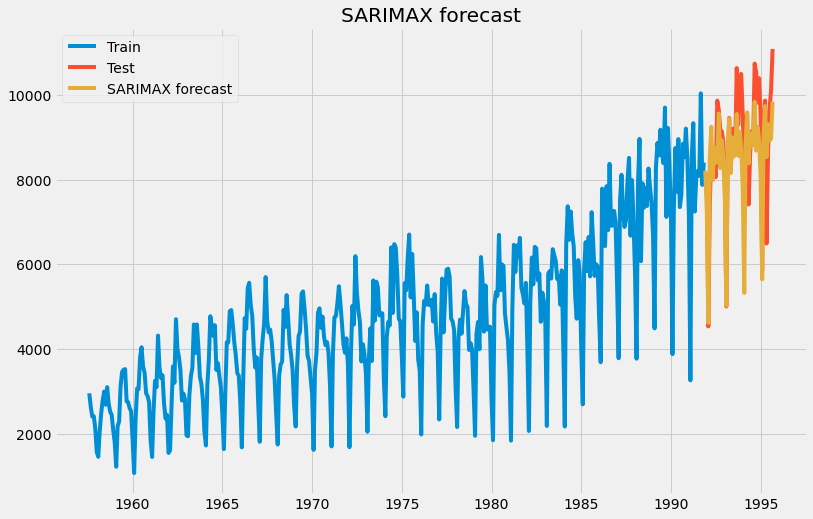

Evaluation metric results:-
MSE is : 953838.0915344693
MAE is : 719.3394308350956
MAPE is : 7.976239247381479
R2 is : 0.49821420256811044
RMSE is : 976.6463492659302



In [135]:
plot(method = "SARIMAX")

# Seasonal ARIMAX using Pmdarima Library

In [136]:
def auto_sarima(m, max_p= 3, max_q= 3, max_P=3 , max_Q=3  ,method = "Auto_SARIMAX"):
    model = pmd.auto_arima(train[time_dependent_variable], 
                               start_p=1, start_q=1,
                                max_p=max_p, max_q=max_q, seasonal=True, start_P=1,
                                start_Q=1, max_P=max_P, max_D=7, max_Q=max_Q, m=m,
                                X = exog_train,
                                d=None, D=None, trace=True, error_action='ignore', 
                                suppress_warnings=True,
                                stepwise=True,
                                n_jobs= -1)

    
    
    print("\n\n\n\n")
    print(method + " Model Summary is : ")
    print(model.summary())
    print("\n\n\n\n")
    
    y_hat.loc[:,method] = model.predict(len(test), X = exog_test)

    print("Test Dataset After Forecast: ")
    print(y_hat.head(5))
    print("\n\n\n\n")
#     arima_model.plot_diagnostics()
    
     
    
    return metrics_(method)
auto_sarima(m = 12)

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(1,0,1)[12] intercept   : AIC=inf, Time=1.39 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=7371.962, Time=0.03 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=inf, Time=2.76 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=6881.098, Time=1.01 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=7369.975, Time=0.20 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : AIC=7093.619, Time=0.53 sec
 ARIMA(0,0,1)(1,0,1)[12] intercept   : AIC=6470.234, Time=1.33 sec
 ARIMA(0,0,1)(1,0,0)[12] intercept   : AIC=6508.118, Time=1.07 sec
 ARIMA(0,0,1)(2,0,1)[12] intercept   : AIC=inf, Time=nan sec
 ARIMA(0,0,1)(1,0,2)[12] intercept   : AIC=6457.614, Time=3.35 sec
 ARIMA(0,0,1)(0,0,2)[12] intercept   : AIC=6738.772, Time=2.26 sec
 ARIMA(0,0,1)(2,0,2)[12] intercept   : AIC=inf, Time=2.12 sec
 ARIMA(0,0,1)(1,0,3)[12] intercept   : AIC=6511.459, Time=5.65 sec
 ARIMA(0,0,1)(0,0,3)[12] intercept   : AIC=inf, Time=4.92 sec
 ARIMA(0,0,1)(2,0,3)[12] intercept   : AIC=in

14.39977800428738

Choosing the best m value 

In [137]:
# for m in [1, 4,7,12,52]:
#     print("="*100)
#     print(f' Fitting SARIMA for Seasonal value m = {str(m)}')
#     auto_sarima(method = "Auto_SARIMA")
def auto_sarima_best_seasonal_params():
    best_score, best_cfg = float("inf"), None
    for m in [1, 4,7,12,52]:
        print("="*100)
        print(f' Fitting SARIMAX for Seasonal value m = {str(m)}')
        order = m
        try:
            metric = auto_sarima(m= m)
            if metric < best_score:
                best_score, best_cfg = metric, order
            print('SARIMAX%s metric=%.3f' % (order,metric))
        except:
            continue
    print('Best SARIMAX%s metric=%.3f' % (best_cfg, best_score))
    return best_cfg
    
best_cfg = auto_sarima_best_seasonal_params()


 Fitting SARIMAX for Seasonal value m = 1
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=6909.656, Time=0.66 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=7371.962, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=6909.170, Time=0.47 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=7093.619, Time=0.55 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=7369.975, Time=0.25 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=6910.182, Time=0.68 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.75 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=6907.207, Time=0.42 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=6908.170, Time=0.64 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=6908.098, Time=0.55 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=7090.891, Time=0.49 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.77 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0]          
Total fit time: 6.272 seconds





Auto_SARIMAX Model Summary is : 
                  

 ARIMA(1,0,1)(1,0,1)[7] intercept   : AIC=6892.557, Time=1.14 sec
 ARIMA(0,0,0)(0,0,0)[7] intercept   : AIC=7371.962, Time=0.04 sec
 ARIMA(1,0,0)(1,0,0)[7] intercept   : AIC=6908.820, Time=0.96 sec
 ARIMA(0,0,1)(0,0,1)[7] intercept   : AIC=7070.131, Time=0.90 sec
 ARIMA(0,0,0)(0,0,0)[7]             : AIC=7369.975, Time=0.26 sec
 ARIMA(1,0,1)(0,0,1)[7] intercept   : AIC=6898.667, Time=1.15 sec
 ARIMA(1,0,1)(1,0,0)[7] intercept   : AIC=6902.097, Time=1.07 sec
 ARIMA(1,0,1)(2,0,1)[7] intercept   : AIC=6897.448, Time=1.68 sec
 ARIMA(1,0,1)(1,0,2)[7] intercept   : AIC=6897.314, Time=1.59 sec
 ARIMA(1,0,1)(0,0,0)[7] intercept   : AIC=6909.656, Time=0.71 sec
 ARIMA(1,0,1)(0,0,2)[7] intercept   : AIC=6889.924, Time=1.54 sec
 ARIMA(1,0,1)(0,0,3)[7] intercept   : AIC=6892.530, Time=2.61 sec
 ARIMA(1,0,1)(1,0,3)[7] intercept   : AIC=6896.960, Time=3.27 sec
 ARIMA(0,0,1)(0,0,2)[7] intercept   : AIC=7021.475, Time=1.43 sec
 ARIMA(1,0,0)(0,0,2)[7] intercept   : AIC=6897.056, Time=1.42 sec
 ARIMA(2,0

 ARIMA(1,0,1)(1,0,1)[52] intercept   : AIC=inf, Time=15.23 sec
 ARIMA(0,0,0)(0,0,0)[52] intercept   : AIC=7371.962, Time=0.07 sec
 ARIMA(1,0,0)(1,0,0)[52] intercept   : AIC=6911.949, Time=11.94 sec
 ARIMA(0,0,1)(0,0,1)[52] intercept   : AIC=7079.339, Time=9.29 sec
 ARIMA(0,0,0)(0,0,0)[52]             : AIC=7369.975, Time=0.26 sec
 ARIMA(1,0,0)(0,0,0)[52] intercept   : AIC=6909.170, Time=0.48 sec
 ARIMA(1,0,0)(0,0,1)[52] intercept   : AIC=6911.980, Time=8.18 sec
 ARIMA(1,0,0)(1,0,1)[52] intercept   : AIC=inf, Time=11.97 sec
 ARIMA(2,0,0)(0,0,0)[52] intercept   : AIC=6910.182, Time=0.78 sec
 ARIMA(1,0,1)(0,0,0)[52] intercept   : AIC=6909.656, Time=0.66 sec
 ARIMA(0,0,1)(0,0,0)[52] intercept   : AIC=7093.619, Time=0.51 sec
 ARIMA(2,0,1)(0,0,0)[52] intercept   : AIC=inf, Time=0.69 sec
 ARIMA(1,0,0)(0,0,0)[52]             : AIC=6907.207, Time=0.37 sec
 ARIMA(1,0,0)(1,0,0)[52]             : AIC=6909.269, Time=8.13 sec
 ARIMA(1,0,0)(0,0,1)[52]             : AIC=6909.629, Time=8.76 sec
 ARIMA(

In [138]:
auto_sarima(m= best_cfg)

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(1,0,1)[4] intercept   : AIC=6833.466, Time=1.01 sec
 ARIMA(0,0,0)(0,0,0)[4] intercept   : AIC=7371.962, Time=0.04 sec
 ARIMA(1,0,0)(1,0,0)[4] intercept   : AIC=6911.677, Time=0.69 sec
 ARIMA(0,0,1)(0,0,1)[4] intercept   : AIC=6988.993, Time=0.64 sec
 ARIMA(0,0,0)(0,0,0)[4]             : AIC=7369.975, Time=0.20 sec
 ARIMA(1,0,1)(0,0,1)[4] intercept   : AIC=6911.616, Time=0.76 sec
 ARIMA(1,0,1)(1,0,0)[4] intercept   : AIC=6912.224, Time=0.51 sec
 ARIMA(1,0,1)(2,0,1)[4] intercept   : AIC=6793.139, Time=1.10 sec
 ARIMA(1,0,1)(2,0,0)[4] intercept   : AIC=6908.325, Time=1.03 sec
 ARIMA(1,0,1)(3,0,1)[4] intercept   : AIC=6550.640, Time=1.54 sec
 ARIMA(1,0,1)(3,0,0)[4] intercept   : AIC=6451.430, Time=1.63 sec
 ARIMA(0,0,1)(3,0,0)[4] intercept   : AIC=6845.290, Time=0.74 sec
 ARIMA(1,0,0)(3,0,0)[4] intercept   : AIC=inf, Time=1.68 sec
 ARIMA(2,0,1)(3,0,0)[4] intercept   : AIC=6501.422, Time=1.61 sec
 ARIMA(1,0,2)(3,0,0)[4] intercept   : 

10.424011230398907

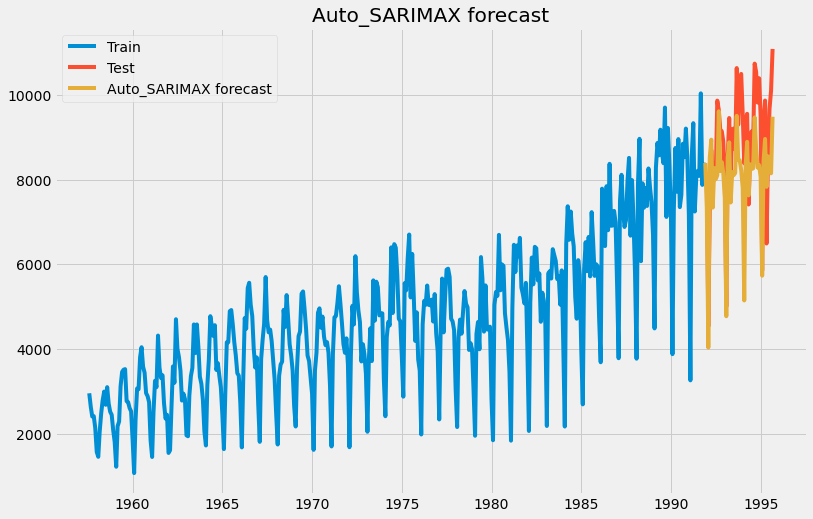

Evaluation metric results:-
MSE is : 1392022.6742912321
MAE is : 954.056871049723
MAPE is : 10.424011230398907
R2 is : 0.2676983506301337
RMSE is : 1179.8401053919265



In [139]:
plot(method=  "Auto_SARIMAX")

# Xgboost with extra Regressors

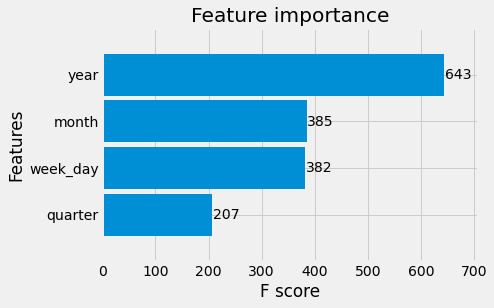

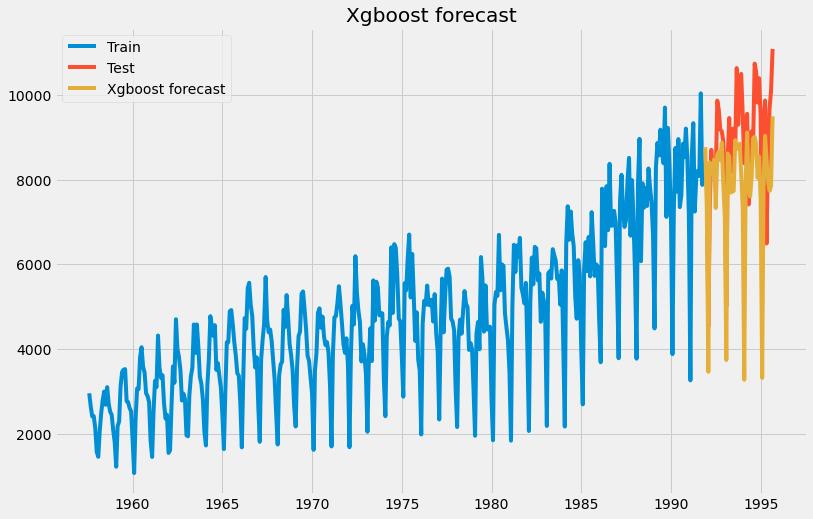

Evaluation metric results:-
MSE is : 2294103.4666934297
MAE is : 1232.889255689538
MAPE is : 14.221848362518386
R2 is : -0.2068594739953573
RMSE is : 1514.6298117670303



In [140]:
def xgboost(method= "Xgboost"):
    
    reg = xgb.XGBRegressor()
    reg.fit(train_X, train_Y,
            eval_set=[(train_X, train_Y), (test_X, test_Y )],
            early_stopping_rounds=5,
           verbose=False)
    
    y_hat[method] = reg.predict(test_X)
    _ = plot_importance(reg, height=0.9)
    plot(method= "Xgboost")
xgboost(method= "Xgboost")